<a href="https://colab.research.google.com/github/SimonTommerup/02805-sgai/blob/main/main_notebook15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports used

In [ ]:
!pip install powerlaw
!pip install colour
import pandas as pd
import numpy as np
import re
import nltk
import networkx as nx
import matplotlib.pyplot as plt
import json
import matplotlib.patches as mpatches
import matplotlib.patches as mpatches
import urllib
import powerlaw

from scipy import integrate
from scipy import stats
from fa2 import ForceAtlas2
from collections import Counter
from tqdm import tqdm
from colour import Color


plt.style.use("seaborn")

Mount google drive to quickly access network and data


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We can then load the data from the mount and the weighted network generated from this data

In [4]:
data_path = "drive/MyDrive/SGAI/data_all_merged.csv"
network_path = "drive/MyDrive/SGAI/G_weighted_T_B_removed.gpickle"
df = pd.read_csv(data_path, sep=";")
G_full = nx.read_gpickle(network_path) 


# Some usefull functions for data extraction

def extract_decoded_used_subreddits(df): 
    encoded_used_subreddits = np.array(df.used_subreddits)
    used_subreddits_list = []
    for l in encoded_used_subreddits:
      l1 = json.loads(l)
      used_subreddits_list.append(l1)
    return used_subreddits_list


def nodes_to_used_subreddits(dataframe, unique=False):
    users = [u for u in dataframe["user"]]
    if unique:
        used_subreddits = [list(set(json.loads(us))) for us in dataframe["used_subreddits"]]
    else:
        used_subreddits = [json.loads(us) for us in dataframe["used_subreddits"]]
    n2us = {}
    for u, us in zip(users, used_subreddits):
      n2us[u] = us
    return n2us


# 1 Motivation

Our motivation for doing this project is to explore two groups of internet users from a network science perspective and bring together a set of tools and techniques we have acquired from the course (02805) Social Graphs and Interactions in a useful way led by our curiosity that will provide real insights. 

Most information in modern days is exchanged on the internet. Political opinions and sentiments are shared at the speed of fiber cables on large internet fora. 

reddit is one of the largest internet fora with over 430 million monthly users from all over the world.  Around 50 million Americans and about a fourth of the Americans in the age between 25 and 29 uses reddit (https://www.oberlo.com/blog/reddit-statistics). 

This means reddit gives a unique insight to information into what is being discussed in America.

reddit is arranged into so-called subreddits where people discuss various subjects. Two of these subreddits are known as r/DonaldTrump and r/JoeBiden and is about the 2020 Presidential Candidates Donald Trump and Joe Biden and has many thousands of users each. 

We want to explore the similarities and differences in the interests of the users on the two subreddits as well as the similiarities and differences in what they are talking about and in how they are feeling. 

### 1.1 Our dataset
Our dataset consist of data from https://www.reddit.com, which is a [social news aggregation page](https://en.wikipedia.org/wiki/Reddit). 

The dataset was created by scraping the two subreddits r/DonaldTrump and r/JoeBiden on https://www.reddit.com. The dataset was assembled into a CSV-file with 2697 rows and 5 columns. 

Each row is a unique reddit user. 

The table below shows the five attributes in the columns along with their datatype in the CSV-file:


| user_name |  from_subreddit |  comment |  used_subreddits |
|---|---|---|---|
| string  | string  | string  |  JSON-encoded list | 

1. `user_name` is the unique reddit user name. 
2. `from_subreddit` is the subreddit from which the user was scraped and can take values `trump` for r/DonaldTrump and `biden` for r/JoeBiden. In this work we will often be referring to these users as Trump and Biden users respectively.
3. `comment` is a longer string holding the user's text comment. 
4. `used_subreddits` is a list of maximally 50 subreddits where users has their 50 most popular comments on. These are not necessarily unique. These will be refered to as a user's *subreddits* or *used subreddits*.




### 1.2 Preview of the data set

To illustrate section 1.1, below is the first three entries of the data set: 

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/SGAI/data_all_merged.csv", ";")

df.head(3).iloc[:, :4]

user  ...                                    used_subreddits
0        jackaust537  ...  ["Disney Vacation: Terrible illustrations foun...
1  TheCookie_Momster  ...  ["Am I the Asshole? ", "Am I the Asshole? ", "...
2         phoenix335  ...  ["Men's Rights :: Advocating for the social an...

[3 rows x 4 columns]

### 1.3 Why we chose this dataset

Our intention is to create real insights about two politically opposing groups on the internet which we believe reside on reddit's two fora r/DonaldTrump and r/JoeBiden. 

It is a main assumption of our dataset collection that people who uses r/DonaldTrump is likely positive towards Donald Trump and that people who uses r/JoeBiden is likely positive towards Joe Biden. 

Whether this assumption is sound or not is to be kept in mind. In the project this will be reflected by the fact that we denote users as either "r/DonaldTrump users" or "r/JoeBiden users" rather than "Donald Trump supporters" and "Joe Biden supporters". 

However it is well known that people to some degree seek out other people with whom they agree. This effect is known as visiting informational echo chambers (https://en.wikipedia.org/wiki/Echo_chamber_(media)). 

Therefore it can be inferred that by scraping users from these two subreddits, we scrape users with a political inclination in the direction of either Donald Trump or Joe Biden. 

The users and their political inclination are reflected in the data point attributes `user` and `from_subreddit`. 

Given our set of politically opposed user groups, the key things we wanted to explore was:

1. what interests the users on either subreddit?
2. what are the users talking about and in what way?

In order to adress (1) we assume that people use subreddits that interests them. Therefore we collected up to 50 other subreddits for each of the users on r/DonaldTrump and r/JoeBiden and per inference assembled them into a list of interests for each user which is stored in the data attribute `used_subreddits`. Finally to address (2) we stored the comments of each of the users we found on the two subreddits in the attribute `comment`. 







### 1.4 Goal for the end user's experience

We want to provide the end user with an understanding of a network of the users of r/DonaldTrump and r/JoeBiden. 

Concretely, this mean our goal is to equip the end user with

- exploratory network statistics to get a view from above of the network

- advanced network statistics to understand the deeper qualities of the network

- knowledge about working with a very connected network in a principled way

- sentiment analysis statistics of the two user groups making op the nodes of the network in order to understand similarities and differences in the language that makes up the comments

- text analysis statistics at varying levels of detail again in order to understand the diversity and similiarity of the comments

Our goal is that the end user after having read our project has a comprehensive understanding of the network and a firm knowledge about the similarities and differences among the user groups. 

# 2 Basic stats. Let's understand the dataset better


## 2.1 Building our data set
We used the Reddit API (https://www.reddit.com/dev/api/) through the PRAW wrapper (https://praw.readthedocs.io/en/latest/) to conduct the scraping.

In summary our data set was built by:

1. Collecting unique thread and comment ids.
2. Requesting and scraping comments by the unique ids.
3. Storing the scraped data in CSV files.
4. Merging the data into a final CSV file.

In the two subreddits r/DonaldTrump and r/JoeBiden we chose to go through 48 all time top comments in 36 threads limiting ourselves only to the top comments.

Top comments are the comments that are the most upvoted through the subreddit's existence. We selected to look at the top comments as we hypothesized that these reflect the subreddits' users well. We mean that they are representative of what we may term ideal users in the given subreddit. The subreddit itself selects these comments as content that is proper to the subreddit. Also there is a practical advantage: Most upvoted comments will likely contain a statement of some sort and not just be an emoji or single words. 

The most challenging part of the data collecting was to deal with a two second delay in each API request and further we ran into a number of server errors on Reddit's servers because of the long run time. Therefore we had to come up with a way to divide the data collection into manageable chunks. This was done by first collecting all the unique thread and comment ids that we wanted to look at and then requesting these ids directly through the api. In this way we split the data collection into six manageable chunks (each took about six or seven hours to scrape due to the delay) with half Trump thread and half Biden threads. The collected data was then saved to separate CSV files. 

Also we realized that there were some Trump threads where there were not quite enough comments on, so we had to expand the data with some Trump user injections in order to balance the data set between Trump and Biden users. This was possible as we knew which thread ids we had already gone through and as such we could carry on from where we left.

After completing the collection of all the chunks, we merged all the collected data into a final CSV file to use for our project. Note that simply adding a list to ``pandas`` dataframes will convert the list into one large string - i.e. the data will then no longer be represented as a list. To overcome this, we represent a list in a string format by json-encoding the data with ``json.dumps``. Thus, whenever we read ``used_subreddits`` from the dataframe, we can decode the string into list format again using ``json.loads``.


## 2.2 Code for scraping reddit

The Python implementation of our data building can be seen in our GitHub repository (https://github.com/SimonTommerup/02805-sgai/tree/main/project) where mainly `data_generator.py` does the actual scraping - and in part `utils.py` where the function `get_data_ids` was built to collect the thread and comment ids. These scripts also utilises the ``reddit.py`` for login credentials and ``merge_data.py`` to unite the different chunks of scraped data. 

## 2.3 Stats of the data set



### 2.3.1 Exploring ``from_subreddit``
Our reddit data set consist of 4 MB data constituting 2697 data rows - one for each scraped user. The users are distributed into Trump and Biden users as shown below


In [ ]:
print("Trump users: ", n_trump)
print("Biden users: ", n_biden)


labels = 'Trump', 'Biden'

n_biden = len([u for u in df.from_subreddit if u == "biden"])
n_trump = len([u for u in df.from_subreddit if u == "trump"])
sizes = [n_trump, n_biden]

explode = (0, 0) 

fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ["crimson", "royalblue"])
ax1.axis('equal')  

plt.show()



Trump users:  1339
Biden users:  1358


We see that there are almost equally many users representing each subreddit page. Below we check ignore user's ``from_subreddit``(i.e. where we found them) and only investigate how frequent the Trump and Biden users appears in the users' top 50 comments: 

In [ ]:
boths = 0
bidens = 0
trumps = 0
neithers = 0
n2us = nodes_to_used_subreddits(df, unique=True)

for (n, subrs) in n2us.items():
    if "trump" in subrs and "biden" in subrs:
        boths+=1
    elif "trump" in subrs and "biden" not in subrs:
        trumps+=1
    elif "trump" not in subrs and "biden" in subrs:
        bidens+=1
    else:
        neithers+=1

print("Users with one of their top 50 comments on")
print("ONLY Trump: ", trumps)
print("ONLY Biden: ", bidens)
print("on Both: ", boths)
print("on Neither: ", neithers)
print("----------------------------")
print("Total no. of users in df 2697")

Users with one of their top 50 comments on
ONLY Trump:  727
ONLY Biden:  723
on Both:  15
on Neither:  1232
----------------------------
Total no. of users in df 2697


We see that of the $727+723+15=1465$ users with a *top comment* on any of the two candidate subreddits, only $\frac{15}{1465}\cdot100\%\approx 1\%$ of the users have a top comment on both of them. This suggest that users who have top comment on one of the subreddit pages typically do not have a top comment on the other one also. Moreover, we see that of all the users, $\frac{1232}{2697}\cdot100\%\approx 46\%$ of them have 50 other top comments on reddit, which are more popular than the one they have on the candidate's subreddit page.

### 2.3.2 Exploring ``comments``


Each user is associated with their comment on either the Biden or Trump subreddit. These 2697 comments are distributed as shown below with respect to number of words in each user's comment. The regex expression to tokenize comments are described later in section 3.4

Minimum : 0, Maximum: 878, Average: 24.13


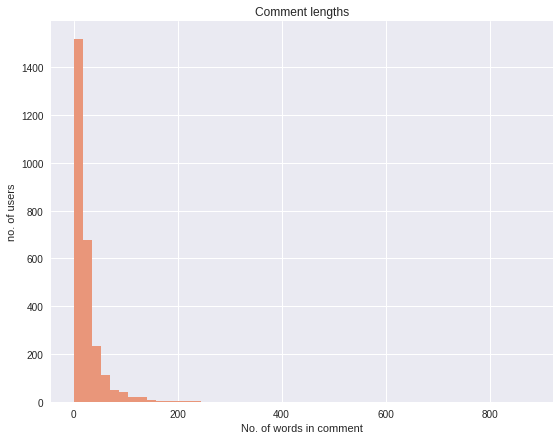

In [ ]:
def plot_histogram(values, title, xlabel, ylabel, n_bins):
    k_min = np.min(values)
    k_max = np.max(values)
    print(f"Minimum : {min(values)}, Maximum: {max(values)}, Average: {round(np.mean(values), 2)}")
    count, bins = np.histogram(values, bins=n_bins)
    plt.subplots(figsize=(9,7))  

    # Hist plot
    plt.hist(values, bins, color="darksalmon")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


comments = np.array(df.comment)
# Extract number of words for each comment 
comment_lengths = [len(re.findall(r"\w+(?:[-']*\w*)*", c)) for c in comments]
plot_histogram(comment_lengths, title="Comment lengths", xlabel="No. of words in comment", 
               ylabel="no. of users", n_bins=50)



We see that there are a few users with extremely long comments - and that the majority of users have comments about 25 words long. Looking closer at the majority of comments:

In [ ]:
labels = 'below 5 words', '5-25 words', "25-50 words", "More than 50 words"

# Extract users with different comment lengths
n1 = len([l for l in comment_lengths if l<=5])
n2 = len([l for l in comment_lengths if l<=25 and l>5])
n3 = len([l for l in comment_lengths if l<=50 and l>25])
n4= len([l for l in comment_lengths if l>50])

sizes = [n1, n2, n3, n4]


# Plot pie chart
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ["darkslategray", "darksalmon", "lightskyblue", "lightgoldenrodyellow"])
ax1.axis('equal')  

plt.show()



we see that the majority of comments are below 25 words constituting $36.7\% + 54.4\% = 71.2\%$ of all comments. From visiting different subreddit we furthermore see that the very short comments (below 5 words) typically include an image. 25 examples of random comments are printed below

In [ ]:
print(comments[:25])

["I know a lot of people who hate on Trump supporters just because they support him.  I'm not too fond of his policies, but I don't dislike Trump supporters because of that.  Everybody's entitled to their own opinion."
 'I recall seeing thousands of Obama stickers, not as many Hillary, but still a considerable amount, and zero Biden stickers. Yes ZERO. And I live in a blue state. i wonder if the only votes for Biden are really votes against trump and how many people will really bother to go out and vote when they have no enthusiasm for their candidate.'
 'You can tell this is a completely fabricated story by the claim to have seen a Biden sticker.\n\nNobody has a Biden sticker. There are no Biden fans in the real world.'
 'You had me in the first half ngl'
 'People don’t want a sticker synonymous with pedophile on their car.'
 'I had trump 2020 side mirror covers (along with a flag, bumper stickers, and a life sized picture of trump’s head in my back window so it looks like i’m his cha

Which truly reveal that the language is typical of a discussion forum.

### 2.3.3 Exploring ``used_subreddits``

First of all, we can see how many of the users had at least 50 comments on reddit.

In [ ]:
# Get used subreddit
n2us = nodes_to_used_subreddits(df, unique=False)

# Get user's amount
lens = [len(li) for li in n2us.values()]

# How many are below 50
limit=50
lens_low = [len(li) for li in n2us.values() if len(li) < limit]

# Print
print(f"{len(lens)-len(lens_lows)} users ({round((1-len(lens_lows)/len(lens))*100,1)}%) has {limit} comments on other subreddits")
plot_histogram(lens, title="Number of comments pr. user", xlabel="number of comments",
               ylabel="number of users", n_bins=50)



2525 users (93.6%) has 50 comments on other subreddits
Minimum : 1, Maximum: 50, Average: 48.25


We can see that we successfully found users where most are very active on reddit in general. 93% of the users scraped have 50 associated top comments.

Many of these may be on the same subreddit. Therefore, it is interesting to look at how many *unique* subreddits each user has commented on. 

Minimum : 1, Maximum: 47, Average: 18.6


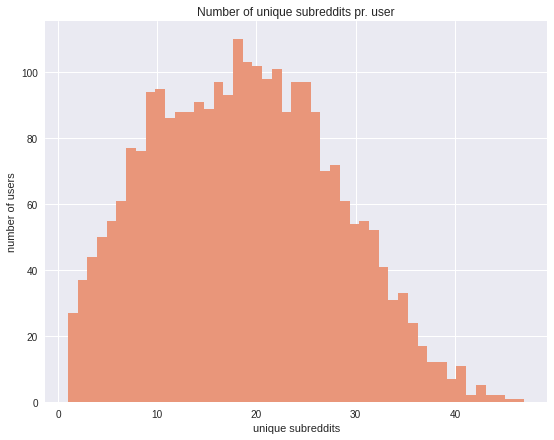

In [ ]:
# Get used subreddit
n2us = nodes_to_used_subreddits(df, unique=True)

# Get user's amount
lens = [len(li) for li in n2us.values()]

# Print
plot_histogram(lens, title="Number of unique subreddits pr. user", xlabel="unique subreddits",
               ylabel="number of users", n_bins=max(lens))

It appears that most users have top comments on about 10-30 subreddits, with an average number of 19. A few has only a single unique subreddit, which then must be either the Trump or Biden subreddit. 

To get an initial impression of how frequent the subreddits appear, we plot how they are distributed among users below. In total we have


In [ ]:
# Get all subreddit
n2us = nodes_to_used_subreddits(df, unique=True)
all_subreddits = []
for s in list(n2us.values()):
    all_subreddits+=s
print("total number of unique subreddits: ", len(set(all_subreddits)))

total number of unique subreddits:  6595


These ~6600 different subreddits are distributed like shown below in terms of frequency among users

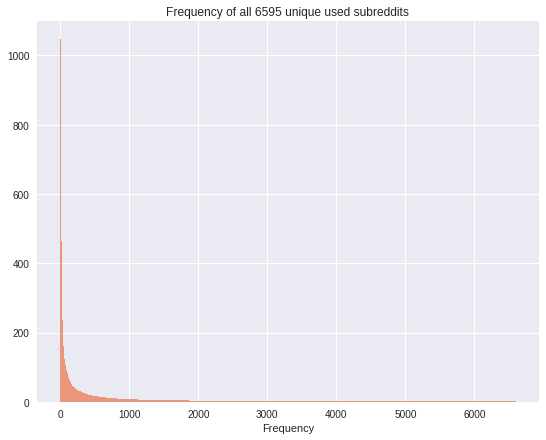

In [ ]:
# Compute their frequencies 
all_subreddits_freqs = list(nltk.FreqDist(all_subreddits).values())
all_subreddits_freqs = sorted(all_subreddits_freqs, reverse=True)

# plot
plt.subplots(figsize=(9,7))

plt.bar(np.arange(len(all_subreddits_freqs)), all_subreddits_freqs, 20, color="darksalmon")

plt.title(f"Frequency of all {len(set(all_subreddits))} unique used subreddits")
plt.xlabel("Subreddit number ranked by frequency")
plt.xlabel("Frequency")

plt.show()

It clearly appears that there are a few subreddits which are very popular among the majority of users, and a lot which are very infrequent.

Below the 20 most popular subreddits are shown (besides from the Trump and Biden)

In [ ]:
all_subreddits_freqs = [(red, freq) for (red, freq) in nltk.FreqDist(all_subreddits).items() if red!="trump" and red!="biden"]


all_subreddits_freqs = sorted(all_subreddits_freqs, key = lambda x: x[1], reverse=True)

grid_view = []
for idx in range(2):
  grid_view.append(all_subreddits_freqs[10*idx:10*idx+10] )

df_user_top100 = pd.DataFrame(data=grid_view, columns=[c for c in range(10)])
df_user_top100

0  ...                                                9
0  (Ask Reddit..., 1046)  ...  (A subreddit for cute and cuddly pictures, 350)
1        (r/gaming, 333)  ...     (For your Opinions that are Unpopular , 242)

[2 rows x 10 columns]

We see that the general picture is that a lot of our reddit users write comments on news and politic related subreddits (a few examples:  ``Politics``, ``All news, US and international`` and ``Conservative``), which is quite sensible considering we found them on Biden and Trump subreddits. Besides from that we see a lot of subreddit which relates to entertainment, amusement and discussion forums like ``Ask Reddit..``, ``funny`` and ``r/videoes``.

As the ladder distribution suggests, reddit has some overall very popular subreddits. The 100 most popular along with their number of subscribers (in millions) are shown below, where we color all subreddit, which are mutual with the 100 most popular of our data set.

In [ ]:
def subreddit_in_top100(subreddits_freqs, s_100):  
    s_100 = s_100.replace("r/", "")
    s_100 = re.sub("[^0-9a-zA-Z]+", "", s_100)
    # Loop over all subreddits in list
    for (s, f) in subreddits_freqs:
        is_top_100 = False
        # Make titles fit
        s_form = s.replace("r/", "")
        s_form = s_form.replace("(TIL)", "")
        s_form = re.sub("[^0-9a-zA-Z]+", "", s_form)
        
        #Check if subreddit matches with the top100 subreddit
        if s_form.lower() == s_100.lower():
            return True
      
    return False


url = "https://frontpagemetrics.com/top"
response = urllib.request.urlopen(url)
html = response.read()
# Scrape names
rawtop100 = re.findall("r\/\w*", html.decode("utf-8"))
# and their frequencies
rawtop100_freq = re.findall("\w*,\w*,\w*", html.decode("utf-8"))
rawtop100_freq = [n[:n.find(",")] for n in rawtop100_freq]

# First hit is just "r/" 
rawtop100 = rawtop100[1:]

# Subreddits appear twice in the html 
top100 = []
for subreddit in rawtop100:
  if subreddit not in top100:
    top100.append(subreddit)

# Append frequencies
for i, freq in enumerate(rawtop100_freq):
    top100[i]+= ": " + freq

# Extract top 100 for users
user_top_100 = all_subreddits_freqs[:100]

grid_view = []
for idx in range(10):
  grid_view.append( top100[10*idx:10*idx+10] )

df_top100 = pd.DataFrame(data=grid_view, columns=[c for c in range(10)])
df_top100

df_top100.style.apply(lambda x: ["background: darksalmon" if subreddit_in_top100(user_top_100, v[:v.find(":")]) else "" for v in x], axis = 1)



The table is sorted left to right and then top to bottom. This shows that although there are many similarities for the two top 100s, the users in our dataset are distributed a little differently than the general picture of reddit users. Both are characterized by many entertainment/amusement subreddits, but also politic and news related ones - although these are more frequent among the users in our data set. For instance, "politics" (entry \[5,5\]) are rated no. 36 in the global, where it is number two in our data set.  

# 3 Tools, theory and analysis. Describe the process of theory to insight


## 3.1 Creating network and initial analysis



As mentioned and discussed in previous sections, we will be investigating active users on the subreddit pages of the two 2020 presidential candidates of USA [Trump](https://www.reddit.com/r/donaldtrump/) and [Biden](https://www.reddit.com/https://www.reddit.com/r/joebiden/). We are interested in examining how users connect based on *other subreddits* which they are also active on (in terms of top comments). To do this we will first create a bipartite network of users and subreddits, to subsequently project this into a netork of users. 





### 3.1.1 The bipartite network
To describe the bipartite network of users and subreddits, we have 
- $U$, the set of users
- $M$, the two 'main subreddits', which are the [Trump](https://www.reddit.com/r/donaldtrump/) and [Biden](https://www.reddit.com/https://www.reddit.com/r/joebiden/) subreddits.
- $S^u$, the set of subreddits which $u \in U$ has commented on, excluding subreddits in $M$. 
- $S$, the set of all subreddits commented on by all users, ${\bigcup_{u \in U} S^u}$. 

We can assemble this data into a undirected bipartite network $G_{bi}$ with two distjoint sets of nodes $U$ and $S$. A user $u \in U$ is connected to subreddit $s \in S$ if $s \in S^u$. This means that we have a network $G_{bi}$ where a user has a connection to all subreddits which it have commented on, excluding the Trump and Biden subreddit. And these subreddits are further connected to every other user, which has also commented on this subreddit. From this point on, we will write user and node interchangeably.

Note that we do not link users based on the main subreddits as this would otherwise link all users found on the Trump-subreddit to each other, and similarly all users found on the Biden-subreddit. First of all it would lead towards a biased (high) modularity for separating the network into two communities based on whether they are Biden or Trump users. Second, we are interested in investigating which *other* subreddits than the two main ones, the users have in common. Thus, we exclude these when connecting two users.



### 3.1.2 Building a weighted network of users
In order to obtain the network of users, a projection of $G_{bi}$ is considered. To preserve as much information from $G_{bi}$ as possible, links between users are scaled based on the number of common subreddits, which both users have top comments on. 

Specifically, users $u_i, u_j \in U$ are connected with weight equal to the size of $S^{u_i}\cap S^{u_j}$.

Below we create the weighted network from an implicit representation of $G_{bi}$, by acessing the data directly from the pandas dataframe

In [9]:
def get_ids_of_users_with_common_subreddits(user_id, users, used_subreddits):
    users_with_common_subreddits = []
    for other_user_id in range(len(users)):
        if other_user_id != user_id:  # Skip connection to self
            for subr in used_subreddits[user_id]:
                if subr in used_subreddits[other_user_id]:
                    users_with_common_subreddits.append(other_user_id)
                    break
    return users_with_common_subreddits


def get_common_subreddits(user_id, other_user_id, used_subreddits):
    common_subreddits = [subreddit for subreddit in used_subreddits[user_id] if subreddit in used_subreddits[other_user_id]]
    return common_subreddits

  
def create_graph(users, used_subreddits, from_subreddits, commons_2_ignore, n_required_subreddits=1):
    G = nx.Graph()
    # Loop through all users
    for user_id in tqdm(range(len(users))):
        # Add a node for EVERY user in data set 
        G.add_node(users[user_id], from_subreddit=from_subreddits[user_id])

        # Get all other users with atleast one other subreddit in common, 
        other_users_id = get_ids_of_users_with_common_subreddits(user_id, users, used_subreddits)
        for other_user_id in other_users_id:
            # Save all UNIQUE common subreddits as edge property if constraints are satisfied
            common_subreddits = get_common_subreddits(user_id, other_user_id, used_subreddits)
            common_subreddits = list(set(common_subreddits))
            # Remove the two main subreddits (trump and biden) as common subreddit.
            common_subreddits = [subreddit for subreddit in common_subreddits if subreddit not in commons_2_ignore]
            # Only link edges if #common_subreddits > n_required_subreddits
            if len(common_subreddits) >= n_required_subreddits:
                G.add_edge(users[user_id], users[other_user_id], common_subreddits=(common_subreddits), 
                           weight=len(common_subreddits))
    return G


# Extract data to more effeciently loop through it rather than looping through a df
used_subreddits, users, from_subreddits  = extract_decoded_used_subreddits(df), np.array(df.user), np.array(df.from_subreddit)

commons_2_ignore = ['trump', 'biden', ""]

# Create graph
G_full = create_graph(users, used_subreddits, from_subreddits, commons_2_ignore, n_required_subreddits=1)

Initially, we look closer at the size of the connected components of the network

In [10]:
# Extract the largest connected components
CCs = list(nx.connected_components(G_full))

# Print lengths
comps = [list(comp) for comp in CCs]
print("Sizes of the connected components: ", [len(comp) for comp in comps])

Sizes of the connected components:  [2669, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


It reveals that almost the entire network is connected, and only 28 users are disconnected. These users are inspected for which type of subreddits they comment on:

In [11]:
# Extract users which are not in largest component 
removed_users = [comp[0] for comp in comps if len(comp) == 1]
removed_users_subreddits_with_lengths = []

# Print their info of used subreddits:
for i in range(len(users)):
  if users[i] in removed_users:
    res_string = ""
    for s in set(used_subreddits[i]):
      if len(s) > 10:
        print_s = s[:10] + "..."
      else:
        print_s = s
      res_string+=print_s + ": " + str(len([n for n in used_subreddits[i] if n == s])) + "  "
    removed_users_subreddits_with_lengths.append(res_string)

df_removed_users = pd.DataFrame({'User':removed_users,
                                 'Used subreddits w. counts':removed_users_subreddits_with_lengths
                                })
df_removed_users

User                 Used subreddits w. counts
0          Trouble_Short                                trump: 1  
1            ArcEchoFive                                trump: 4  
2        Future_Cup_2762                               biden: 50  
3                  jd33d                               biden: 24  
4            Connorskath                                biden: 1  
5               Carmar10                                biden: 1  
6              hamel7777                                biden: 1  
7    Words-Always-Matter                               biden: 50  
8      Popular_Vote_1001                                trump: 1  
9            Rocco112263                    biden: 10  trump: 18  
10    JuanCarlosHuegosJr                               biden: 50  
11  WhoTheFLetTheDogsOut                                trump: 5  
12       DafuksieThinkin                               trump: 18  
13         SatireloverLA                                trump: 1  
14           AZ4JoeBiden                               biden: 50  
15              95xander            Temple Uni...: 27  biden: 23  
16  Lazy_Bodybuilder_363             trump: 2  Open Sourc...: 10  
17         stereoswimmer  JustNoFIL: 3  JustNoTalk: 5  biden: 42  
18      RidinWithBiden23                               biden: 50  
19         Stone__Boogie                                trump: 1  
20        Fair_Coast1347                                trump: 2  
21         LeatherPretty                                trump: 1  
22              kkaplan5              The go-to ...: 2  trump: 2  
23    Quirky-Mistake6587                                trump: 1  
24   throwawayadvice9238                               biden: 37  
25              thisdj78                               biden: 50  
26   AmericaForBiden2020                               biden: 50  
27          PaRepublican                                trump: 1

The table shows the 28 users which have no links in the network. For each user, their unique used subreddits are printed along with how many of their top 50 comments where on this specific subreddit. This shows some different characteristics of these users.

First, we see that there are some users which are rather inactive on reddit (with commenting). They have only commented a few times on any subreddit - and of course these are primarily at biden and trump, as we initially found the user by looking at their comment at these. Thus, as we do not link according to these two main subreddits as mentioned above, these users have no links.

Then, there is a group of users who are somewhat active on a few seemingly less popular subreddits, which none of the other 2697 users have top comments on.

Finally, there is a group of people who are extremely active on the trump and especially biden subreddits, as their top 50 comments only happens to be on these two specific subreddits. 

As the purpose of this work is to investigate *other* common interests between trump/biden-subreddit users, these users are not considered in the rest of the network analysis. Therefore, we extract the largest connected component.



In [12]:
# Use largest component as network
nodes_of_LC = (max(CCs, key=len))
G = G_full.subgraph(nodes_of_LC).copy()

As supplement to this work, it would be interesting to further investigate and retrieve more data on these very comitted/dedicated trump or biden users who primarily comment on these two subreddits.

### 3.1.3 Basic stats and properties of the weighted network



#### 3.1.3.1 Motive


We want an initial impression of the weighted network by calculating the following stats
- Number of nodes
- Number of edges
- Min weighted and unweighted degree
- Max weighted and unweighted degree
- Median of weighted and unweighted degrees
- Mode of weighted and unweighted degrees
- Average weight of links
- Average weighted and unweighted degree
- Density

Additionally, we will look a bit into the node and edge attributes by computing
- Ten most conneted users' used subreddits
- Weight of links within each candidate's users
- Weight of links across each group of candidates' users

These measures will help determining how to to approach further analysis of the network






#### 3.1.3.2 Tools
For this network, the *unweighted* degree of a user is equal to the number of other users with at least on subreddit in common. Whereas the *weighted* degree is the sum of common subreddits with every other user in the network (i.e. the sum of weights of all links). For example, if three users $u_1, u_2$ and $u_3$ have respectively commented on subreddits,
* $s_1$: "Ask reddit", "Funny cats" and "Conspiracies",
* $s_2$: "Ask reddit", "Funny cats" and "Funny dogs" 
* $s_3$: "Ask reddit" and "Animals are not fun"

then $u_1$ would have degree three as $u_1$ have two common subreddits with $u_2$ and one with $u_3$. Similarly $u_2$ has degree three and $u_3$ degree two.


From this definition, measures can be explained as
- *Number of nodes $N$*: the number of reddit users in the network
- *Number of edges $L$*: the number of connections between users, disregarding the weight of the link. This means a link between two users with one subreddit in common, and a link between two other users with 50 subreddits in common contributes equally to this count (with one each). 
- *Min degree*: The minimum degree value of all users
- *Max degree*: The maximum degree value of all users
- *Median*: The value which seperates users into two halfs, one with larger degrees and another with lower degrees.
- *Mode*: The degree value which is most frequent among all users
- *Average weight of links*: The average number of common subreddits between two users.

Furthermore, for $k_{u}$ being the degree of user $u$, and $L_{max}$ being the theoritcal maximum number of links in a network with $N$ nodes (a fully connected network), we can define
- *Average degree*: $\langle k \rangle=\frac{1}{N}\sum_{u} k_{u}$
- *Density*: $D=\frac{L}{L_{max}}$

where
$ L_{max} = \frac{N(N-1)}{2} \quad \text{(Barabasi, eq 2.12)}$


#### 3.1.3.3 Results and discussion

All these **basic stats** can easily be computed using the ``networkx``, ``collections`` and ``numpy`` libraries as follows






In [ ]:
# Extract unweighted degrees
degrees = [d for user, d in G.degree(weight=None)]

# Extract all weighted degrees
degrees_weighted = [d for user, d in G.degree(weight='weight')]


# Inserting data into pandas for nice prints
df_stats = pd.DataFrame({'N':[len(G.nodes), len(G.nodes)],
                         'L':[len(G.edges), len(G.edges)],
                         'Min degree':[np.min(degrees), np.min(degrees_weighted)],
                         'Max degree':[np.max(degrees), np.max(degrees_weighted)],
                         'Median degree':[int(np.median(degrees)), int(np.median(degrees_weighted))],
                         'Mode':[Counter(degrees).most_common(1)[0][0], Counter(degrees_weighted).most_common(1)[0][0]],
                         'Avg weight':[1, round(np.mean([w for u, v, w in G.edges(data="weight")]), 2)],
                         '⟨k⟩':[int(round(np.mean(degrees), 0)), int(round(np.mean(degrees_weighted),0))],
                         'D':[round(nx.density(G),2), "-"]
                         }, index=["unweighted", "weighted"])

df_stats


N        L  Min degree  Max degree  ...  Mode  Avg weight   ⟨k⟩     D
unweighted  2669  1849355           1        2358  ...  1022        1.00  1386  0.52
weighted    2669  1849355           1        9022  ...  1022        1.94  2690     -

[2 rows x 9 columns]

Stats are indicated for when considering the network both as a weighted and a unweighted network. The unweighted network is the weighted network, where all weights are set to one - i.e. users with two, eight or 22 common subreddits are all connected with same weight. 

We see that the unweighted network is very dense with 2669 nodes and nearly two million links. This also appears from the density score of 0.52 - i.e. the unweigted network contains more than half of the edges that a complete network of 2669 nodes would. The dense structure of the network also appears from the unweighted network having a median degree of 1531 and average degree 1386. This means that on average, a user has at least one subreddit in common with half of the users in the network. Further, it is seen that the most connected user has a degree of 2358, i.e. has at least one common subreddit with $\frac{2358}{2669}\cdot100\%=88\%$ of users in the network. 

The weighted network is a little more complicated to interpret. Like the unweighted network, it has a minimum degree of 1 - i.e. both networks has users where there in the network exists only one other user with exactly one subreddit in common. Furthermore, the max degree is 9022, which means that this user's subreddits appear 9022 times in total among the other users in the network. Hence, this user's subreddits are very common among the other users. Additionally, both network's most frequent degree is 1022. Furthermore, we see that the average degree is 2690. Thus users on average has subreddits, which appears this many times among the users in the network. These facts together with a median degree of 2393 testifies that users in this data set generally have many subreddits in common. 

Note that density is not indicated for the weighted network, as this measurement is mostly meaningfull for the unweighted network. A somewhat similar measure would be to compute how weighted connections are in the network relative to the corresponding complete network with maximum weight. As we for each user have gathered 50 used subreddits, users can at maximum link with weight 50 - which is exactly when users have their top 50 comments on the exact same 50 subreddits. First, we compute the sum of all the weighted connections in the network, $w_{total}$:



In [ ]:
weights_of_all_edges = ([w for u, v, w in G.edges(data="weight")])
print("Sum of weight of all edges: ", f"w_total={sum(weights_of_all_edges)}")

Sum of weight of all edges:  w_total=3589416



Thus, for $L_{max}$ as the theoritcal maximum number of links, each with maximum weight equal to 50, we have:

$$
\frac{w_{total}}{L_{max}\cdot 50} = \frac{w_{total}}{\frac{N(N-1)}{2}\cdot 50} = \frac{3,589,416}{\frac{2669(2669-1)}{2}\cdot 50} = 0.02
$$
0.02 tells that weights of links in the network constitutes 2% of what the complete network with maximum weight would have. This number further supports the fact from before that the network is relatively dense, when we consider what the complete network represents - a network of 2669 users where they have all commented on the same 50 subreddits (with no subreddit appearing twice), among the currently (in 2020) [2.2 million subreddits](https://www.oberlo.com/blog/reddit-statistics). That our network constitutes weights equal 2% of this very unlikely network and users on average have ~2 unique subreddits in common suggests one of two things;
1. either we've found a group of relatively connected users, or
2. (probably more likely from what we saw previously) there are some subreddits which are common among most users on reddit in general

If 2. is the case, we will expect a lot of users to link (weakly) upon a few in general popular subreddits and some of the most connected users to have a lot of these






Below this is further investigated by exploiting the **properties of the network** - specifically which subreddits the most connected users has top comments on. We extract the ten most connected users with respect to weighted degree.

In [ ]:
# 5 Most connected users
user_with_degrees = [(user, d) for user, d in G.degree(weight="weight")]
user_with_degrees_sorted = sorted(user_with_degrees, key=lambda x: x[1], reverse=True)[:10]

# Extract users' rows from original df 
top10_users = [user for user, d in user_with_degrees_sorted]
top10_df = df.loc[df['user'].isin(top10_users)].iloc[:, 0:4].copy()
degrees_correct_order = [G.degree(weight="weight")[u] for u in top10_df.user]
top10_df['degree'] = degrees_correct_order
top10_df.sort_values(by=['degree'], inplace=True, ascending=False)

top10_df

user  ... degree
368     geethanksprofessor  ...   9022
2105   prickwhowaspromised  ...   8859
2000    Cannot_go_back_now  ...   8754
1293         perdhapleybot  ...   8692
1614           semantikron  ...   8567
2325            capoony147  ...   8299
1193              bishslap  ...   8160
1843       Mecmecmecmecmec  ...   8155
416   TAU_doesnt_equal_2PI  ...   7877
420                raddits  ...   7854

[10 rows x 5 columns]

It quickly appears that it is mostly biden users which are the most central users with respect to degree. And additionally, that e.g. ``Ask Reddit...`` is common for some of the top users. That Biden users appear more frequent suggests that they might represent the interests (subreddits) of the users better in general, or that they are more densely connected in between. 

To better see the *unique* subreddits of the most connected users, we extract them for the three most connected users "geethanksprofessor", "prickwhowaspromised" and "Cannot_go_back_now"

In [ ]:
top10_used_subreddits = np.array(top10_df['used_subreddits'])

# Remember: we need to decode json objects!
top10_unique_used_subreddits = [list(set(json.loads(subreddits))) for subreddits in top10_used_subreddits]

# Add empty lists for putting into df
for s in top10_unique_used_subreddits:
  while len(s) < len(max(top10_unique_used_subreddits, key=len)):
    s.append("")

# Add to a df for visualization
df_top_reddits = pd.DataFrame()
for i, user in enumerate(top10_users[:3]):
  df_top_reddits[user]=top10_unique_used_subreddits[i]


df_top_reddits

geethanksprofessor  ...                                 Cannot_go_back_now
0                                  Enough Трамп Spam!  ...                    All news, US and international.
1                     All news, US and international.  ...                       Barba non philisophum facit.
2                                   /r/PublicFreakout  ...                    Your Account Has Been Suspended
3                                Popcorn tastes good.  ...                                 BlackPeopleTwitter
4             Let's hope you didn't vote for the pedo  ...                          Insane People on Facebook
5                                 Bad Cop, No Donut!   ...                              Today I Learned (TIL)
6                                  It's Mueller Time!  ...                A gallery of inexplicable stupidity
7                               Today I Learned (TIL)  ...                                      Ask Reddit...
8                 A gallery of inexplicable stupidity  ...                                     Get Motivated!
9                                       Ask Reddit...  ...                                           Politics
10                                         conspiracy  ...                                        Reddit Pics
11                                           Politics  ...                                     /r/Technology 
12                                        Reddit Pics  ...  .gifs - funny, animated gifs for your viewing ...
13                                       Conservative  ...           A subreddit for cute and cuddly pictures
14                                     /r/Technology   ...                                  Murdered By Words
15  .gifs - funny, animated gifs for your viewing ...  ...                                         World News
16       People who actively act like a piece of shit  ...                                 All things Trashy!
17                                  Murdered By Words  ...                   /r/Memes the original since 2008
18                                         World News  ...                               White People Twitter
19                                     Reddit Science  ...  OldSchoolCool: History's cool kids, looking fa...
20             /r/guns: Firearms and related articles  ...                          Movie News and Discussion
21                                          /r/videos  ...                                            Android
22  2020 Political Hindsight - a Donald Trump love...  ...                                           r/gaming
23                      Sadly, this is not the Onion.  ...                                              funny
24              For your Opinions that are Unpopular   ...                                         >greentext
25          TumblrInAction: O Toucan, Where Art Thou?  ...                                          Westworld
26                                  Data Is Beautiful  ...                     Television News and Discussion
27                                              funny  ...                    Grimdank Warhammer 40,000 Memes
28                  r/Libertarian: For a Free Society  ...                              "What have I done..."
29                      What Could Possibly Go Wrong?  ...                                     Advice Animals
30                                                     ...                          Jokes: Get Your Funny On!
31                                                     ...                                                   
32                                                     ...                                                   
33                                                     ...                                                   
34                                                     ...                                                   
35                                                     ...                 

Several things can be observed from the top connected users' used subreddits. They all seem to have commented on many subreddits, which are frequent among the global top 100. To mention a few, "[Ask Reddit...](https://www.reddit.com/r/AskReddit/)", "[r/videos](https://www.reddit.com/r/videos/)" and "[funny](https://www.reddit.com/r/funny/)" all have more than 24 million members. Also, there seem to be some political subreddits, e.g. "[Conservative](https://www.reddit.com/r/Conservative/)" with 500 thousands members and [Politics](https://www.reddit.com/r/politics/) with 8 million. Finally, there also seem to be some pretty specific (and maybe less common) subreddits as for example [It's Mueller Time!](https://www.reddit.com/r/The_Mueller/)

Lastly, we will look how much users are connected to other users with same and different ``from_subreddit``. We sum the weights of links between nodes which 
1. both have "trump" as ``from_subreddit``
2. both have "biden" as ``from_subreddit``
3. one has "trump" as ``from_subreddit`` and the other one "biden"
4. one has "biden" as ``from_subreddit`` and the other one "trump"

If the network is random, ~50% of weights will fall into the first two categories (1, 2) and 50% into the last two (3,4):

In [ ]:
# Without weight
within_trump = 0
within_biden = 0
crosses = 0


for u, v, w in G.edges(data="weight"):
    u_from = G.nodes[u]['from_subreddit']
    v_from = G.nodes[v]['from_subreddit']

    if u_from == "trump" and v_from == "trump":
        within_trump+=1*w
    elif u_from == "biden" and v_from == "biden":
        within_biden+=1*w
    elif u_from == "trump" and v_from == "biden":
      crosses+=1*w
    elif u_from == "biden" and v_from == "trump":
      crosses+=1*w
    else:
      print("ERROR")
    
total_w = sum(weights_of_all_edges)

print("within any (category 1 and 2): ", round((within_biden + within_trump)/total_w,2))
print("crosses (category 3 and 4): ", round(crosses/total_w,2))


within any (category 1 and 2):  0.57
crosses (category 3 and 4):  0.43


We see that users tend to be slightly more connected to other users, who wrote were found on the same ``from_subreddit``, as only 43% of the weight in links seem to go accross the ``from_subreddit`` attribute. In section 3.2, it will be further investigated whether this suggest a community structure.


### 3.1.4 Degree distribution and Visualizing the weighted network

#### 3.1.4.1 Motive
To supplement the basic stats on our initial impression of the weighted network, the weighted degree distribution of the weighted network is further investigated. From this point, we will use degree and weighted degree as well as network and weighted network interchangeably, as we no longer consider the unweighted network unless stated explicitly. 

Unlike with random networks, "real" networks typically contain hubs, which are nodes with a very high degree relative to the rest of the network. This emerging network structure can be explained by the *preferencial attachment* phenomenon, where new nodes in a network tends to connect to other nodes with high degree. These type of networks are known as scale-free networks where the degree distribution is characterzied by the power-law degree distribution (Barabasi, sect. 4 and 5).

Studies suggest that also some weighted networks are described by this power-law distribution (Barabasi 4.11 - Advanced Topic 3.A), (2008, Takuma Tanaka and Toshio Aoyagi), (2004, A. Barrat et al). This proposes that connections in these weighted networks were established in accorcdance with the preferentical attachment mechanism.  

Whether the degree and weight distribution follow a power-law distribution, and thus whether this suggest that users tend to link to other users with high degree in our network, will be investigated in the following. 


#### 3.1.4.2 Tools
The Barabasi-Albert (or scale-free) model is defined for unweighted networks in *The Barabási-Albert Model* (Barabasi sec. 5.3), where new nodes are connected to existing nodes with probability proportional to the existing nodes' degree. This is straighforward generalized in *Weighted scale-free networks with variable power-law exponents* (2008, Takuma Tanaka) to a weighted model where new nodes are connected to existing nodes with degree proportional to the existing nodes' weighted degree. This forms the basis of the preferential attachment mechanism in weighted networks.

Whether the degrees of the network follow a power-law distribution can be investigated by plotting the degree distribution in both a linear and log-log scale. If the number of users with low degree seem to be several orders of magnitude higher than the number with high degrees, it suggests that the network is scale free. This can be further validated by plotting the degree distribution in a log-log scale, where a power-law would follow a straight line (Barabasi 4.2).

Finally, the ``ForceAtlas2`` module is used to visualize the network. This is a force directed layout algorithm which works by simulating a physical system, where nodes repulse each other and edges attract connected nodes proportional to edge weight (as a default parameter - this can be tuned). This undeterministic algorithm runs a simulation for a given number of parameters (2014, Mathieu Jacomy et al).



#### 3.1.4.3 Results and discussion
The degrees of the network is extracted and plotted on a linear and a log-log scale:

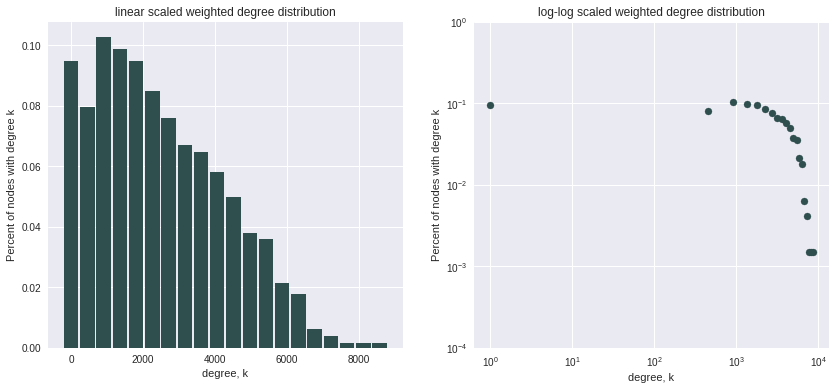

In [ ]:
degrees_weighted = sorted([w for (d, w) in G.degree(weight="weight")])

figs, axs = plt.subplots(1,2, figsize=(14,6))

n_bins = 20
count, bins = np.histogram(degrees_weighted, bins=n_bins)
xbins=bins[:len(bins)-1]
probs = count/sum(count)


axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_ylim(1e-4,1)

axs[0].bar(xbins, probs, 400, color="darkslategray")
axs[1].scatter(xbins, probs, color="darkslategray")

for i in range(2):
  axs[i].set_xlabel('degree, k')
  axs[i].set_ylabel('Percent of nodes with degree k')

axs[0].set_title("linear scaled weighted degree distribution")   
axs[1].set_title("log-log scaled weighted degree distribution")   

plt.show()

It appears in the plots that the weighted degree distribution is not very well described with a power-law distribution. In the linear scaled plot the percent of nodes with a certain degree seem to decrease linearly with the degree. Furthermore, the log-scaled plot shows that the degrees do not follow a straight line. However, neither does the distribution seem to indicate that the network is a random network. In *The weighted random graph model* (2009, Diego Garlaschelli) the results indicate that a weighted random network has a binomial distributed degree distribution, which does not seem to be the case for our network above. 

As many "real" networks follow a power-law distribution, one might have expected this network to do as well. However, the observed distribution suggests that a large portion of users have higher degree (more common subreddits) than "expected" if they followed a power-law distribution. This could be a result of what we previously observed - that there are some popular subreddits which many users subscribe to. This might (undesirely) connect a lot of users (weakly) in rather "non-informative" connections. Essentially, we hope to primarily link users who share a lot of subreddits. This challenge is further investigated in section 3.2.1.

Finally, the network is plotted using the ``ForceAtlas2`` module

In [ ]:
# Calculate position with the ForceAtlas2 algorithm
forceatlas2 = ForceAtlas2(outboundAttractionDistribution=True,  # Dissuade hubs
                          edgeWeightInfluence=1.0,
                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,
                          # Log
                          verbose=True)

pos = forceatlas2.forceatlas2_networkx_layout(G=G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [02:17<00:00, 14.59it/s]


BarnesHut Approximation  took  21.34  seconds
Repulsion forces  took  43.92  seconds
Gravitational forces  took  0.25  seconds
Attraction forces  took  67.48  seconds
AdjustSpeedAndApplyForces step  took  1.26  seconds


Now that positions are computed for each node, we color nodes according to their ``from_subreddit`` attribute and size them proportionally to their weighted degree

In [ ]:
# Make colors and node sizes for network
def node_size_and_colouring(network, color_trump, color_biden):
    color_map = []
    node_sizes = []


    for name in network.nodes:
        node_sizes.append((network.degree([name], weight="weight")[name]+1)/10)

        if network.nodes[name]['from_subreddit'] == 'trump':
            color_map.append(color_trump)
        elif network.nodes[name]['from_subreddit'] == 'biden':
            color_map.append(color_biden)
        else:
            print("Error")
    return color_map, node_sizes

color_map, node_sizes = node_size_and_colouring(G, "crimson", "royalblue")

And finally we plot the network. Red nodes are Trump users and blue nodes are Biden users

In [ ]:
fig = plt.figure(figsize=(12, 8))
# We plot twice to make edges more transparent than nodes. 
nx.drawing.nx_pylab.draw(G, pos=pos, node_color=color_map, node_size=node_sizes, with_labels=False, edge_color='white', alpha=.6)
nx.drawing.nx_pylab.draw(G, pos=pos, node_color=color_map, node_size=node_sizes, with_labels=False, edge_color='black', alpha=.01)
plt.title("Weighted network")
t_patch = mpatches.Patch(color="crimson", label="Trump")
b_patch = mpatches.Patch(color="royalblue", label="Biden")
plt.legend(handles=[t_patch, b_patch], loc="best", fontsize="15")

plt.show()

As previous mentioned, force directed layout algorithms produces plots where densely connected nodes generally are positioned closer to each other, and less connected nodes farther away. Thus, that the plot above roughly reveals two group of users mean that there is a tendency that Trump users generally share the same subreddits, and vice versa with the Biden users. In the paper which the``ForceAtlas2`` implementation is based on, it is mentioned that these kind of algorithms visualize community structures in accordance with the modularity measure (2014, Mathieu Jacomy, et al.). Whether there is an actual community structure is further examined in section 3.2.2

## 3.2 Extracting networks of interest and classifying users

### 3.2.1 Extracting the "backbone" of the user network


#### 3.2.1.1 Motive

We saw in section 3.1.3 that the weighted network was very dense. With such an overwhelming number of connections there will arguably be a lot of redundant information (2009, M. Ángeles Serrano, et al - 6483). 

Therefore it would be a good idea to attempt to reduce the complexity of the network while preserving the key features and information contained in the network. This can be seen as a network science analogy to performing principal component analysis on very high dimensional feature spaces known from machine learning. 

One immediate idea could be to preserve links having a certain weight and stripping links under this threshold from the network. However this kind of global thresholding would mean that we simply lose the information of the links with a weight under the somewhat arbitrary global threshold value (2009, M. Ángeles Serrano, et al - 6483).

A way to reduce the complexity in a more careful way is presented in the article *Extracting the multiscale backbone of complex weighted networks* (2009, M. Ángeles Serrano, et al). The core idea is to preserve the edges that are statistically significant for the network model in relation to a null hypothesis model where the weights are randomly uniform. A more detailed explanation will be provided in the following subsection. 





#### 3.2.1.2 Tools
We want to develop a so-called disparity filter to use as a tool for the complexity reduction. To develop this tool, the first thing needed is a way to let each node $i$ in the network assign a relative importance $p$ to its links:

$$
p_{ij} = \frac{w_{ij}}{\sum_j w_{ij}} \quad \text{for} \quad i \in I
$$

Thus for each link $j$ that a node has the formula above expresses the proportion of the nodes total weight that link $j$ carries. This allows us to express the level of local heterogenity or disparity in link weights (2009, M. Ángeles Serrano, et a, 6484). The next step is to consider what the disparity for a nodes weights should be expected to look like if the normalized weights $p_{ij}$ were placed uniformly random between 0 and 1. This means our null hypothesis is:

$$
\mathbf{H_0}: \text{For a node i with degree k,} \quad p_{ij} \sim U(0,1)
$$

Now we can take a certain node with degree $k$. Then we place $k-1$ points in the interval $[0,1]$ with uniform probability. 

The lengths of the resulting subintervals can be seen as $p_{ij}$. They will represent the expected values of the $k$ normalized weights if they were randomly drawn from a uniform distribution (2009, M. Ángeles Serrano, et a, et al, 6484).

The probability distribution function for one of the values $p_{ij}$ taking a specific value $x$ is given by:

$$
p(x)dx = (k-1)(1-x)^{k-2}dx  \quad \text{(2009, M. Ángeles Serrano, et al, eq. 1)}
$$

It can be seen that this probability is dependent on the degree of the node in question. For example, for a node with two links, $k=2$ it can be seen that $p(x)dx=1dx$, which means that the single point dividing the interval into two lengths has uniform probability in the interval. 

For each node $i$ with links $j \in J$ this means, if the null hypothesis, $\mathbf{H_0}$ is true, that the probability of observing a normalized weight with a value as extreme or more extreme than $p_{ij}$ can be calculated by:

$$
\alpha_{ij} = 1 - (k-1)\int_0^{p_{ij}}(1-x)^{k-2}dx \quad \text{(2009, M. Ángeles Serrano, et al, eq. 2)} 
$$

A certain $p$ or $\alpha$-value can then be set to form a criterion for when a link is significant. This means a link $j$ is significant if 

$$
\alpha_{ij} < \alpha
$$

Again to provide a simple example with node degree $k=2$, it can be seen that the calculation of $\alpha_{ij}$ simplifies to $\alpha_{ij} = 1 - p_{ij}$. When $p_{ij}$ is close to 1, then link $j$ carries a lot of the total weight of the links connecting to node $i$ and so it should be an important link for node $i$. This is reflected by $\alpha_{ij}$ which is consequently close to zero, meaning that it would be statistically significant to some level $\alpha$.   

The function `disparity_filter` below implements the calculation of $\alpha$-values for every link weight for every node in $G$ and rebuilds $G$ with an additional edge attribute containing the $\alpha$-value:

In [ ]:
def disparity_filter(G):
    """
    References:
    python-backbone-network, https://github.com/aekpalakorn/python-backbone-network
    M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    """
    Gdf = nx.Graph()
    for idx, i in enumerate(G):
        if (idx + 1) % 500 == 0:
            print(f"Node {idx+1} of {len(G)}")

        # Node degree
        k = len(G[i])

        # Save node with attribute
        Gdf.add_node(i, from_subreddit=G.nodes[i]["from_subreddit"])

        if k > 1: # (Serrano 2009, footnote, p. 6485)
            
            # Node strength:
            s_i = sum( G[i][j]["weight"] for j in G[i])
            
            for j in G[i]:

                # Disparity Filtering
                w_ij= G[i][j]["weight"]
                p_ij = w_ij / s_i 
                alpha_ij = 1 - (k-1) * scipy.integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]

                # Save neighbor node with attribute
                Gdf.add_node(j, from_subreddit=G.nodes[j]["from_subreddit"])

                # Saving edge with alpha-value
                Gdf.add_edge(i, j, common_subreddits=G[i][j]["common_subreddits"], weight=w_ij, alpha=alpha_ij)

    return Gdf

With the $\alpha$-values in place the function `alpha_cut` rebuilds G with only significant nodes. Note that the `try`-`except` statement is due to the fact that the $\alpha$-values are only assigned for nodes with a degree larger than 1. 

This is in turn due to a slight technicality of the algorithm. If a node $i$ with degree $k_i = 1$ is connected to a node $j$ of degree $k_j > 1$, then the significance of the link is determined from the threshold on node $j$ (2009, M. Ángeles Serrano, et al, 6485, footnote *) which is implemented above as simply not performing a the $\alpha$-value calculation for nodes with degree 1, thus it is possible that a node does not have the `alpha`-attribute. If a node $i$ does not have the `alpha`-attribute, the value of the node $i$ alpha is set to 1, which means that the link will fail the significance test and its fate will then depend on the threshold of connected node $j$.

In [ ]:
def alpha_cut(G, alpha_level=0.05):
    """
    python-backbone-network, https://github.com/aekpalakorn/python-backbone-network
    M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    """
    D = nx.Graph()
    for u, v, attributes in G.edges.data(data=True):
        try:
            alpha = attributes["alpha"]
        except KeyError:
            alpha = 1
        
        if alpha < alpha_level:
            D.add_node(u, from_subreddit=G.nodes[u]["from_subreddit"])
            D.add_node(v, from_subreddit=G.nodes[v]["from_subreddit"])
            cs = attributes["common_subreddits"]
            w = attributes["weight"]
            D.add_edge(u,v, common_subreddits=cs, weight=w)
    return D

In [ ]:
path = "/content/G_weighted_T_B_removed.gpickle"
G = nx.read_gpickle(path)

Ntot = len(G.nodes)
Ltot = len(G.edges)
Wtot = sum([weight for u,v,weight in G.edges.data(data="weight")])


The authors argue that this method will work best if their is a heigh level of weight heterogeneity at both a global and local scale (2009, M. Ángeles Serrano, et al, 6487). On the global level this would mean that the weights present in the network takes a lot of different values. On the local level the following measure of heterogeneity can be applied on each node $i$:

$$
kY_i(k) = k \sum_j p_{ij}^2 \quad \text{(2009, M. Ángeles Serrano, et al, eq. 3)}
$$

In the equation above it can be seen that if the weights of a node are perfectly homogeneous, then all the normalized weights $p_{ij}$ are equal and $kY_i(k) = 1$. 

This indicates why the method will node work in a network thats too high a degree of homogeneity: It will be increasingly difficult to set a significance level that will be able to actually remove links. 

Conversely, in the case of perfect heterogeneity where only one $p_{ij} = 1$ meaning that this weight accounts for all the weight, then $kY_i(k) = k$. 

The function `local_heterogeneity` below implements equation 3:

In [ ]:
def local_heterogeneity(G):
    nodes_by_ascending_degree = sorted(G.degree, key=lambda x: x[1], reverse=False)
    upsilon = []
    degrees = []
    for tup in nodes_by_ascending_degree:
        i = tup[0]
        k = tup[1]
        degrees.append(k)

        # Calculate sum of weights of incident edges
        s_i = sum(G[i][j]["weight"] for j in G[i])

        # Calculate square on each normalized weight
        pij_sq = [ (G[i][j]["weight"] / s_i)**2 for j in G[i]]

        # Sum of the squares:
        sum_pij_sq = sum(pij_sq)

        # Upsilon(i, k)
        upsilon.append( k * sum_pij_sq )
    
    return upsilon, degrees

#### 3.2.1.3 Results and discussion

First we will asses both the global distribution of weights and the local level of heterogeneity in the following plots:

In [ ]:
weights = []
for u, v, weight in G.edges.data(data="weight"):
  weights.append(weight)

upsilon, degrees = local_heterogeneity(G)

In [ ]:
n_bins = 17
weight_counts, bins = np.histogram(weights, bins=n_bins)
xbins=bins[:len(bins)-1]
wprobs = weight_counts / sum(weight_counts)

In [ ]:
plt.style.use("seaborn")
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
ax0.bar(xbins, wprobs, color="darkslategray")
ax0.set_xticks(list(set(weights)))
ax0.set_title("Weight probability distribution")
ax0.set_xlabel("$w$")
ax0.set_ylabel("$P(w)$")
ax1.plot(degrees, degrees, color="darkslategray")
ax1.plot(degrees, np.ones(len(degrees)), color="deepskyblue")
ax1.plot(degrees, upsilon, color="darksalmon", alpha=0.5)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title("Local weight heterogeneity")
ax1.set_xlabel("$\log k$")
ax1.set_ylabel("$\log kY_i(k)$")
ax1.legend(["Perfect heterogeneity", "Perfect homogeneity", "Empirical heterogeneity"])
fig.show()

From the global weight probability distribution, it can se seen that almost the entire probability mass is placed for weights less than 6. This means that on a global level the weights are not very heterogeneous as most weights are small. 

From the plot of the local weight heterogeneity, it can be seen that the local heterogeneity is also relatively small. 
However it can be seen that the heterogeneity seems to increase for nodes that have a high degree. This means that we will be able to apply the method with some success if we use relatively small values of $\alpha$.

Also it will likely mean that the most removal of links will happen at nodes that have a high degree, because the heterogeneity is generally highest in these regions of the network. 

Next we will need to consider at which significance level we should perform the removal of links. To this end we can look at the fraction of preserved nodes $N_B / N_{TOT}$ as a function of the fraction of preserved links $L_B / L_{TOT}$ and as a function of the fraction of preserved weight $W_B / W_{TOT}$. 

First the network is filtered with the disparity filter, assigning an $\alpha$-value to all the links in $G$:

In [ ]:
Gdf = disparity_filter(G)

Node 500 of 2697
Node 1000 of 2697
Node 1500 of 2697
Node 2000 of 2697
Node 2500 of 2697


In the following `for`-loop we will perform a search through 50 $\alpha$-values in the range $[0.01, 0.5]$. In each iteration the function `alpha_cut` builds a new graph only containing links that are significant. 

In [ ]:
# Authors recommend alpha values in range [0.01, 0.5]
alpha_levels = np.arange(0.01, 0.51, 0.01)

xvals_edgefraction = []
xvals_weightfraction = []
yvals_nodefraction = []
for alpha_level in alpha_levels:
    B = alpha_cut(Gdf, alpha_level=alpha_level)

    # Nodes and links preserved
    Nb = len(B.nodes)
    Lb = len(B.edges)

    # Weight preserved
    Wb = sum([weight for u,v,weight in B.edges.data(data="weight")])

    xvals_edgefraction.append(Lb / Ltot)
    xvals_weightfraction.append(Wb / Wtot)
    yvals_nodefraction.append(Nb / Ntot)

The lists holding the values will be plotted shortly. Before that we define the function `global_threshold` which implements the immediate approach mentioned above. The function `global_threshold` creates a new graph from $G$ that only contains the nodes connected by links carrying weights over a given global threshold value. 

In [ ]:
def global_threshold(G, threshold):
    GT = nx.Graph()
    for u,v,weight in G.edges.data(data="weight"):
        if weight >= threshold:
            GT.add_edge(u,v, weight=weight)
    return GT

Above we increased the $\alpha$-values gradually decreasing the level of statistical significance and consequently allowing more links to stay in the network. For the global threshold we instead decrease the global threshold from the maximum weight 17 in the network to a threshold of 1 which means that we gradually allow more links: 

In [ ]:
max_weight = max([weight for u,v,weight in G.edges.data(data="weight")])
xvals_GT_edgefraction = []
xvals_GT_weightfraction = []
yvals_GT_nodefraction = []

for threshold in np.linspace(max_weight, 1, 50):
    GT = global_threshold(G, threshold=threshold)

    # Nodes and links preserved
    Ngt = len(GT.nodes)
    Lgt = len(GT.edges)

    # Weight preserved
    Wgt = sum([weight for u,v,weight in GT.edges.data(data="weight")])

    xvals_GT_edgefraction.append(Lgt / Ltot)
    xvals_GT_weightfraction.append(Wgt / Wtot)
    yvals_GT_nodefraction.append(Ngt / Ntot)

Now everything is in place to create the plots:

In [ ]:
plt.style.use("seaborn")
ys = [yvals_nodefraction, yvals_GT_nodefraction]
xs = [xvals_edgefraction,xvals_weightfraction, xvals_GT_edgefraction, xvals_GT_weightfraction]

meth_0 = "Disparity filter"
meth_1 = "Global threshold"
desc_0 = "Fraction of nodes preserved as function of fraction of links preserved"
desc_1 = "Fraction of nodes preserved as function of fraction of weight preserved"
ylabel = "$N_p \quad / \quad N_{TOT}$"
xlabels = ["$L_p \quad / \quad L_{TOT}$", "$W_p \quad / \quad W_{TOT}$"]
m = [meth_0, meth_1]
d = [desc_0, desc_1]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)

for idx, ax in enumerate(axes):
  ax.plot(xs[idx], ys[0],color="darkslategray", label=meth_0)
  ax.plot(xs[idx+2], ys[1], "--", color="darksalmon", label=meth_1)
  ax.set_xlim(-0.025, max(xs[0]))
  ax.set_title(d[idx])
  ax.set_ylabel(ylabel)
  ax.set_xlabel(xlabels[idx])
  ax.legend()

fig.suptitle("Complexity reduction with different filterings", fontsize=15)
fig.show()

From the plots it can be seen that we are able to greatly decrease the number of links and consequently a large amount of weight while keeping a lot of the nodes. Also it can be seen that the disparity filter is able to preserve a higher fraction of nodes with lower fractions of links and weights. This means that it is a worthwhile choice to use the disparity filter instead of the simple global thresholding filter as we clearly keep more information with fewer links. 

From dimensionality reduction techniques such as principal component analysis it is customary to look at so-called scree plots to decide on a number of features that to some extent explains most of the variance in a data set. This would mean to select the number of features that gives rise to the steepest slopes in the fraction of variance explained by including them as most information is held in these features.  

If we follow this intuition and apply it to the present case of network analysis, it seems like a good choice to select an $\alpha$-value that gives us the most nodes for the cost of least links as this will preserve the most information and the least redundant links.

Upon visual inspection of the plots it seems that an $\alpha$-value of around 0.09 will preserve around 85 \% of the nodes while retaining only around 2.5 \% of the links. Therefore we choose $\alpha = 0.09$ to perform the $\alpha$-cut on $G$, hence creating our backbone network $B$:

In [ ]:
B = alpha_cut(Gdf, alpha_level=0.09)
print("Fraction of nodes preserved:", len(B.nodes)/Ntot)
print("Fraction of links preserved:", len(B.edges)/Ltot)

Fraction of nodes preserved: 0.8694846125324435
Fraction of links preserved: 0.024555047570639494


The basic statistics of the resulting weighted network $B$ is presented below in comparison with the original weighted network $G$ which was first presented in section 3.1.3.3. 

In [ ]:
CCs = list(nx.connected_components(G))
nodes_of_LC = (max(CCs, key=len))
G = G.subgraph(nodes_of_LC).copy()

Bdegw = [d for user, d in B.degree(weight="weight")]
Gdegw = [d for user, d in G.degree(weight="weight")]

def avg_weight(network):
  return round(np.mean([w for u, v, w in network.edges(data="weight")]), 2)


df_stats = pd.DataFrame({'N':[len(G.nodes), len(B.nodes)],
                         'L':[len(G.edges), len(B.edges)],
                         'Min degree':[np.min(Gdegw), np.min(Bdegw)],
                         'Max degree':[np.max(Gdegw), np.max(Bdegw)],
                         'Median degree':[int(np.median(Gdegw)), int(np.median(Bdegw))],
                         'Mode':[Counter(Gdegw).most_common(1)[0][0], Counter(Bdegw).most_common(1)[0][0]],
                         'Avg weight':[avg_weight(G),avg_weight(B)],
                         '⟨k⟩':[int(round(np.mean(Gdegw), 0)), int(round(np.mean(Bdegw),0))]
                         }, index=["G", "B"])

df_stats

N        L  Min degree  Max degree  Median degree  Mode  Avg weight   ⟨k⟩
G  2669  1849355           1        9022           2393  1022        1.94  2690
B  2345    45411           3        4592            107     3        5.91   229

The most notable change is the reduction by a factor of 40 of the links in the network. Along with this change there are several other things to notice in the table above:

1.   The minimum degree has shifted to a value of 3 which means that the user with least subreddits/interests in common with other user's now has three such interests.


2.   There has been a shift in the other direction for the maximum degree where it can be seen that the maximum degree is approximately halved. This is likely because many of the links which was removed was highly popular subreddits which linked many users with a superficial low weight and accordingly a lot of these connections is lost for the most connected node. 

3. The reasoning from point 2 is probably also the reason why the average weighted degree has gone from 2690 to 229. 

These effects is considered positive as the network can now be seen as more focused with regards to spotting interest communities in the network. 

In this way, point 1 can be seen as a "lower bound" for how weak or shallow connections between users we now consider. Meanwhile point 2 and 3 can be interpreted as removing a lot of noise from the very connected nodes and the remaining nodes in general. Noise in this respect will be that some subreddits like general advice subreddits and news subreddits are very common interests, so by their exclusion by the filtering we don't lose too much information.  

Also:

4. We see that the average weight of the remaining links has increased, meaning that the reduction in links must have happened mainly on links with relatively low weights in the network. 

As this is the first indication that confirms the assumptions in the reasoning of this section, we want to back it up by exploring which links were removed. Consider the following bar plots, where the distributions of respectively the weights removed the weights that were kept by `alpha_cut` are shown:




In [ ]:
def about_alpha_cut(G, alpha_level=0.05):
    cut_weight = []
    cut_reddit = []
    cut_red_append = []

    stay_weight = []
    stay_reddit = []
    for idx, (u, v, attributes) in enumerate(G.edges.data(data=True)):
        try:
            alpha = attributes["alpha"]
        except KeyError:
            alpha = 1
        if alpha < alpha_level:
            stay_weight.append(attributes["weight"])
            stay_reddit += attributes["common_subreddits"]
        elif alpha >= alpha_level:
            cut_weight.append(attributes["weight"])
            cut_reddit += attributes["common_subreddits"]
            cut_red_append.append(attributes["common_subreddits"])

    return cut_weight, cut_reddit, cut_red_append, stay_weight, stay_reddit

cw, cr, cra, sw, sr = about_alpha_cut(Gdf, alpha_level=0.09)

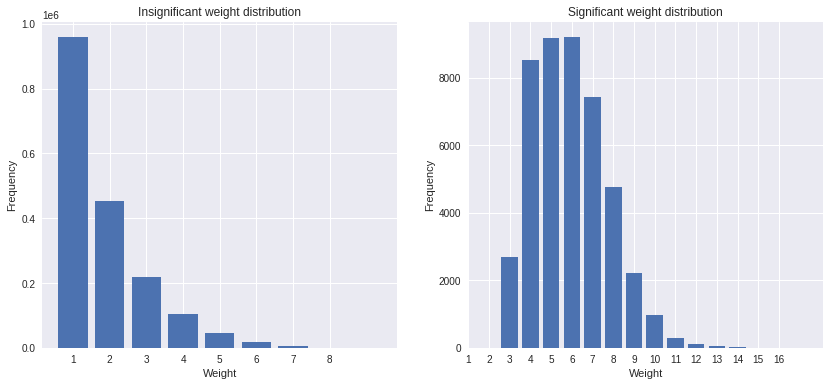

In [ ]:
def discrete_bar(weight_list):
  counter = Counter(weight_list)
  bins = [k for k in counter.keys()]
  counts = [v for v in counter.values()]
  return [bins, counts] 

bc = [discrete_bar(cw), discrete_bar(sw)]
titles = ["Insignificant weight distribution", "Significant weight distribution"]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
for idx, ax in enumerate(ax):
  ax.bar(bc[idx][0], bc[idx][1])
  ax.set_title(titles[idx])
  ax.set_ylabel("Frequency")
  ax.set_xlabel("Weight")
  ax.set_xticks([x for x in range(1, max(bc[idx][0]))])


We see that almost a million of the insignificant links that were removed was links with a weight of 1. Also it can be see that the significant weights looks almost Poisson distributed around the mean of $\approx 6$ and it can be noticed that there are simply no weights less than 3 among the significant weights. 

In the code-block below we will consider which subreddits appeared most commonly in respectively insignificant and significant links:

In [ ]:
counter_cr = Counter(cr)
counter_sr = Counter(sr)
print("Most common subreddits at insignificant links: ")
print(counter_cr.most_common(10))
print("\n Most common subreddits at significant links: ")
print(counter_sr.most_common(10))

Most common subreddits at insignificant links: 
[('Ask Reddit...', 523921), ('Politics', 507271), ('All news, US and international.', 210530), ('Reddit Pics', 171405), ('World News', 162303), ('Conservative', 145589), ('funny', 118307), ('Today I Learned (TIL)', 97162), ('/r/PublicFreakout', 89264), ('A subreddit for cute and cuddly pictures', 55940)]

 Most common subreddits at significant links: 
[('Ask Reddit...', 22614), ('Politics', 15482), ('Reddit Pics', 14950), ('All news, US and international.', 14255), ('World News', 12633), ('funny', 11488), ('Today I Learned (TIL)', 10718), ('/r/PublicFreakout', 7316), ('.gifs - funny, animated gifs for your viewing pleasure', 5573), ('/r/videos', 5147)]


It can clearly be seen that the most common subreddits at insignificant links are very general and broadly appealing subreddits like "Ask Reddit", "Polictics" and "World News" as we expected a few text blocks above. 

There is however also the subreddit "Conservative" which name indicates that it may not be for everyone. Since an overwhelming amount of the removed links had weight 1, there is a fair probability that the links holding this subreddit connected Trump-minded people on a superficial level. However, had we discovered a bond between Trump users and American conservatism this may not have been too informative regardless. 

Meanwhile it can be seen that this is also the case for the significant links and the two lists are almost identical. This will be considered to be a positive observation as the network can be seen to have preserved a distinctive quality after the disparity filtering, namely that the popular subreddits should be popular.

In [ ]:
def subreddit_cut_with_weight(cutweights, cutreddits, pattern, weights):
    count = 0
    for idx, w in enumerate(cutweights):
        if w in weights:
            for elem in cutreddits[idx]:
                if pattern in elem:
                    count += 1

    return count

ar = subreddit_cut_with_weight(cw, cra, "Ask Reddit", [1])
an = subreddit_cut_with_weight(cw,cra, "All news, US and international.", [1])
cn = subreddit_cut_with_weight(cw, cra, "Politics", [1])

print(f"r/Ask Reddit   removed in links with weight 1: {ar}")
print(f"r/All news, US and international removed in links with weight 1: {an}")
print(f"r/Politics removed in links with weight 1: {cn} \n")
print(f"Fraction of removals accounted for: {(ar+an+cn)/(len(G.edges)-len(B.edges))}")

r/Ask Reddit   removed in links with weight 1: 185013
r/All news, US and international removed in links with weight 1: 38235
r/Politics removed in links with weight 1: 220803 

Fraction of removals accounted for: 0.24615564562979783


The code block above counts the number of times certain very general subreddits has been removed as a shallow connection of weight 1 and these removals can be seen to account for about 25 \% of the total links removals. Thus this also seems to support what we expected from looking at the basic statistics of the filtered network. 

Next we can consider the resulting weighted degree distribution for $B$. It turns out that it is a whole other picture than what we observed in section 3.1.4.3:

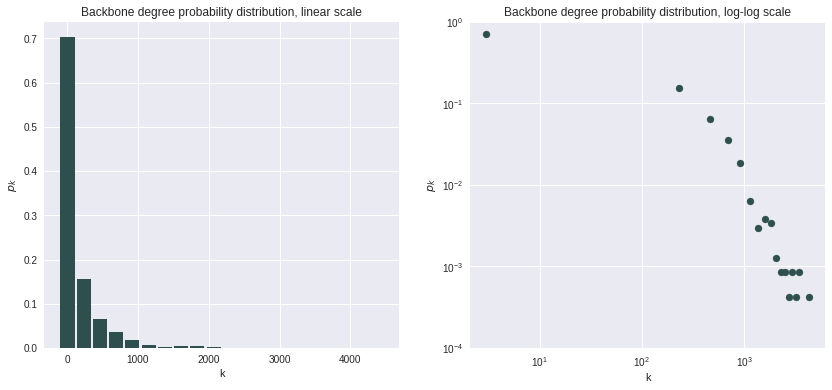

In [ ]:
n_bins = 20
count, bins = np.histogram(Bdegw, bins=n_bins)
xbins=bins[:len(bins)-1]
probs = count/sum(count)

fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_ylim(1e-4,1)
ax[0].bar(xbins, probs, 200, color="darkslategray")
ax[1].scatter(xbins, probs, color="darkslategray")
ax[0].set_title("Backbone degree probability distribution, linear scale")
ax[1].set_title("Backbone degree probability distribution, log-log scale")

for a in ax:
  a.set_xlabel("k")
  a.set_ylabel(r"$p_k$")

fig.show()

From the degree distribution on both the linear and the log-log-scale it seems that the resulting weighted degree distribution appears to look like a scale-free network which can be seen as the distributions appears to follow a power-law distribution. 

On the linear scale it is seen clearly that the vast majority of nodes have a low weighted degree and there are some heavily connected hubs. From the log-log-plot a power-law distribution and consequently a scale-free degree distrubution will appear as a straight line (Barabasi, 4.2) which to some extend seems to be the case here.  

Using the Python library `powerlaw` we can find the best power-law fit to our degree distribution and report the degree exponent $\gamma$:

In [ ]:
fit = powerlaw.Fit(Bdegw)

In [ ]:
gamma = fit.alpha
print(f"Degree exponent: {gamma} \n")

Degree exponent: 3.22228659621171 



The degree exponent $\gamma$ is found to be $\gamma \approx 3.2$. This places the degree distribution just over the critical point for being in a scale-free regime and it would be practically impossible to distinguish the properties of our network from the properties of a random network. This means that we cannot document that our network in fact has a scale-free nature (Barabasi, 4.7). 

To conclude this section we will now illustrate network $B$ with the ForceAtlas2 algorithm:

In [ ]:
# Calculate position with the ForceAtlas2 algorithm
forceatlas2 = ForceAtlas2(outboundAttractionDistribution=True, # Dissuade hubs
  edgeWeightInfluence=1.0,
  # Performance
  jitterTolerance=1.0, # Tolerance
  barnesHutOptimize=True,
  barnesHutTheta=1.2,
  # Tuning
  scalingRatio=2.0,
  strongGravityMode=False,
  gravity=1.0,
  # Log
  verbose=True)
pos = forceatlas2.forceatlas2_networkx_layout(G=B, pos=None, iterations=2000)

100%|██████████| 2000/2000 [01:27<00:00, 22.82it/s]

BarnesHut Approximation  took  23.22  seconds
Repulsion forces  took  58.98  seconds
Gravitational forces  took  0.29  seconds
Attraction forces  took  1.85  seconds
AdjustSpeedAndApplyForces step  took  1.13  seconds


In [ ]:
# Make colors and node sizes for network
def node_size_and_colouring(network, color_trump, color_biden):
  color_map = []
  node_sizes = []
  for name in network.nodes:
    node_sizes.append((network.degree([name], weight="weight")[name]+1)/5)
    if network.nodes[name]['from_subreddit'] == 'trump':
      color_map.append(color_trump)
    elif network.nodes[name]['from_subreddit'] == 'biden':
      color_map.append(color_biden)
    else:
      print("Error")
  return color_map, node_sizes

color_map, node_sizes = node_size_and_colouring(B, "crimson", "royalblue")

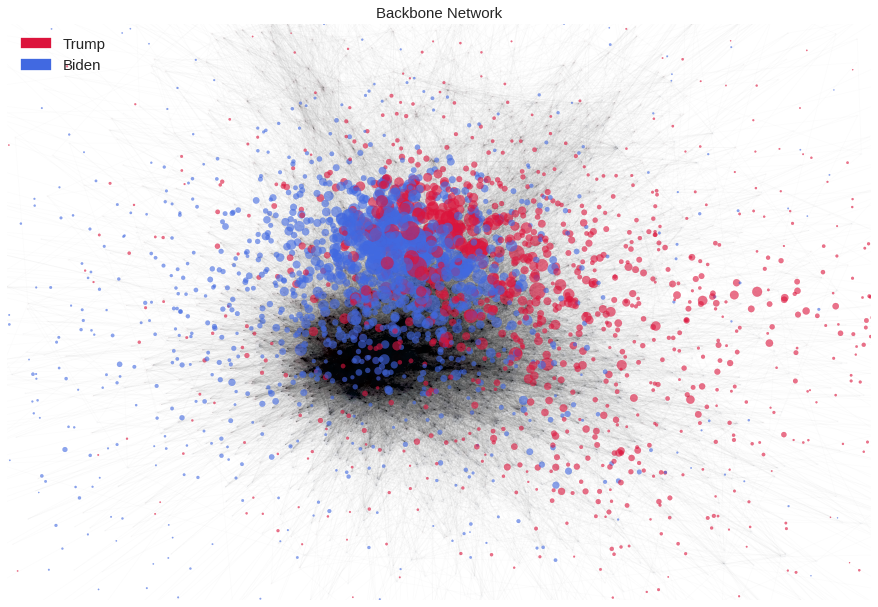

In [ ]:
fig = plt.figure(figsize=(12, 8))
nx.drawing.nx_pylab.draw(B, node_color=color_map, node_size=node_sizes, with_labels=False, edge_color="white", alpha=.6)
nx.drawing.nx_pylab.draw(B, node_color=color_map, node_size=node_sizes, with_labels=False, edge_color="black", alpha=.01)
plt.title("Backbone Network", fontsize=15)
t_patch = mpatches.Patch(color="crimson", label="Trump")
b_patch = mpatches.Patch(color="royalblue", label="Biden")
plt.legend(handles=[t_patch, b_patch], loc="best", fontsize=15)
plt.ylim((-0.05, 0.05))
plt.xlim((-0.05, 0.05))
plt.show()

From the network illustration it can be seen that there seem to be a tendency that the the blue Biden nodes cluster to the left in the plot while the red Trump nodes cluster to the right in the plot. As previously described, this structure in force-directed plot algorithms suggests that we should be able to make some differentiating among the users when considering this way of classifying our users. 

### 3.2.2 Classifying users with community Detection and sentiment analysis

#### 3.2.2.1 Motive

This section is about how to approach the network in terms of partitioning. The immediate intention of this project was to investigate differences and simmiliarities across cadidate supporters on reddit. However this approach presumes that users posting comments on a candidate subreddit do in fact support the cadidate. This might be an naiv assumption and could lead to faulty conlclusions. Instead different partitionings of the graph is investigated, to detect significant structures within the network and check whether these partitionings corralate with the users from_subreddit attribute. The aim is to reviel the validity of partitioning the network in two groups (or communities) of candidate supporters and whether to talk about *supporters* as such is misleading in this context or not.



#### 3.2.2.2 Tools

**Modularity scores to detect community structures**

To validate the different partitionings of the network modularity is used. Modularity is a score that ranges from $[-\frac{1}{2}\  ; 1]$ and compares the *wiring* within communities with wiring across communities. The higher score the higher density within communities and lower wiring across the partitioned communities. Modularity for a partitioning of $n_c$ communities is calculated by:


$$M_{c}=\sum_{c=1}^{n_c}\left[ \frac{L_c}{L}- \left( \frac{k_c}{2L} \right) ^2 \right]$$

\\
With $L_c$ being links within the community $C_c$ and $k_c$ being the total degree the nodes in the community.

In *Fast algorithm for detecting community structure in networks* (2003, M. E. J. Newman) it is stated that a modularity differing from 0 indicates a deviation from randomness, but that a score on above 0.3 typically implies a significant community structure in a network.





**Louvain for optimal partitioning**

Louvain algorithm is used to identify "the best" community partitioning in the graph. The algorithm belongs to the class of modularity maximization algorithms for community detection. Thus our search for community structure is following hypothesis H4 (Barabasi, section 9.4), namely that the partition of maximal modularity corresponds to the optimal community structure. 

According to *Fast unfolding of communities in large networks* (Blondel et. alia 2008), the algorithm works in two phases that repeats iteratively:

***Phase one***: Each node $i$ in a network of $N$ nodes is divided into a community for each node. Then for each neighbor $j$ of $i$, the algorithm calculates the gain in modularity $\Delta Q$ that would be achived by placing $i$ in $j$'s community $C$. This gain is calculated by 

$$
\Delta Q = \big[ \frac{\sum_{in}+k_{i,in}}{2m} - (\frac{\sum_{tot}+k_{i}}{2m})^2 \big] - \big[ \frac{\sum_{in}}{2m} - (\frac{\sum_{tot}}{2m})^2 - (\frac{k_i}{2m})^2  \big], 
$$

where $\sum_{in}$ is the sum of the weights of the links inside $C$, $\sum_{tot}$ is the sum of the weights of the links incident to nodes (i.e. links that share a node) in $C$, $k_i$ is the sum of the weights of the links incident to node $i$, $k_{i,in}$ is the sum of the weights of the links from $i$ to nodes in $C$ and finally $m$ is the sum of the weights of all the links in the network. If there is no positive gain in modularity, $i$ stays in its community. This goes on until there are no more movements of nodes to communites that would yield a positive gain in modularity.

***Phase two***:
The second phase consists in building a new network where the nodes are the communities found in phase one. The weights of the links between the nodes (former communities) in the new network are given by summing up the weights of the links between nodes in the two former communities. After the new network has been created phase one can be reapplied. The algorithm terminates when there are no more positive gain achieved to the modularity of the network. (Heshe, Græsholt & Tommerup, assignment 2). 

**Subreddit Frequency**

Looking at the frequency of commented subreddits for users within communities will give an insight of how the communities have been partitioned and reveal characteristics of the communities. 

**Sentiment analysis for alternative classification** 

Lastly community partitioning through setiment analysis is investigated. With ``from_subreddit`` being a more neutral attribute and the sentiment of each comment being the crucial indicator. To store sentiment for every comment, data on the sentiment of words is required. For this purpose, the [LabMT wordlist](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) is used. This data contains a long list of words with a corresponding happiness score (happiness_average below). This sentiment score is computed as the average evaluation from 1-9 of 50 users on the webplatform Mechanical Turk (Heshe, Græsholt & Tommerup, assignment 2).

The partitioning of users based on sentiment analysis is done in the following way:

- Catagorizing users with ***positive comments***, containing a candidate name, as supporters of the ***same candidate***. 

- Catagorizing users with ***negative comments***, containing a candidate name, as supporters of the ***opposite candidate***. 

- Categorizing users with comments containing both or no candate names as ***either*** supporters of same ***or*** opposite candidate depending on origin of comment (i.e. ``from_subreddit``) and sentiment of comment (same as origin if positive and opposite of origin if negative)


#### 3.2.2.3 Results and discussion

By looking at the Modularity score for a partitioning of users based on subreddit, an estimate of seperation is found on reddit activity for the two groups.

In [ ]:
# Method to partition based on the 'from_subreddit' attribute
def node_to_partition(graph, partitions):
  ntp = {}
  for idx, partition in enumerate(partitions):
    nodes_in_partition = [node for node, data in graph.nodes(data=True) if data.get("from_subreddit")==partition]
    for node in nodes_in_partition:
      ntp[node] = idx
  return ntp

# partion B into trump and biden partitions
B_ntp = node_to_partition(B, ["trump", "biden"])

# Calculate modularity for the entire network on the trump/biden partitioning in B
B_modularity = community.modularity(B_ntp, B)

print(f"\n\nModularity for trump and biden partitioning on B: {B_modularity} \n")



Modularity for trump and biden partitioning on G: 0.09175437865283112 



This partitioning seems to deviate from randomness, but 0.09 is still too low to categorize this partitioning in subreddit commented as significant.

This finding does not imply that there are no community structures whatsoever. With the use of the Louvain algorithm a more optimal partitioning can be found in the network, to locate community structures regardless of commented subreddit - revealing shared interests for both groups.

In [ ]:
# Louvain used for community detection in B
B_partition = community.best_partition(B, random_state=0)

# Extract size of each community found by Louvain
def get_community_sizes(partition_dict):
  D = partition_dict
  communities = set(D.values())
  community_sizes = []
  for k in range(len(communities)):
    size = sum(map((k).__eq__, D.values()))
    community_sizes.append(size)
  return community_sizes

B_community_size = get_community_sizes(B_partition)

print(f"Number of communities found: {len(B_community_size)}")

Number of communities found: 6


To better understand the partitioning the communities are plotted in a bar plot with colours corresponding to the users ``from_subreddet`` attribute.

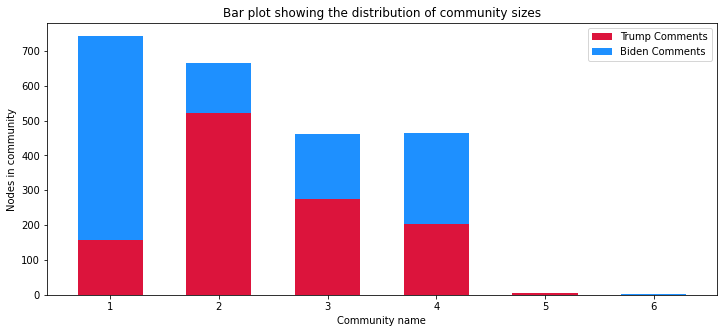

Sizes of communities: [743, 665, 461, 465, 4, 3]

Percentages for each community: 
 Trump comments: [0.21 0.78 0.59 0.43 1.   0.  ]
 Biden comments: [0.79 0.22 0.41 0.57 0.   1.  ]

Modularity for Louvain partitoning: 0.3169470769008109


In [ ]:
# Calculate numbers of trump subreddit comments in a community 
def candidateComments(community, B, partition, candidate):
  count = 0
  for node in B.nodes:
    if B.nodes[node]['from_subreddit'] == candidate and partition[node] == community:
      count = count + 1
  return count

# Make barplot collored according to candidate subreddit
def plotBarplot(trumps, bidens):
  index = np.arange(len(trumps))
  width = 0.6
  ticks = ('1', '2', '3', '4', '5', '6')

  # Generate Bar plots
  plt.figure(figsize=(12,5))
  p1 = plt.bar(index, trumps, width, color ='crimson')
  p2 = plt.bar(index, bidens, width, color ='dodgerblue', bottom=trumps)

  # Plot
  plt.title("Bar plot showing the distribution of community sizes")
  plt.xlabel("Community name")
  plt.ylabel("Nodes in community")
  plt.xticks(index, ticks[:len(trumps)])                                                           
  plt.legend((p1[0], p2[0]), ('Trump Comments','Biden Comments'))
  plt.show()


# Calculate numbers of candidate specific comments in each community 
B_trump_comments = np.array([candidateComments(i, B, B_partition, 'trump') for i in np.arange(len(B_community_size))])
B_biden_comments = np.array([candidateComments(i, B, B_partition, 'biden') for i in np.arange(len(B_community_size))])

plotBarplot(B_trump_comments, B_biden_comments)

print(f"Sizes of communities: {B_community_size}\n")
print(f"Percentages for each community: \n Trump comments: {np.round(B_trump_comments/B_community_size, 2)}\n Biden comments: {np.round(B_biden_comments/B_community_size,2)}" )
print(f"\nModularity for Louvain partitoning: {community.modularity(B_partition, B)}")

From this plot it seems that users in some of the communities found correlates with the commented candidate subreddit (community 1,2,5,6). Furthermore the modularity score is above the threshold 0.3, implying this partitioning has a significant community structure within the network. Looking into the frequency of subreddits commented in each community, the theory of candidate specific communities can be investigated.

In [ ]:
# Method to users in a community
def extractUsersFromCommunity(community):
  community_1 = []
  for user in df['user']:
    try:
      if B_partition[user] is community:
        community_1.append(user)
    except:
      continue
  return community_1

# Method to extract commented subreddits for each user in a community
def extractRedditsFromCommunity(community):
  subreddits = []
  reddit_counter = {}
  df_com = df.loc[df['user'].isin(community)].iloc[:, 2:4].copy()
  
  for subred in df_com['used_subreddits']:
    com1 = set(json.loads(subred))
    subreddits+=list(com1)
  
  community_TF_raw = nltk.FreqDist(subreddits)  #return popular_reddits, reddit_counter
  return community_TF_raw

# Put is all together and create a list frequency of 20 most commented subreddits for a community 
def redditFrequency(community_index):
  com = extractRedditsFromCommunity(extractUsersFromCommunity(community_index))
  com_list = [(v, k) for (v,k) in com.items() if v not in ["biden", "trump"]]
  sorted_RF = (sorted(com_list, key=lambda x: x[1], reverse=True)[:20])
  return sorted_RF

  # Create a Data Frame showing the frequency lists found for every community 
reddit_freqs = list(zip(redditFrequency(0),redditFrequency(1),redditFrequency(2),redditFrequency(3),redditFrequency(4),redditFrequency(5))) 
df_lol = pd.DataFrame(reddit_freqs, columns = ['Community 1','Community 2','Community 3','Community 4','Community 5','Community 6'])
df_lol



Community 1  ...                                        Community 6
0                                     (Politics, 566)  ...              (Breaking Mom - chocolate & whine, 3)
1              (All news, US and international., 302)  ...  (Reddit Parenting - For those with kids of any...
2                                   (World News, 268)  ...                           (BabyBumps Graduates, 2)
3                                (Ask Reddit..., 256)  ...              (Eating healthy on a cheap budget, 2)
4                            (/r/PublicFreakout, 174)  ...                                 (Relationships, 2)
5                 (Novel Coronavirus (COVID-19), 169)  ...                                          (Aldi, 1)
6   (2020 Political Hindsight - a Donald Trump lov...  ...                         (Female Fashion Advice, 1)
7                                  (Reddit Pics, 142)  ...                                (shittyfoodporn, 1)
8                         (White People Twitter, 125)  ...                                      (Delaware, 1)
9                        (Today I Learned (TIL), 121)  ...                                        (UNHhhh, 1)
10                    (The Ideological Trashcan, 113)  ...  (For cautious pregnant Mommas on this great pe...
11                   (Insane People on Facebook, 105)  ...         (Trying to Conceive (TTC) After a Loss, 1)
12         (A gallery of inexplicable stupidity, 101)  ...  (Stop MLM schemes from draining your friends d...
13                (Sadly, this is not the Onion., 97)  ...                                    (Baby Bumps, 1)
14                                        (funny, 76)  ...                                     (/r/videos, 1)
15   (I never thought leopards would eat MY face, 75)  ...                  (Dark Netflix Original Series, 1)
16                    (Movie News and Discussion, 73)  ...                            (RuPaul's Drag Race, 1)
17                          (Interesting As Fuck, 72)  ...            (Everything about the toddler years, 1)
18         (Democrats: Unite for a Better Future, 72)  ...                                  (One and Done, 1)
19                                      (atheism, 65)  ...                               (Game of Thrones, 1)

[20 rows x 6 columns]

Investigating the top 20 most commented subreddits within each community leeds to some interesting findings especially when comparing community 1 and 2 that have a majority of users commenting respectivly the Biden and Trump subreddit:

- Community 1 seems to have a bigger interest for World news than Comminty 2. 

- Community 1 has ``Novel Coronavirus (COVID-19)`` at 5th place, whereas in community 2 it is not present in the top 20.

- The "Conservative" subreddit is the top commented subreddit in Community 2 and is nowhere to be found in Community 1.

- Community 2 has "conspiracy" in 10th place unlike no other community

These are all things that could contribute to the thought of Community 1 and 2 being seperated based on political beliefs. The other communities seem to have more neutral characteristics like humorous (Community 3), exploratory (Community 4), gaming (Community 5) and parenting (Community 6). A funny thing to notice, despite the small numbers, is the strict seperation of community 5 and 6 in terms of candidate subreddit commented whereas users in community 3 and 4 is more evenly divided. 

Another thing to notice is the amount of subreddits appearing in different communities and their similiarities in numbers (e.g. ``Ask Redit...``). In a likely scenario were these subreddits are randomly distributed among users in the network this will work as a moderator for the modularity score, pushing it towards zero, since the edges contribution to the score is relative to the number of edges. Removing these "noisy" and more neutral subreddits would thereby increase the significance of already present community structures in terms of modularity.

##### Sentiment classification

Lastly a partitioning is carried out by looking at the sentiment score of each comment. The categorization is made using the criterias explained in tools. Here 5 is used as value turning point in terms of whether to classify comments as positive (sentiment score above 5) or negeative (sentiment score below 5).

In [ ]:
# Load labMT
LabMT = pd.read_csv("drive/MyDrive/SGAI/labmt-sentiment-data.txt", sep="\t")

# Set for fast look-ups
LabMT_words_sentiment = set(LabMT['word'].values)

# Dict for quickly accessing score
LabMT_hap_avg = {}
words = LabMT['word'].values
scores = LabMT['happiness_average'].values

for w,s in zip(words, scores):
    LabMT_hap_avg[w] = s 

# Method for retrieving average sentiment score on a list of tokens
def calc_sentiment_of_tokens(tokens, hap_avg, words):
    sentiment_of_text = 0
    n_avg = 0

    # Create the frequency distribution and loop through it
    fdist = nltk.FreqDist(tokens)
    for w, f in fdist.items():
        # Check if the token is a part of the LabMT list
        if w in words:
            # Compute the weighted sentiment of this token (according to how many times the word occurs)
            sentiment_of_text += hap_avg[w]*f
            # Only compute the average with respect to the words which are in the LabMT list
            n_avg+=1*f

    # return error (-1) if none of the words in 'tokens' exist in the LabMT list
    return sentiment_of_text/n_avg if n_avg>0 else -1

# Method to make partioning based on usernames
def users_to_partition(B, trump, biden):
  ntp = {}
  for node, data in G.nodes(data=True):
    if any(node in s for s in trump):
      ntp[node] = 0
    if any(node in s for s in biden):
      ntp[node] = 1
  return ntp

In [ ]:
# Categorizing users based on sentiment and mentioned candidate/from_subreddit attribute
biden = []; trump = []
count1 = 0; count2 = 0; count3 = 0; count4 = 0
avg_sentiment = 0
sentiment_threshold = 5
for i in np.arange(len(df)):
  comment_raw = re.findall(r"\w+(?:[-']*\w*)*", df['comment'][i])
  comment = [w.lower() for w in comment_raw]
  sentiment = calc_sentiment_of_tokens(comment, LabMT_hap_avg, words)
  avg_sentiment += sentiment

  # If both candidate mentioned
  if any("trump" in s for s in comment) and any("biden" in s for s in comment):
    count1 += 1 
    if df['from_subreddit'][i] == 'trump':
      if sentiment > sentiment_threshold:
        trump.append(df['user'][i])
      else:
        biden.append(df['user'][i])
    if df['from_subreddit'][i] == 'biden':
      if sentiment > sentiment_threshold:
        biden.append(df['user'][i])
      else:
        trump.append(df['user'][i])

  # If Trump mentioned
  elif any("trump" in s for s in comment):
    count2 += 1
    if sentiment > sentiment_threshold:
      trump.append(df['user'][i])
    else:
      biden.append(df['user'][i])

  # If Biden mentioned
  elif any("biden" in s for s in comment):
    count3 += 1
    if sentiment > sentiment_threshold:
      biden.append(df['user'][i])
    else:
      trump.append(df['user'][i])

  # If no candidate mentioned
  else:
    count4 += 1
    if df['from_subreddit'][i] == 'trump':
      if sentiment > sentiment_threshold:
        trump.append(df['user'][i])
      else:
        biden.append(df['user'][i])
    if df['from_subreddit'][i] == 'biden':
      if sentiment > sentiment_threshold:
        biden.append(df['user'][i])
      else:
        trump.append(df['user'][i])

avg_sentiment = avg_sentiment/len(df)

The basic stats for the classification is investigated as well as the modularity for the partitioning.

In [ ]:
# Create partioning based on users categorized through sentiment anlysis and calculate modularity
senti_partition = users_to_partition(B, trump,biden)
senti_modularity = community.modularity(senti_partition, B)

print(f"Average sentiment in comments: {avg_sentiment}")
print(f"Comments containing both candidate names: {count1}")
print(f"Comments containing only Trump: {count2}")
print(f"Comments containing only Biden: {count3}")
print(f"Commetns containing no candidate names: {count4}\n")
print(f"Users classified at Trump supporters: {len(trump)}")
print(f"Users classified at Biden supporters: {len(biden)}\n")
print(f"Modularity for partioning based on sentiment analysis: {senti_modularity}")

Average sentiment in comments: 5.321645121913993
Comments containing both candidate names: 115
Comments containing only Trump: 389
Comments containing only Biden: 185
Commetns containing no candidate names: 2008

Users classified at Trump supporters: 1382
Users classified at Biden supporters: 1315

Modularity for partioning based on sentiment analysis: 0.031346109401471534


The average of sentiment in comments on 5.3 shows that comments in general do not lean towards being very positive or negative but on average are pretty neutral. The number of comments containing candidate names costitute only approximately 25% of the total number of comment, meaning the majority of comments is categorized through sentiment and origin of subreddit commented. The Users are evenly split between candidates which looks promising, but the modularity score for this partioning on 0.03 (the worst yet found) indicates that this categorization isn't that meaningful. 

Above, several partitions of the network into candidate supporters have been attempted. The modularity diviades from zero in all cases but only by using Louvains algorithm a significant structure is found. A structure that can be discussed whether divides users into supporter groups or not. A problem with this conclusion would be that the partitioning is based on activity on reddit hence a premise that the supporting groups are in fact polarized on reddit. A further investigation on polarization of these groups would then seem rather pointless. 

Therefore, we'll avoid the term "supporters" further on in this paper and raher look at the two groups of users commenting on the different candidate subreddits. Making further conclusions more vague - but meaningfull.  

### 3.2.3 Advanced statistics on the $B$ network


#### 3.2.3.1 Motive
In this section we will dig deeper into the network $B$. We want to better understand the most central users of the network using degree, closeness, betweenness and eigenvector centrality. 

Furthermore, we would like to investigate if users who has top comments on many unique subreddits are correlated with any centrality measure in the network. This will show the impact of writing on many different subreddits for how connected users are in $B$. 

Finally, we would like to see if users with high degree typically link to other users with high degree - and vice versa for users with low degree. This would give answer to questions as 
- do users with top comments on subreddits frequent (and infrequent) in the network typically link to each other?
- is it the other way around?
- or is it mixed?

The tools used to answer these questions are described below




#### 3.2.3.2 Tools
To measure centrality of users in $B$, we will be using the weighted degree, closeness, betweenness and eigenvector centrality. 

Using the weighted degree (a.k.a. node strength in the paper) to measure degree centrality in weighted networks is critized in *Node centrality in weighted networks: Generalizing degree and shortest paths* (2010, Opsah Tore et al.). They critisize that by just taking the sum of all weights, this measure only takes a node's total involvement with the network into account, and not how many other nodes it is involved with. For example, a node with 1 connection of weight 10 would have equal degree centrality to another node with 10 connections of weight 1. The authors propose an alternative degree centrality measure given as 
$$k_i^{1-\alpha} \cdot s_i^{\alpha}$$
where $k_i$ is the number of connections to node $i$ (unweighted degree), $s_i$ is what we in this work refer to as 'weighted degree' (a.k.a node strength) and $\alpha$ is a positive tuning parameter. Note that for $\alpha=1$ the degree centrality just becomes the weighted degree. 

This leaves us with the following centrality measure

- weighted degree centrality is $k_i^{1-\alpha} \cdot s_i^{\alpha}$. If $\alpha < 1$, it favors high weights as a result of contributions from many connected users. $\alpha > 1$ favors a few strongly connected users.
- [weighted closeness centrality](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality) of a user is the reciprocal of the shortest paths from the user to all other users. Thus, users with short paths are central with respect to weighted closeness centrality.
- [weighted betweenness centrality](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality) of a user reflects how often a shortest path in the network travels through that user. Thus, very connected users with low weight is favorized by this measure. 
- [Eigenvector centrality](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.eigenvector_centrality.html#networkx.algorithms.centrality.eigenvector_centrality) of a user measures how connected the neighbour of a user is. Thus, users with high degree neighbours also has a high eigenvector centrality. 

Note that both the closeness and betweeness centrality are based on shortest paths in the network, where path/edge lengths are defined by the weight. However, if two users in $B$ has a strong connection, this would contribute negatively to these centrality scores, as high weight is interpreted as a long distance. Thus, as suggested in [2010, Opsah Tore et al.](https://www.sciencedirect.com/science/article/abs/pii/S0378873310000183) we define an inversed network $B_{inverse}$ where weights between two users are set to 1 divided by the weight of the same two users in network $B$. 

Finally, it should be mentioned that we can use [assortativity coefficient](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.degree_assortativity_coefficient.html#networkx.algorithms.assortativity.degree_assortativity_coefficient) to measure to which extent high degree nodes tend to link to each other and avoid linking to low degree nodes. This is the case if the coefficient is positive. If negative, high degree nodes tends to link to low degree nodes and the network is said to be disassortative (Barabasi 7.2)



#### 3.2.3.3 Results and discussion


Initially we load in a fresh version of $B$

In [ ]:
# Load the backbone network B
network_path = "drive/MyDrive/SGAI/BackBone_alpha=0.09.gpickle"
B = nx.read_gpickle(network_path) 


Then we create a dictionary with the degree centrality for every user with $\alpha=0.5$:

In [ ]:
alpha = 0.5

degrees_alph = {}
for user in B.nodes():
    k_user = len(B.edges(user))
    s_user = B.degree(weight="weight")[user]
    degrees_alph[user] = k_user**(1-alpha) * s_user**(alpha)


Before computing the other centrality scores, we define the network with inversed weights $B_{inverse}$

In [ ]:
B_inverse = B.copy()
for u, v, w in B_inverse.edges(data="weight"):
    B_inverse[u][v]["weight"] = 1/w

As the analyzes apart from this section primarily focuses on central users with respect to the weighted degree (equivalent to $\alpha=1$), we will in this section investigate the degree centrality for $\alpha=0.5$ to favorize users who has many links rather than a few strong for $\alpha>1$. This means that this centrality measure favors users who has at least one common subreddit with many users rather than having many common subreddit with a few other users. 

In [ ]:
closeness = nx.algorithms.closeness_centrality(B_inverse, distance="weight")
betweenness = nx.algorithms.betweenness_centrality(B_inverse, weight="weight", seed=1)
eigenvectors = nx.algorithms.eigenvector_centrality(B, weight='weight')

Below, we will extract the top users with respect to each centrality score and look at the top users sorted by each of the measures one at a time.

In [ ]:
def extract_top_users_of_dict(centralities):
    top_users = [(user, val) for (user, val) in centralities.items()]
    top_users = sorted(top_users, key=lambda x: x[1], reverse=True)
    return top_users


tops_centralities_df = pd.DataFrame()
tops_centralities_df = df.loc[df['user'].isin(B.nodes())].iloc[:, 0:2].copy()

centrality_names = ["degree", "closeness", "betweenness", "eigenvectors"]

for centrality, cen_name in zip([degrees_alph, closeness, betweenness, eigenvectors], centrality_names):
    
    top_centrality = extract_top_users_of_dict(centrality)

    # Put centrality next to user
    centrality_correct_order = [round(centrality[u],3) for u in tops_centralities_df.user]
    tops_centralities_df[cen_name] = centrality_correct_order




In order to better distinguish between high and low values of the centrality scores, we will color them equal to which of ten quantiles the score fit into. Centrality scores which are in the lower quantiles will be colored red and gradually become more green. The ten different nuances are shown below.


In [ ]:
quantiles = np.arange(0,1, step=0.1)

red = Color("red")
colors = list(red.range_to(Color("green"),len(quantiles)+2))
colors = colors[1:-1]

In [ ]:
color_df = pd.DataFrame()
color_df["quantiles"] = quantiles

color_group = []
for q in quantiles:
    color_group.append(pd.IndexSlice[color_df.loc[(color_df["quantiles"]==q)].index, "quantiles"])


plot_colors_df = color_df.style
for ii, col in zip(color_group, colors):
      plot_colors_df.bar(subset=ii, color=col, vmin=-1, vmax=0)\

plot_colors_df

Thus, if a user's centrality score is in the top 10%, the entry will be colored green as the tenth row above. Below we define a function for applying this to a dataframe containing scores for degree, closeness, betweenness and eigenvector centralities

In [ ]:
def apply_colum_colors_to_df(tops_centralities_df, top_n, quantiles, colors):

    tops_centralities_df_top_n = tops_centralities_df.iloc[:top_n].copy()
    tops_centralities_df_top_n.reset_index(inplace=True, drop=True)

    plot_df = tops_centralities_df_top_n.style


    centrality_names = ["degree", "closeness", "betweenness", "eigenvectors"]
    for centrality, cen_name in zip([degrees_alph, closeness, betweenness, eigenvectors], centrality_names):
        i_groups = []
      
        for q in quantiles:
            i_groups.append(pd.IndexSlice[tops_centralities_df_top_n.loc[(tops_centralities_df_top_n[cen_name]>tops_centralities_df[cen_name].quantile(q))].index, cen_name])


        plot_df.bar(subset=[cen_name], color=colors[0], vmin=-1, vmax=0)
        for ii, col in zip(i_groups, colors):
              plot_df.bar(subset=ii, color=col, vmin=-1, vmax=0)\

    return plot_df

First, we will sort the users by degree centrality with $\alpha=0.5$ and hence look and the top 40 users with respect to this centrality.

In [ ]:
top_n = 20
tops_centralities_df.sort_values(by=["degree"], inplace=True, ascending=False)
plot_df = apply_colum_colors_to_df(tops_centralities_df, top_n, quantiles, colors)
plot_df

It immediately appears from the consistent green color that 
a high degree centrality yields a high score in the other centrality measures. This makes sense as users with high degree centrality score ensures users with many connections and typically with high weights. Thus, these users will usually appear in a short path in the inverse network $B_{inverse}$ as well as being very likely to have a short path to most users in the network. 

If we look closer at the two most connected users, we see that there is quite a leap in degree centrality. Below the two users' used subreddits are extracted along with how many users in $B$ also have a top comment on that subreddit. The two top users mutual subreddits are colored.








In [ ]:
def plot_df_comparison_of_two_users(df, B, user1, user2):
    # Get dict of nodes to used subreddits
    n2us_dict = nodes_to_used_subreddits(df, unique=True)

    # Count how often a unique subreddit of the two top users occur in the list for every other user
    n1_reddits_counts = []
    n2_reddits_counts = []
    for user in B.nodes():
        n1_reddits_counts += [reddit for reddit in n2us_dict[user1] if reddit in n2us_dict[user]]
        n2_reddits_counts += [reddit for reddit in n2us_dict[user2] if reddit in n2us_dict[user]]

    # Format for plot in DF
    df_n12 = pd.DataFrame()
    n1_list = [(s, f) for (s,f) in nltk.FreqDist(n1_reddits_counts).items()]
    n2_list = [(s, f) for (s,f) in nltk.FreqDist(n2_reddits_counts).items()]

    df_n12[user1] = sorted(n1_list, key=lambda x: x[1], reverse=True)[:15]
    df_n12[user2] = sorted(n2_list, key=lambda x: x[1], reverse=True)[:15]
                                      
    return df_n12.style.apply(lambda x: ["background: darksalmon" if (v in n1_list) and  (v in n2_list) else "" for v in x], axis = 1)

plot_df_comparison_of_two_users(df, B, "geethanksprofessor", "TAU_doesnt_equal_2PI")

We see that the two most central users with respect to degree centrality share many used subreddits - and that these as well as the rest of their used subreddits seem quite "neutral". Moreover, these often features in the previous mentioned top 100 subreddits. Thus, the most central users in $B$ seem to generally have top comments on the major subreddits on reddit. That makes great sense as you would expect most user to be active on these, since they are in fact the most popular subreddits on reddit. Thus, having top comments on many of these gives rise to high degree in the network. Furthermore, we notice that most of these users are Biden users. This somewhat indicates that Biden users to a greater extent represent the "usual user" on reddit, where Trump users seem less represented with top comments among the most popular subreddit pages. 


Furthermore, we can briefly look at the same dataframe, but now sorting by closeness centrality

In [ ]:
tops_centralities_df.sort_values(by=["closeness"], inplace=True, ascending=False)
plot_df = apply_colum_colors_to_df(tops_centralities_df, top_n, quantiles, colors)
plot_df

We see that the ordering doesn't change much and that the general picture is still the same. This makes sense due to the connection between a high degree centrality and the likeliness of having a short path to most users in $B$ desribed above.

Continuing, we now sort by the betweenness centrality

In [ ]:
tops_centralities_df.sort_values(by=["betweenness"], inplace=True, ascending=False)
plot_df = apply_colum_colors_to_df(tops_centralities_df, top_n, quantiles, colors)
plot_df

Here we notice that the green color is not as consistent. Specifically, we see that "ThisCharmingManTX" has high betweenness, but does not appear in the top quantile of any of the other centrality measures. Taking a closer look at him compared to the once again top user "geethanksprofessor":

In [ ]:
plot_df_comparison_of_two_users(df, B, "geethanksprofessor", "ThisCharmingManTX")

It appears that ThisCharmingManTX does not have top comments on as many of the largest subreddits. The reason why this user typically appear in shortest paths in the network could be because the user acts like a great link between many Trump users and Biden users. From the subreddits above, there are several names names which indicate a connection to Trump;
- 2. ``Conservative``
- 7. ``Tucker Carlson...`` (a political commentator pro Trump)
- 8. ``AskThe_Donald``
- 14. ``ConservativesOnly...`` 

And since ThisCharmingManTX still has top comments on some of the more broad and common popular subreddit, this user might serve as a great link to many Trump users.

Finally, we inspect centralities ordered by eigenvector centrality score. 

In [ ]:
top_n = 40
tops_centralities_df.sort_values(by=["eigenvectors"], inplace=True, ascending=False)
plot_df = apply_colum_colors_to_df(tops_centralities_df, top_n, quantiles, colors)
plot_df

Generally, the picture is the same once again. However, this time we extended the table a bit to show something interesting for row 36 (and 37). Note that although the user "resorcinarene" seem quite central with respect to most of the centrality measures, the user never occurs in a shortest path. Below, we look closer and compare this user with the typical top user "geethanksprofessor"

In [ ]:
plot_df_comparison_of_two_users(df, B, "geethanksprofessor", "resorcinarene")

From comparing the two, it actually makes sense why resorcinarene would typically not appear in a shortest path. All the most frequently appearing subreddits of resorcinarene are also among geethanksprofessor's used subreddits. Therefore you might expect that since geethanksprofessor (as well as the other more central users) "cover" the subreddits, which resorcinarene's used subreddits. Therefore, for most other users, there seem to be a shorter way through one of the other more central users.

Leaving the most central users for now, we can see how the number of user's unique subreddits correlates with each centrality measure.

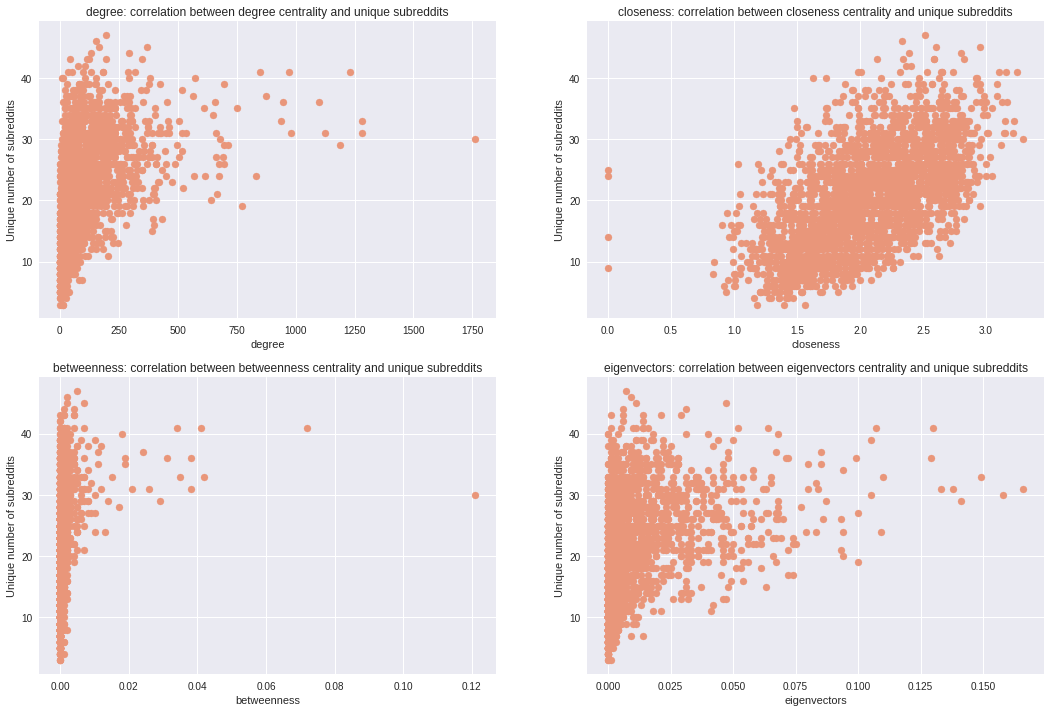

In [ ]:
n2us_dict = nodes_to_used_subreddits(df, unique=True)
n_unique_subreddits = []
for user in tops_centralities_df.user:
    n_unique_subreddits.append(len(n2us_dict[user]))

centralities = [tops_centralities_df.degree, tops_centralities_df.closeness,
                tops_centralities_df.betweenness, tops_centralities_df.eigenvectors]


figs, axs = plt.subplots(2,2, figsize=(18,12))
for i, (centrality, name, ax) in enumerate(zip(centralities, centrality_names, axs.flatten())):
    j = 0 if i < 2 else 1

    ax.scatter(centrality, n_unique_subreddits, color="darksalmon")

    ax.set_xlabel(name)
    ax.set_ylabel('Unique number of subreddits')

    ax.set_title(name + ": correlation between " + name + " centrality and unique subreddits")   

plt.show()





It appears in all cases that users with a top comment on more unique subreddits somewhat correlates with how central the user is in the network - especially with respect to closeness centrality. This is quite sensible as with every new unique subreddit, a connection is likely established to lots of new users (if not filtrated away in the "backbone cut"). This shortens the immediate path to that user, but potentially also to every other user, which that user connects to. 

For many of the other centrality scores, we see that unique number of subreddits somewhat correlates and at least serves as a lower bound for being central - there are no users with comments on fewer than 20 unique subreddits and who are still among the most central user for any of the measures. 

To finish this section we briefly look at the assortativity coefficient for B with respect to the weighted degree.


In [ ]:
print(nx.degree_assortativity_coefficient(B, weight="weight"))

-0.02403781448962321


The small negative coefficient shows that $B$ is disassortative. This indicates a very small tendency towards high degree nodes connecting to low degree nodes. 

Overall, it makes sense that this value is close to zero when we consider that there seem to be some global popular subreddits among all the users. Low degree users as well as high-degree would typically all connect because of these. 

Finally, as an interesting supplement to the discussion on the Trump/Biden community structure above, we can compute the assortativity with respect to the ``from_subreddit`` attribute in $B$.

In [ ]:
print(nx.attribute_assortativity_coefficient(B, attribute="from_subreddit"))

0.21985716830400548


The coefficient shows assortativity with respect to the attribute revealing that Trump users do tend to link to other Trump users and vise versa with Biden users. Note, however, that the computation does not take weights into account. Thus, this assortativity is when considering connections between users if they have at least one subreddit in common.

## 3.3 Comparing candidate sub-networks
In this section the two subnetworks emerging from splitting the network $B$ based on ``from_subreddit`` is further investigated. These subnetworks will be refered to as the trump and biden subnetwork respectively. In this section we will be looking for differences and similarities between the two regarding simple network stats, advanced  statistics, degree distributions and finally communities within each subnetwork. 




In [ ]:
# Load the backbone network B
network_path = "drive/MyDrive/SGAI/BackBone_alpha=0.09.gpickle"
B = nx.read_gpickle(network_path) 

# Extract the two subnetworks
t_nodes = [n for n, from_subreddit in B.nodes(data='from_subreddit') if from_subreddit == "trump"]
b_nodes = [n for n, from_subreddit in B.nodes(data='from_subreddit') if from_subreddit == "biden"]

B_trump_full = B.subgraph(t_nodes).copy()
B_biden_full = B.subgraph(b_nodes).copy()


Again as discussed in 3.1.2, we are primarily interested in investigating how users are connected. Thus, we extract the most connected components

In [ ]:
subnetworks = []
for name, subnetwork in zip(["Trump subnetwork", "Biden subnetwork"], [B_trump_full, B_biden_full]):
    print(name + ":")
    # Extract the largest connected components
    CCs = list(nx.connected_components(subnetwork))

    # Print lengths
    comps = [list(comp) for comp in CCs]
    len_of_comps = sorted([len(comp) for comp in comps], reverse=True)
    print("Sizes of the connected components: ", len_of_comps)
    print("Removed nodes: ", sum(len_of_comps[1:]))
    print("Fracion of nodes: ", round(sum(len_of_comps[1:])/len(subnetwork.nodes), 2))
    print("\n")

    # Use largest component as network
    nodes_of_LC = (max(CCs, key=len))
    subnetworks.append(subnetwork.subgraph(nodes_of_LC).copy())

B_trump = subnetworks[0]
B_biden = subnetworks[1]


Trump subnetwork:
Sizes of the connected components:  [1128, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Removed nodes:  31
Fracion of nodes:  0.03


Biden subnetwork:
Sizes of the connected components:  [1148, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Removed nodes:  38
Fracion of nodes:  0.03




The extraction results in two almost equally large connected subnetworks, where only 3% of nodes are (almost) unconnected and thus removed

### 3.3.1 Network Statistics for candidate sub-networks



#### 3.3.1.1 Motive
Similar to in section 3.1.3 we want an impressions of the extracted subnetworks from the $B$ network. For each candidate's subnetwork we will compute

- Number of nodes $N$
- Number of edges $L$
- Minimum and maximum degree
- Median degree
- Mode of degrees
- Average degree $\langle k \rangle$
- Average $w$
- Minimum $w$ and maximum $w$

where $k$ is degree and $w$ weight. 

Additionally, we will 
- compare each subnetwork's most frequent subreddits within subnetworks.
- look at the subreddits who most often connects users from one subnetwork to users in the other. 











#### 3.3.1.2 Tools
Explanations of these stats/tools can be found in section 3.1.3.2

However, since we are working with subnetworks based on the network $B$, links and degrees now have a slightly different and less intuitive interpretation. As discussed in section 3.2.1; instead of removing edges below some global threshold for all users (e.g. users with less than three common subreddits), we instead set some local relative limit pr. user based on this significance $\alpha$.

The preserved links in $B$ are those who constitutes a significant amount of weight for a user, relative to the user's other links (e.g. a weight 3 might still be significant compared to a weight of 4, but maybe not compared to a weight 10). Thus, we can interpret a "raw" connection as; if two users are connected in $B$, they have a *significant number of subreddits in common*.

These connections are still weighted. Thus, the degree of user $u_i$ now have this slightly less intuitive interpretation: the sum of common subreddits with every other user $u_j$, where $u_i$ and $u_j$ have a significant number of subreddits in common. 


#### 3.3.1.3 Results and discussion


The stats are computed for the two subnetworks ``B_trump`` and ``B_biden``.

In [ ]:
# Extract unweighted degrees
degrees_trump = [d for user, d in B_trump.degree(weight="weight")]
weights_trump = [w for u, v, w in B_trump.edges(data="weight")]

# Extract all weighted degrees
degrees_biden = [d for user, d in B_biden.degree(weight='weight')]
weights_biden = [w for u, v, w in B_biden.edges(data="weight")]


# Inserting data into pandas for nice prints
df_stats = pd.DataFrame({'N':[len(B_trump.nodes), len(B_biden.nodes)],
                         'L':[len(B_trump.edges), len(B_biden.edges)],
                         'Min degree':[np.min(degrees_trump), np.min(degrees_biden)],
                         'Max degree':[np.max(degrees_trump), np.max(degrees_biden)],
                         'Median degree':[int(np.median(degrees_trump)), int(np.median(degrees_biden))],
                         'Mode degree':[Counter(degrees_trump).most_common(1)[0][0], Counter(degrees_biden).most_common(1)[0][0]],
                         '⟨k⟩':[int(round(np.mean(degrees_trump), 0)), int(round(np.mean(degrees_biden),0))],
                         'Avg w':[round(np.mean(weights_trump), 2), round(np.mean(weights_biden), 2)],
                         'Min w':[round(min(weights_trump), 2), round(min(weights_biden), 2)],
                         'Max w':[round(max(weights_trump), 2), round(max(weights_biden), 2)],
                         }, index=["Trump", "Biden"])

df_stats


N      L  Min degree  Max degree  ...  ⟨k⟩  Avg w  Min w  Max w
Trump  1128  10834           3        1351  ...  100   5.18      3     13
Biden  1148  17210           3        2730  ...  187   6.25      3     17

[2 rows x 10 columns]

Despite that the two subnetworks consist of almost equally many users, the table shows that the Biden subnetwork is a lot more dense - it contains $\frac{10834}{17210}\cdot100\%=63$\% more links - i.e. the biden subnetwork has a lot more users with a significant number of subreddits in common. One might suspect that this difference could be caused by Biden users generally having their top 50 comments on many different subreddits - i.e. having more unique subreddits to connect upon:






In [ ]:
avg_unique_subreddits_trump = 0
avg_unique_subreddits_biden = 0


for user, used_subreddits in zip(np.array(df.user), extract_decoded_used_subreddits(df)):
    if user in B_biden.nodes():
        avg_unique_subreddits_trump += len(set(used_subreddits))
    elif user in B_trump.nodes():
        avg_unique_subreddits_biden += len(set(used_subreddits))

avg_unique_subreddits_biden = int(round(avg_unique_subreddits_biden/len(B_biden.nodes()), 0))
avg_unique_subreddits_trump = int(round(avg_unique_subreddits_trump/len(B_trump.nodes()), 0))

print("Average number of unique subreddits (Trump): ", avg_unique_subreddits_biden)
print("Average number of unique subreddits (Biden): ", avg_unique_subreddits_trump)

Average number of unique subreddits (Trump):  20
Average number of unique subreddits (Biden):  21


But the computations above show that users from the two subnetworks approximately has their top 50 comments on the same number of unique subreddits. Therefore, it is very interesting to see such differences in the two subnetworks.

Further inspection of the table shows that the Biden subnetwork has users which beter reflect the subnetwork's general common subreddits, with a max degree more than twice as large as for the trump network. Additionally, the biden network is in general more strongly connected. Both the median and average degree of users is almost twice as high to the trump network, and moreover users on average has on more subreddit in common in the Biden network, as the average weight is 1.07 higher. Finally, we see that the biden subnetwork has users which at most has 17 subreddits in common (max weight), where the trump subnetwork only has 13. However, both subnetworks has no significant connections where users has less than three subreddits in common, and also most users has degree three. 

Overall, the stats of this data indicate that users in the Biden subnetwork tend to have top comments on the same subreddit pages to a larger extent than users from the Trump subnetwork. 

This raises an interesting question - what are the most frequent subreddits among users in each subnetwork. Below, the 20 most frequent subreddits and their frequencies are extracted for each subnetwork:

In [ ]:
# Define method for printing top lists of subreddits
def get_df_with_tops(names, TF_dicts):
    subnet_topreddits_df = pd.DataFrame()
    for name, TF_dict in zip(names, TF_dicts):
        TF_list = [(s,f) for (s,f) in TF_dict if s not in ["trump", "biden", ""]]
        TF_list = sorted(TF_list, key=lambda x: x[1], reverse=True)
        subnet_topreddits_df[name] = TF_list[:20]

    return subnet_topreddits_df

unique_used_subreddits_pr_trump_user = []
unique_used_subreddits_pr_biden_user = []


for user, used_subreddits in zip(np.array(df.user), extract_decoded_used_subreddits(df)):
    if user in B_biden.nodes():
        unique_used_subreddits_pr_biden_user += list(set(used_subreddits))
    elif user in B_trump.nodes():
        unique_used_subreddits_pr_trump_user += list(set(used_subreddits))

# Use the NLTK package's inbuild freqdist to save a dict with frequencies for each subreddit
TF_trump = nltk.FreqDist(unique_used_subreddits_pr_trump_user).items()
TF_biden = nltk.FreqDist(unique_used_subreddits_pr_biden_user).items()
subnet_topreddits_df = pd.DataFrame()

for name, TF_dict in zip(["Trump", "Biden"], [TF_trump, TF_biden]):
    TF_list = [(s,f) for (s,f) in TF_dict if s not in ["trump", "biden", ""]]
    TF_list = sorted(TF_list, key=lambda x: x[1], reverse=True)
    subnet_topreddits_df[name] = TF_list[:20]

top_df = get_df_with_tops(["Trump", "Biden"], [TF_trump, TF_biden])
top_df

Trump                                              Biden
0                                 (Conservative, 473)                                    (Politics, 716)
1                                (Ask Reddit..., 459)                               (Ask Reddit..., 547)
2                                  (Reddit Pics, 249)             (All news, US and international., 423)
3                                        (funny, 238)                                  (World News, 394)
4              (All news, US and international., 222)                                 (Reddit Pics, 347)
5                                     (Politics, 212)                       (Today I Learned (TIL), 282)
6                            (/r/PublicFreakout, 201)                                       (funny, 260)
7             (/r/Memes the original since 2008, 189)                           (/r/PublicFreakout, 227)
8                                   (World News, 181)                (Novel Coronavirus (COVID-19), 187)
9                        (Today I Learned (TIL), 173)    (A subreddit for cute and cuddly pictures, 186)
10                                    (r/gaming, 170)  (2020 Political Hindsight - a Donald Trump lov...
11    (A subreddit for cute and cuddly pictures, 157)                   (Movie News and Discussion, 177)
12       (For your Opinions that are Unpopular , 145)                                   (/r/videos, 160)
13                                  (conspiracy, 138)                        (White People Twitter, 159)
14                         (Interesting As Fuck, 138)                                    (r/gaming, 155)
15                                   (dankmemes, 131)               (Sadly, this is not the Onion., 149)
16  (Tucker Carlson: The Sworn Enemy of Lying, Pom...                         (Interesting As Fuck, 143)
17                          (All things Trashy!, 120)  (.gifs - funny, animated gifs for your viewing...
18  (.gifs - funny, animated gifs for your viewing...                   (Insane People on Facebook, 131)
19                                       (WTF?!, 119)                              (/r/Technology , 130)

This reveals some very interesting results. First of all, we notice a lot of the geneally popular subreddits like "Ask Reddit...", "Today I Learned (TIL)" etc. within both subnetworks. 

There seem to be some interests of republican politics among the users in Trump subnetwork. These users often have top comments on the [conservative](https://www.reddit.com/r/Conservative/) subreddit, which writes the following in their description: "The place for Conservatives on Reddit". Other indicators are index 16, "Tucker Carlson: The Sworn Enemy of Lying, Pomposity, Smugness & Groupthink" who, citing his [wikipedia](https://en.wikipedia.org/wiki/Tucker_Carlson#Views_on_Republicans_and_Democrats) page, "*has been described by Politico as "perhaps the highest-profile proponent of Trumpism*". This kind of indications are less prominent among the users in the Biden subnetwork, with the only one being [2020 Political Hindsight - a Donald Trump lovefest](https://www.reddit.com/r/PoliticalHumor/) impicitly. The description says "*A subreddit focused on US politics, and the ridiculousness surrounding them.*" which together with the title somewhat implies these users are opposed to Trump. Besides from that, it generally seem like users who have top comments on the Biden subreddit is generally also very active on various political subreddit, e.g. "Politics", "All news, US and international", "World news" etc.

Apart from the subreddits with political implications, there are a couple of funny observations. "conspiracies" is one of the most represented subreddit among top comments of users in the Trump network whereas "Novel Coronavirus (COVID-19)" is among the Biden subnetwork.


An interesting experiment is to filtrate out the top 100 subreddits mentioned in section 2. This is done for each subnetwork below using the ``string`` and ``re`` (regular expressions) modules. Note that a lot of small changes are required in order to make titles match for subreddits, as these may change names over time.


In [ ]:
def remove_top100_subreddits(TF_dict, top100):
      removed = []
      # Convert to list without the biden trump and empty subreddits
      TF_list = [(s,f) for (s,f) in TF_dict if s not in ["trump", "biden", ""]]
      no_top100_TF_list = []

      # Loop over all subreddits in list
      for (s,f) in TF_list:
          is_top_100 = False
          # Make titles fit
          s_form = s.replace("r/", "")
          s_form = s_form.replace("(TIL)", "")
          s_form = re.sub("[^0-9a-zA-Z]+", "", s_form)
          
          #Check if subreddit matches with a top100 subreddit
          for s_100 in top100:
              s_100 = re.sub("[^0-9a-zA-Z]+", "", s_100)
              is_top_100 = s_form.lower() == s_100.lower()
              if is_top_100:
                  removed.append((s, f, "--", s_100))
                  break

          # Add all subreddits which are not in top 100 subreddits       
          if not(is_top_100):
              no_top100_TF_list.append((s,f))

      return no_top100_TF_list, removed



non_top100_trump, removed_trump = remove_top100_subreddits(TF_trump, top100_subreddits)
non_top100_biden, removed_biden = remove_top100_subreddits(TF_biden, top100_subreddits)

# Print
top_df = get_df_with_tops(["Trump", "Biden"], [non_top100_trump, non_top100_biden])
top_df

Trump                                              Biden
0                                 (Conservative, 473)             (All news, US and international., 423)
1                                  (Reddit Pics, 249)                                 (Reddit Pics, 347)
2              (All news, US and international., 222)                           (/r/PublicFreakout, 227)
3                            (/r/PublicFreakout, 201)                (Novel Coronavirus (COVID-19), 187)
4             (/r/Memes the original since 2008, 189)    (A subreddit for cute and cuddly pictures, 186)
5     (A subreddit for cute and cuddly pictures, 157)  (2020 Political Hindsight - a Donald Trump lov...
6        (For your Opinions that are Unpopular , 145)                   (Movie News and Discussion, 177)
7                                   (conspiracy, 138)                        (White People Twitter, 159)
8   (Tucker Carlson: The Sworn Enemy of Lying, Pom...               (Sadly, this is not the Onion., 149)
9                           (All things Trashy!, 120)  (.gifs - funny, animated gifs for your viewing...
10  (.gifs - funny, animated gifs for your viewing...                   (Insane People on Facebook, 131)
11     (Let's hope you didn't vote for the pedo, 114)            (/r/Memes the original since 2008, 129)
12                       (ActualPublicFreakouts, 106)                    (The Ideological Trashcan, 128)
13                   (Movie News and Discussion, 102)         (A gallery of inexplicable stupidity, 127)
14  (People who actively act like a piece of shit,...              (Television News and Discussion, 112)
15                (What Could Possibly Go Wrong?, 97)                          (All things Trashy!, 110)
16                                (AskThe_Donald, 96)  (For photos that are, you know, mildly interes...
17  (All posts must be related to gun politics; ci...                                  (MadeMeSmile, 95)
18                                     (WalkAway, 88)                                      (atheism, 92)
19                               (Steven Crowder, 85)                               (Reddit Science, 92)

This reveals a couple more subreddits which somewhat implies political beliefs, e.g. 16. "AskThe_Donald" as well as 12. "The Ideological Trashcan" (which seem to be a liberal oriented subreddit also known as "r/neoliberal"). Moreover, it revealed a couple more interesting observations; that gun politics (index 17) is a popular subreddit among users in the Trump subnetwork and atheism (index 18) is among users of the Biden subnetwork.

However, we see that there are still many 'neutral' subreddits like "Reddit Pics" and "PublicFreakout" who appears in the lists. As another supplement to this work, it would be informative to analyse these networks where these generally common/neutral subreddits where removed. However, this introduces a lot of bias in when and how to evaluate a subreddit as neutral. E.g. in our case, it might indicate something, that "Politics" is the number one top subreddit for the Biden subnetwork, and number five among the Trump. And furthermore, what would it mean if "Ask Reddit..." where a lot more popular among one type of users compared to another?

Finally, we'll investigate the subreddits who most frequently connects users in

In [ ]:
cross_common_subreddits = []
# Make list of all subreddits which connects users
for u, v, subr in B.edges(data="common_subreddits"):
    if B.nodes[u]["from_subreddit"] != B.nodes[v]["from_subreddit"]:
        cross_common_subreddits += subr
        
# Count unique occurences and sort
TF_cross = nltk.FreqDist(cross_common_subreddits)
n_links = TF_cross.N()
TF_list = [(s,round(f/n_links, 2)) for (s,f) in TF_cross.items()]
TF_list = sorted(TF_list, key=lambda x: x[1], reverse=True)

# Print
cross_pd = pd.DataFrame(TF_list[:20], columns=["Subreddit", "Frequency (%)"])
cross_pd

Subreddit  Frequency (%)
0                                       Ask Reddit...           0.09
1                                         Reddit Pics           0.06
2                                            Politics           0.05
3                                               funny           0.05
4                     All news, US and international.           0.05
5                                          World News           0.04
6                               Today I Learned (TIL)           0.04
7                                   /r/PublicFreakout           0.03
8                                            r/gaming           0.02
9                           Movie News and Discussion           0.02
10                                          /r/videos           0.02
11  .gifs - funny, animated gifs for your viewing ...           0.02
12           A subreddit for cute and cuddly pictures           0.02
13                                Interesting As Fuck           0.02
14              For your Opinions that are Unpopular            0.01
15                                       Conservative           0.01
16                   /r/Memes the original since 2008           0.01
17                      Sadly, this is not the Onion.           0.01
18                                          dankmemes           0.01
19                A gallery of inexplicable stupidity           0.01

We see that it is generally the very popular and neutral subreddits which connects the two subnetworks. Additionally, politic and news related subreddits seem to appear frequently among both type of users, which is sensible considering we originally found them from comments on presedential candidates - hence it makes sense that the group considered above are of users engaging in these news and poltic related subreddits.  

### 3.3.2 Degree Distributions and the Network types


#### 3.3.2.1 Motive
Now the subnetworks are examined for whether extracting them from $B$ conserves the scale-free appearence of $B$ for both subnetworks. This will reveal whether they are still charactized by having hubs - i.e. users who most other users tend to have many subreddits in common with. 

#### 3.3.2.3 Tools
Most of the relevant theory is already described in section 3.1.3.2. It is worth mentioning that some studies [Michael P. H. Stumpf et al.](https://www.pnas.org/content/102/12/4221) suggests that subnetworks of scale-free networks are not scale-free, if nodes are randomly drawn from the subnetwork with some probability. However, the paper does not state explicitly whether this is specific to unweighted scale-free networks, or if it also generalizes to weighted scale-free networks. Note also that they are more strict in terms of statistical significane when describing a network as scale-free, as opposed to this work where we primarily consider general (visual) tendencies.

#### 3.3.2.3 Results and discussion

We immediately extract the degree distributions for the two subnetworks, and plot them on both the linear and log-log scale next to the original network $B$

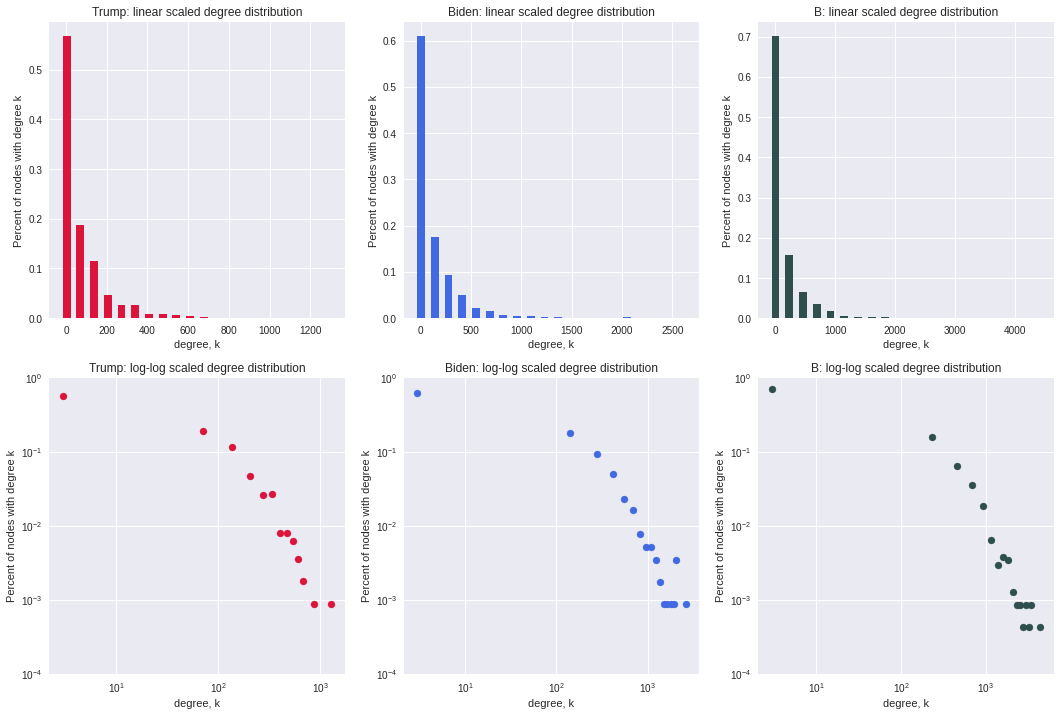

In [ ]:

def plot_degree_dists(degrees_list, name_list, colors):

    figs, axs = plt.subplots(2,3, figsize=(18,12))

    n_bins = 20

    for i, (degrees, names) in enumerate(zip(degrees_list, name_list)):
        count, bins = np.histogram(degrees, bins=n_bins)
        xbins=bins[:len(bins)-1]
        probs = count/sum(count)


        axs[1][i].set_xscale("log")
        axs[1][i].set_yscale("log")
        axs[1][i].set_ylim(1e-4,1)
        axs[1][i].scatter(xbins, probs, color=colors[i])

        axs[0][i].bar(xbins, probs, max(degrees)/35, color=colors[i])

        for j in range(2):
          axs[j][i].set_xlabel('degree, k')
          axs[j][i].set_ylabel('Percent of nodes with degree k')

        axs[0][i].set_title(name_list[i] + ": linear scaled degree distribution")   
        axs[1][i].set_title(name_list[i] + ": log-log scaled degree distribution")   
    plt.show()

degrees_biden = [w for (d, w) in B_biden.degree(weight="weight")]
degrees_trump = [w for (d, w) in B_trump.degree(weight="weight")]
degrees = [w for (d, w) in B.degree(weight="weight")]

colors = ["crimson", "royalblue", "darkslategray"]
plot_degree_dists([degrees_trump, degrees_biden, degrees], ["Trump", "Biden", "B"], colors)

It appears that both subnetworks' degrees are distributed very similar to $B$ (see section 3.2.1.3) and therefore both subnetworks seem to greatly conserve the distribution - especially from inspecting the log-log scale plot. Like with $B$, the degrees still seem to somewhat follow a power-law distribution and we can see a presence of hubs for both subnetworks.

Again, by using the Python library `powerlaw` we can find the best power-law fit to our degree distributions and report the degree exponent $\gamma$:

In [ ]:
# Fit to each degree distribution
fits = []
for degs in [degrees_trump, degrees_biden, degrees]:
    fits.append(powerlaw.Fit(degs))
   

Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


In [ ]:
for fit, name in zip(fits, ["Trump", "Biden", "B"]):
    gamma = fit.alpha
    print(f"{name}:  Gamma={round(gamma, 2)} \n")

Trump:  Gamma=6.45 

Biden:  Gamma=3.08 

B:  Gamma=3.22 



We find that $\gamma>3$ for both cases which still places the subnetworks in the random network regime. For the Biden subnetwork, $\gamma$ is slightly less than for $B$, which indicates that "extreme" degrees are a little more likely observed in the Biden network. In opposition to this, $\gamma$ for the Trump subnetwork is a lot higher, revealing that extreme outcomes in the Trump network is less likely to be observed. These two results are in fine correspondence with previous observation; that the Biden network is a lot more dense than the Trump network.

It would be interesting to briefly look at how a random extraction (of similar size to the two subnetworks) of $B$ would emerge. Thus we can study superficially whether this somewhat conservation of the distributions appearance is trivial from a random extraction of weighted subnetworks.


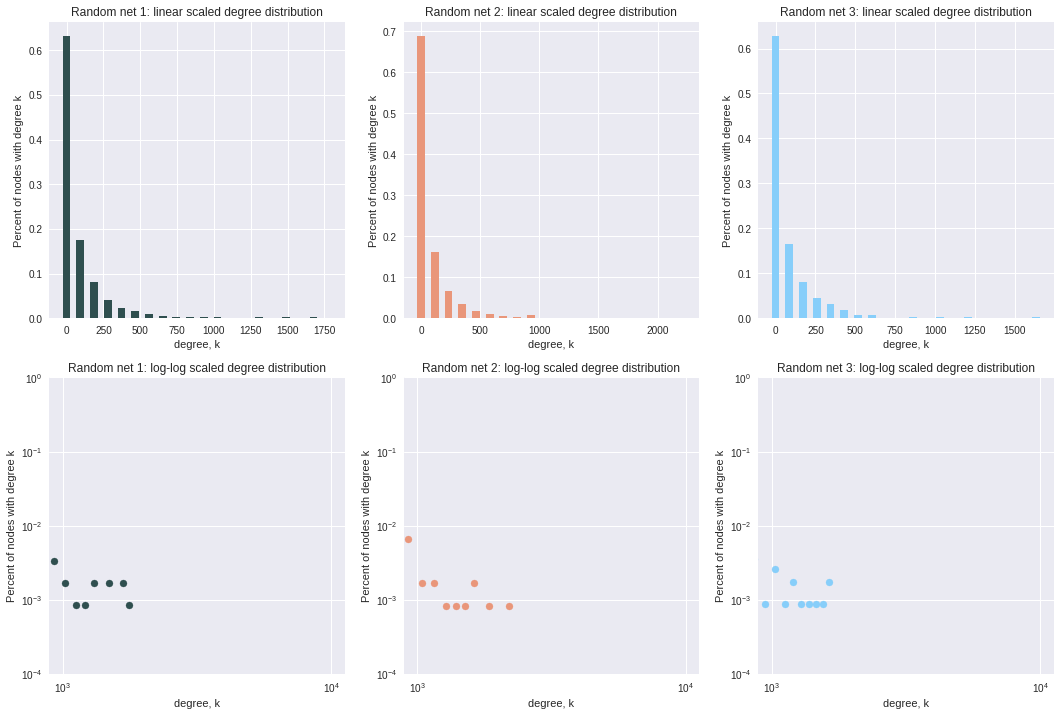

In [ ]:
# Extract three random subnetworks of B
random_degrees = []
for i in range(3):
    random_nodes = [n for n in B.nodes() if np.random.uniform(0,1) > 0.5]
    B_random = B.subgraph(random_nodes).copy()
    random_degrees.append([w for (d, w) in B_random.degree(weight="weight")])


# plot them
colors = ["darkslategray", "darksalmon", "lightskyblue"]
plot_degree_dists(random_degrees, ["Random net 1", "Random net 2", "Random net 3"], colors)


Although plots on the linear scale seem similar to the previous plots, the degree distribution on the log-log appear quite different from before. This suggests for our case that that the scale-free appearance of the weighted degree distribution is not very well preserved when extracting a random subnetwork. 

This implies that the attribute ``from_subreddit`` seem to somewhat reflect a structure in $B$, which deviates from randomness. Whether this is an indication of some sort of community structure is difficult to tell. Although it does not introduce obvious bias, it might have an impact on these obseration that the data is collected from the two subreddit pages which we now divide the network accordingly to. In future work it would be interesting to further investigate differences in properties of subnetworks which respectively conserves and doesn't conserve appearence of degree distributions.  

Finally, the positions of the nodes are computed using the ``ForceAtlas2`` module as before.

In [ ]:
# Calculate position with the ForceAtlas2 algorithm
forceatlas2 = ForceAtlas2(outboundAttractionDistribution=True,  # Dissuade hubs
                          edgeWeightInfluence=1.0,
                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=0.1,
                          # Log
                          verbose=True)

pos_trump = forceatlas2.forceatlas2_networkx_layout(G=B_trump, pos=None, iterations=2000)
pos_biden = forceatlas2.forceatlas2_networkx_layout(G=B_biden, pos=None, iterations=2000)

node_sizes_trump = [(d+1)/10 for (n, d) in B_trump.degree(weight="weight")]
node_sizes_biden = [(d+1)/10 for (n, d) in B_biden.degree(weight="weight")]

  0%|          | 0/2000 [00:00<?, ?it/s]

BarnesHut Approximation  took  5.38  seconds
Repulsion forces  took  18.16  seconds
Gravitational forces  took  0.17  seconds
Attraction forces  took  0.45  seconds
AdjustSpeedAndApplyForces step  took  0.54  seconds


100%|██████████| 2000/2000 [00:30<00:00, 65.46it/s]

BarnesHut Approximation  took  5.91  seconds
Repulsion forces  took  22.40  seconds
Gravitational forces  took  0.13  seconds
Attraction forces  took  0.74  seconds
AdjustSpeedAndApplyForces step  took  0.55  seconds


And then plotted

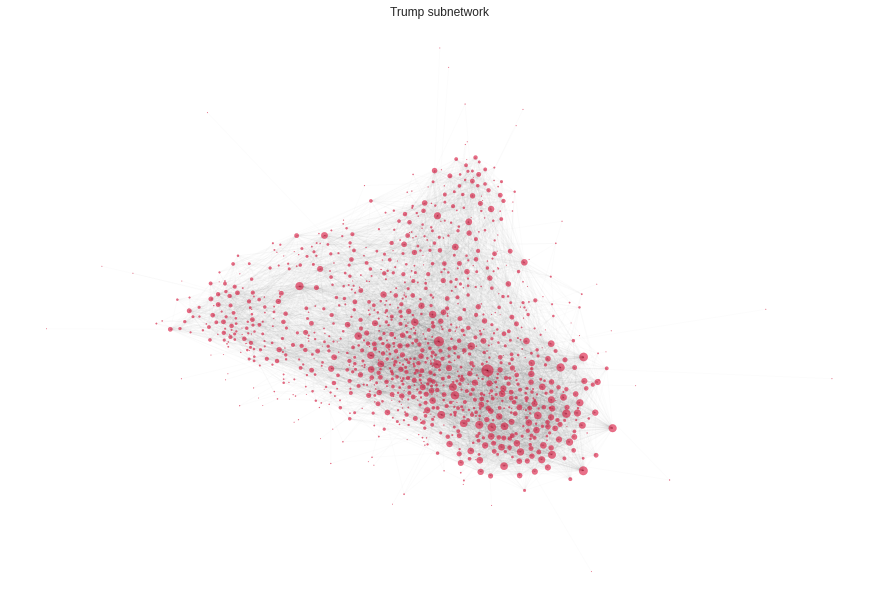

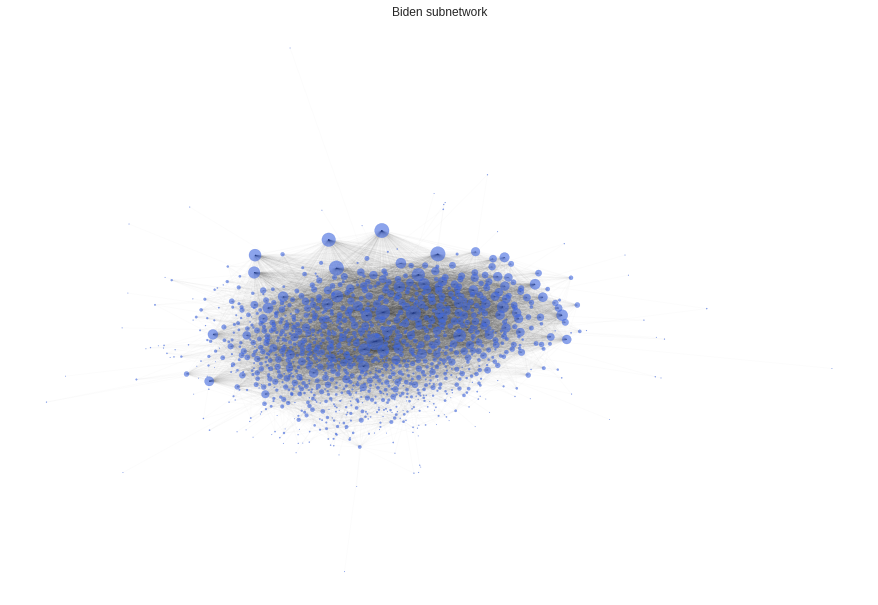

In [ ]:
fig = plt.figure(figsize=(12, 8))
nx.drawing.nx_pylab.draw(B_trump, pos=pos_trump, node_color="crimson", node_size=node_sizes_trump, with_labels=False, edge_color='white', alpha=.6)
nx.drawing.nx_pylab.draw(B_trump, pos=pos_trump, node_color="crimson", node_size=node_sizes_trump, with_labels=False, edge_color='black', alpha=.01)
plt.title("Trump subnetwork")
plt.show()

fig = plt.figure(figsize=(12, 8))
nx.drawing.nx_pylab.draw(B_biden, pos=pos_biden, node_color="royalblue", node_size=node_sizes_biden, with_labels=False, edge_color='white', alpha=.6)
nx.drawing.nx_pylab.draw(B_biden, pos=pos_biden, node_color="royalblue", node_size=node_sizes_biden, with_labels=False, edge_color='black', alpha=.01)
plt.title("Biden subnetwork")
plt.show()


When comparing the two plots we see that the Biden subnetwork appears more compact. This makes sense when considering that strongly connected nodes are placed closer to each other in force directed drawing algorithms. Recall that we previously saw that nodes on average were more connected and with greather weights in the Biden subnetwork.

### 3.3.3 Community detection within partitions
 

#### 3.3.3.1 Motive

After having considered communities on the global network the attention is now turned within the partionings into `trump` and `biden`. It is interesting to see if we can find community structures with a reasonable level of modularity within these partitions as this would yield information on the diversity of the users of each subreddit. It could be imagined that there could be communities in either partitioning for which both political and apolitical interests differ. 

Also this will add to the pursuing text analysis in section 3.4 as we will be able to consider both global and more localized analyses of comments. 

#### 3.3.3.2 Tools

For the community detection we again be utilizing the Louvain algorithm which was presented in section 3.2.2.2. 

Apart from the modularity score which will be evaluated in term of significance, we will also evaluate the community structure in either subgraph from a density point of view following the sense of community described by hypothesis H2 (Barabasi, 9.2). 

Finally we will present the 20 most commonly appearing subreddits in the found communities and see which informations can be drawn out from looking at these. 

#### 3.3.3.3 Results and discussion

We commence by again loading the backbone network $B$ and partitioning it into two subgraphs consisting of the nodes found on respectively r/DonaldTrump and r/JoeBiden:

In [ ]:
Bpath = "/content/drive/MyDrive/SGAI/BackBone_alpha=0.09.gpickle"

In [ ]:
def get_subgraph_from_subreddit(network, from_subreddit):
  nodes = [u for u, subreddit in B.nodes.data(data="from_subreddit") if subreddit == from_subreddit]
  return network.subgraph(nodes)

def lcc(network):
  connected_components = nx.connected_components(network)
  network = network.subgraph(list(max(connected_components, key=len)))
  return network

In [ ]:
# Load B graph
B = nx.read_gpickle(Bpath)

# Get the largest connected components of Trump and Biden subgraphs
Btrump = lcc(get_subgraph_from_subreddit(B, "trump"))
Bbiden = lcc(get_subgraph_from_subreddit(B, "biden"))

NBtrump, LBtrump = len(Btrump.nodes), len(Btrump.edges)
NBbiden, LBbiden = len(Bbiden.nodes), len(Bbiden.edges)

counts = { "Nodes":[NBtrump, NBbiden], "Edges":[LBtrump, LBbiden]}
dfview = pd.DataFrame(counts, index=["Btrump", "Bbiden"])
dfview

Nodes  Edges
Btrump   1128  10834
Bbiden   1148  17210

We see that there are an almost equal amount of nodes in the largest connected components of the two subgraphs, where as the $B_{biden}$ has $\approx 6,400$ more edges than the $B_{trump}$ subgraph, which would indicate that the users from the Biden subreddit has generally speaking more in common than the users on the Trump subreddit. 

We now use the Louvain algorithm implemented in `best_partition` to find the partitioning on the two subgraphs that yields the highest modularity and compute the value of the modularity of this partitioning:

In [ ]:
def partition_and_modularity(network, state):
  partition = community.best_partition(network, random_state=state)
  modularity = community.modularity(partition, network)
  return partition, modularity

Btrump_partition, Btrump_modularity = partition_and_modularity(Btrump, state=1)
Bbiden_partition, Bbiden_modularity = partition_and_modularity(Bbiden, state=1)

In [ ]:
tnoc = len(set(Btrump_partition.values()))
bnoc = len(set(Bbiden_partition.values()))
stats = { "Number of communities":[tnoc, bnoc], "Modularity":[Btrump_modularity, Bbiden_modularity]}
dfview = pd.DataFrame(stats, index=["Btrump", "Bbiden"])
dfview

Number of communities  Modularity
Btrump                      6    0.404737
Bbiden                      6    0.265512

We observe that the Louvain algorithm terminates at a partitioning into 6 communities on both subgraphs. 

It can be seen that the modularity is highest ($\approx 0.40$) in the partitioning on $B_{trump}$. The modularity of partitioning on $B_{biden}$ is rather low ($\approx 0.27$), even slightly lower than what Newman points to as significant community structure in practise which he suggests is around the level of 0.3 (Newman 2003, p.1). 

This may also have something to do with the fact  that the Biden subgraph is relatively more dense than the Trump subgraph. This means that every node has in general rather much in common with every other node in the network, making it hard to detect clear cut communities. 

In order to give another impression of the level of community structure, we can also consider the density hypothesis for communities H2 (Barabasi, 9.2) which says that a community is a locally dense connected subgraph in a network. 

One can convert this intuition into two equalities:

$$
\begin{align}
\text{Strong community}&:\quad \forall_i \hspace{0.2cm} k_{i}^{int}(C) > k_{i}^{ext}(C) \quad \text{(Barabasi, eq 9.1)} \\
\\
\text{Weak community}&:\quad \hspace{0.2cm} \sum_i k_{i}^{int}(C) > \sum_i k_{i}^{ext}(C) \quad \text{(Barabasi, eq 9.2)}
\end{align}
$$

where $k_{i}^{int}(C)$ denotes the degree of node $i$ internally to $C$, meaning the the links inside community $C$ and $k_{i}^{int}(C)$ denotes the degree of node $i$ externally to $C$ meaning the the links going outside community $C$ (Barabasi, 9.2).

In the present context we will extend these equalities to use the weighted degree for $k_i$. 

This means that the strong community condition is saying that every node in a given community C must have more in common with nodes in C than with any other nodes. The weak community condition on the other hand just says that in total the nodes in community C must have more in common than they have in common with other nodes in total. 

The following helper function are first implemented to help carry out the analyses of this section, which is a mapping from a community partition onto the nodes of the community:

In [ ]:
def communities_to_nodes(partition):
  communities_to_nodes = {}

  community_names = set([v for k, v in partition.items()])
  for name in community_names:
    nodes = [key for key, value in partition.items() if value==name]
    communities_to_nodes[name] = nodes
  
  return communities_to_nodes

The following function maps each community to a list of the internal and external degrees of each node in the community:

In [ ]:
def community_to_degrees(network, partition,weighted=True):
  community_to_degrees = collections.defaultdict(dict)
  c2n = communities_to_nodes(partition)
  nnodes = 0

  for community, community_nodes in c2n.items():
    k_int_C = []
    k_ext_C = []
    for i in community_nodes:
      nnodes += 1
      k_int = 0
      k_ext = 0 
      for j in network[i]:
        if j in community_nodes:
          if weighted:
            k_int += network[i][j]["weight"]
          if not weighted:
            k_int += 1
        else:
          if weighted:
            k_ext += network[i][j]["weight"]
          elif not weighted:
            k_ext += 1

      k_int_C.append(k_int)
      k_ext_C.append(k_ext)

    community_to_degrees[community]["int"] = k_int_C
    community_to_degrees[community]["ext"] = k_ext_C
  return community_to_degrees

In [ ]:
tc2d = community_to_degrees(Btrump, Btrump_partition, weighted=True)
bc2d = community_to_degrees(Bbiden, Bbiden_partition, weighted=True)

# sanity check
total_weighted_degree_subgraph = sum( [wd for _,wd in Btrump.degree(weight="weight")])
total_weighted_degree_communities = sum([sum(deg_type["int"]) + sum(deg_type["ext"]) for _, deg_type in tc2d.items()])

assert total_weighted_degree_subgraph == total_weighted_degree_communities

Now we can implement `community_to_type` which maps a community to the strongest condition from H2 that it satisfies:

In [ ]:
def community_to_type(community_to_degrees):
  community_to_type = {}
  for community, deg_type in community_to_degrees.items():
    condition_1 = all([ k_int > k_ext for k_int, k_ext in zip(deg_type["int"], deg_type["ext"]) ]) # Barabasi, eq. 9.1
    condition_2 = sum([k_int for k_int in deg_type["int"]]) > sum([k_ext for k_ext in deg_type["ext"]]) # Barabasi, eq. 9.2

    if condition_1:
      community_to_type[community] = "strong"
    elif condition_2:
      community_to_type[community] = "weak"
    else:
      community_to_type[community] = "neither"
  return community_to_type

This enables an investigation of the strength of the found communities:

In [ ]:
trump_communities_to_type = community_to_type(tc2d)
biden_communities_to_type = community_to_type(bc2d)
t = [(k,v) for k, v in trump_communities_to_type.items()]
b = [(k,v) for k, v in biden_communities_to_type.items()]

cols = ["Trump communites", "Biden communities"]
stat = [[elem[0], elem[1]] for elem in zip(t,b)]

dfview = pd.DataFrame(data=stat, columns=cols)
dfview

Trump communites Biden communities
0     (0, neither)         (0, weak)
1        (1, weak)      (1, neither)
2        (2, weak)         (2, weak)
3     (3, neither)         (3, weak)
4        (4, weak)      (4, neither)
5        (5, weak)         (5, weak)

This investigation shows that the density sense of the communities are at most weak and some of them don't satisfy even the weak criterion of H2. This investigation combined with the fact that the modularity scores also are relatively low suggests that we should not expect to see very clear communities. 

With this in mind, we can turn to investigate the properties of the found communities on the two subgraphs. First we will plot the sizes of the communities: 

In [ ]:
def get_community_sizes(partition):
  D = partition
  communities = set(D.values())
  community_sizes = []
  for k in range(len(communities)):
    size = sum(map((k).__eq__, D.values()))
    community_sizes.append(size)
  return community_sizes

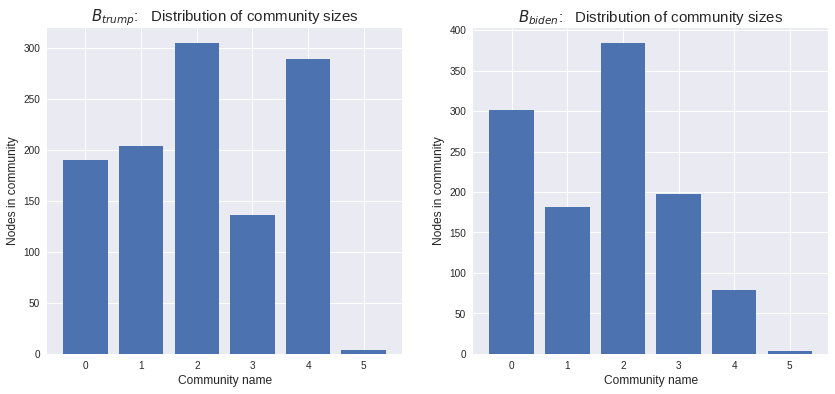

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
partitions = [Btrump_partition, Bbiden_partition]
titles = ["$B_{trump}$", "$B_{biden}$"]
for idx, ax in enumerate(axes):
  title = titles[idx] + ":   Distribution of community sizes"
  names = list(set([v for k, v in partitions[idx].items()]))
  sizes = get_community_sizes(partitions[idx])
  ax.bar(x=names, height=sizes)
  ax.set_title(title, fontsize=15)
  ax.set_xlabel("Community name", fontsize=12)
  ax.set_ylabel("Nodes in community", fontsize=12)

The community size distributions are quite similar in the sense that four of the communities contain over 150 nodes. 

The Louvain algorithm is able to detect and preserve smaller communities (Blondel et. alia 2008, p. 5) through its iterations, which is a feature that helps bettering the so-called resolution limit where some communities disappear as the modularity can sometimes be increased by merging smaller communities into larger in unfortunate ways with regards to discovering small community structures in real networks (Barabasi, 9.4) (Heshe, Græsholt & Tommerup, assignment 2). 

As we see in both partitionings community 5 is detected and preserved even if it is quite small compared to the other communities. 

Now we will investigate which subreddits the users in each of the communities are commenting on. 

To that end we introduce the mapping `nodes_to_used_subreddits` that maps the node names (i.e. user names) to the data attribute `used_subreddits` and the function `topreddits` that extracts a number of most frequent `used_subreddits` controlled by the parameter `level`:

In [ ]:
def nodes_to_used_subreddits(dataframe):
  users = [u for u in dataframe["user"]]
  used_subreddits = [json.loads(us) for us in dataframe["used_subreddits"]]
  n2us = {}
  for u, us in zip(users, used_subreddits):
    n2us[u] = us
  return n2us

def topreddits(network, dataframe, partition, level):
  c2n = communities_to_nodes(partition)
  n2us = nodes_to_used_subreddits(dataframe)
  communities_to_topreddits = {}
  for community, nodes in c2n.items():
    subgraph = network.subgraph(nodes)
    community_subreddits = []
    for node in subgraph:
      used_subreddits = n2us[node]
      for used_subreddit in used_subreddits:
        if not used_subreddit in ["trump", "biden"]:
          community_subreddits.append(used_subreddit)
    
    counter = Counter(community_subreddits)
    topreddits = counter.most_common(level)
    communities_to_topreddits[community] = topreddits

  return communities_to_topreddits

Next we read in the data frame and run extract the twenty most commonly appearing subreddits in each for the communities:

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/SGAI/data_all_merged.csv", sep=";")

level=20
trump_topreddits = topreddits(Btrump, df, Btrump_partition, level=level)
biden_topreddits = topreddits(Bbiden, df, Bbiden_partition, level=level)

The next two helper functions are introduced to present the results in a nice pandas DataFrame view:

In [ ]:
def zip_values(topreddits, level):
  zipped_values = []
  for idx in range(level):
    reddits_at_idx = []
    for topredditlist in topreddits.values():
      try:
        reddits_at_idx.append(topredditlist[idx])
      except IndexError:
        reddits_at_idx.append(("na",None))

    zipped_values.append(reddits_at_idx)

  return zipped_values

def dataframe_format(topreddits):
  assert len(topreddits)>0, "Level must be larger than zero."

  level = len(topreddits[0])
  data = zip_values(topreddits, level)
  cols = [k for k in topreddits.keys()]

  return data, cols

First we consider the communities in the Trump subgraph, $B_{trump}$:

In [ ]:
tdata, tcols = dataframe_format(trump_topreddits)
tdf = pd.DataFrame(data=tdata, columns=tcols)
tdf.index = np.arange(1, level+1)
tdf

0  ...                                                  5
1                                     (Politics, 499)  ...                                         (SKOL, 24)
2                                 (Conservative, 425)  ...                                 (Conservative, 16)
3                                (Ask Reddit..., 352)  ...     (NFL: National Football League Discussion, 10)
4                                   (conspiracy, 147)  ...                                (Showerthoughts, 8)
5                            (/r/PublicFreakout, 144)  ...                                  (Dark Souls 2, 8)
6              (All news, US and international., 134)  ...                             (World of Warcraft, 7)
7   (2020 Political Hindsight - a Donald Trump lov...  ...                                  (WoW: Classic, 6)
8                                    (World News, 93)  ...                                      (r/gaming, 5)
9                         (ActualPublicFreakouts, 83)  ...                                  (Dark Souls 3, 5)
10                    (Insane People on Facebook, 81)  ...                                (Total Wareddit, 5)
11                 (Novel Coronavirus (COVID-19), 78)  ...                                 (Life Pro Tips, 4)
12        (For your Opinions that are Unpopular , 73)  ...                                 (/r/Bloodborne, 4)
13                                  (Reddit Pics, 67)  ...                                   (PlayStation, 3)
14                          (Interesting As Fuck, 65)  ...                                    (Elden Ring, 3)
15             (/r/Memes the original since 2008, 63)  ...                  (People Person's Paper People, 3)
16      (Let's hope you didn't vote for the pedo, 56)  ...                         (ARK: Survival Evolved, 3)
17                            (Murdered By Words, 51)  ...                                (Reddit Science, 2)
18                                          (NBA, 50)  ...  (/r/XboxOne - The home of everything Xbox One ...
19     (NFL: National Football League Discussion, 47)  ...                     (Sekiro: Shadows Die Twice, 2)
20                           (BlackPeopleTwitter, 47)  ...                                    (Dark Souls, 2)

[20 rows x 6 columns]

Comparing the results above it seems at first glance that the found most commonly appearing subreddits are quite similar to the ones found in the communities on the entire graph $B$ in section 3.2.2.3. 

Some interesting things can be pointed out:

1. The larger communities seem to be composed of a rather similar set of subreddits like `Ask Reddit`, `Conservative`, `Politics`, `PublicFreakout` and `Conspiracy` to name a few that jumps into the eyes as repetitions. 

2. The subreddit `Conservative` is a top scoring scoring subreddits on all the communities, which would indicate that the users in $B_{trump}$ in general has been active on this subreddit and that we would argue that Republicans are politically conservative. 

3. Community 1 seems to have captured the users which share an interest in fire arms: Subreddits like `Firearms`, `Gun Politics` and `All posts must be related to gun politics...` (also known as r/progun).  

4. Community 4 seems to have a more consistent interest in the internet phenomenon known as "memes" as several subreddits pertain to this phenomenon in various forms. 

5. Community 5 which is the small community consists of people active on subreddits about video games like `Dark Souls` and `World of Warcraft` and sports with `NFL...` and also `SKOL`. The top scorer is the subreddit for NFL team Minnesota Vikings called `SKOL` because of their fans' chants: Skol is apparently the Americanized version of the Danish word "skål". 

The community described in point 5 seem to be qualitatively very similar to community 5 found on the whole graph in section 3.2.2.3, which was also seen to consist only of people from the Trump subreddit. 

Next we will take a look at the top 20 most commonly appearing subreddits in the communities found on the Biden subgraph $B_{biden}$:

In [ ]:
bdata, bcols = dataframe_format(biden_topreddits)
bdf = pd.DataFrame(data=bdata, columns=bcols)
bdf.index = np.arange(1, level+1)
bdf

0  ...                                                  5
1                                     (Politics, 651)  ...                                     (Politics, 70)
2                                (Ask Reddit..., 650)  ...                     (The Ideological Trashcan, 21)
3             (/r/Memes the original since 2008, 274)  ...                               (North Carolina, 18)
4                                        (funny, 217)  ...     (Maine Related News & Discussion - r/Maine, 9)
5                            (/r/PublicFreakout, 214)  ...               (Vote Blue - Vote for Democrats!, 8)
6              (All news, US and international., 210)  ...            (South Carolina News and Discussion, 6)
7     (A subreddit for cute and cuddly pictures, 205)  ...                        (Once in a blue moon..., 4)
8                                  (Reddit Pics, 198)  ...                                  (Georgia, USA, 4)
9                                   (World News, 156)  ...    (I never thought leopards would eat MY face, 3)
10                       (Today I Learned (TIL), 143)  ...                                         (Texas, 3)
11                         (Interesting As Fuck, 133)  ...                 (Sadly, this is not the Onion., 3)
12                                   (/r/videos, 105)  ...                            (Shit Americans Say, 3)
13                          (All things Trashy!, 101)  ...                                           (Art, 3)
14                      (Watch People Die Inside, 95)  ...                          (Political Discussion, 3)
15                                  (MadeMeSmile, 95)  ...                                    (#YAYHAMLET, 2)
16     (NFL: National Football League Discussion, 94)  ...                     (Movie News and Discussion, 2)
17                         (White People Twitter, 88)  ...                              (Boring Dystopia , 1)
18                       (⬆ Next Fucking Level ⬆, 87)  ...  (Technical Death Metal: melts your face, not y...
19                                        (WTF?!, 86)  ...                                   (Streetwear , 1)
20  (.gifs - funny, animated gifs for your viewing...  ...                        (IT - You'll float too!, 1)

[20 rows x 6 columns]

Again we see many subreddits that also had a large presence in the communities found on the whole graph in section 3.2.2.3 and it is also to a large degree very generic subreddits known from the top 100 of all subreddits.  

We can point out some observations that can be made from these communities:

1. All the communities seem to be very qualitatively alike. For example are the top scorers in the communities are generally `Politics` and `Ask Reddit`. 

2. The subreddit `The Ideological Trashcan` is present in top 2 communities 2 and 5 and is also seen in community 1. Looking into this subreddit on Google, it turns out that it is actually the subreddit `neoliberal` which it makes sense that people interested in Biden would be interested in as the Democrats is considered the liberal party in America. 

3. The subreddit `I never thought leopards would eat MY face` is present twice. This is a parody of Trump voters (check https://knowyourmeme.com/memes/leopards-eating-peoples-faces-party) and as such it make some sense that it connects people that would like Biden and the Democrats.

4. On $B_{trump}$ the small community was a community to some extent known from section 3.2.2.3. This does not seem to be the case here on $B_{biden}$ where the small community seems to have a theme that could be weakly described as "geographical" as there are four subreddits pointing to places in the US (i.e South and North Carolina, Maine and Georgia)

5. The subreddit `Novel Coronavirus (COVID-19)` appears in three communities compared to the communities in $B_{trump}$ where it only appears once. In section 3.2.2.3 we saw that the community primarily consisting of Biden users had this subreddit among the 20 most commonly appearing. 

To conclude on this section it seemed that on neither subgraph we found very clear cut communities where it is easy to see special interests apart from the generic very popular subreddits. 

To a certain degree we saw what appeared to be a gun interest and also a small gaming community in the Trump subgraph, which had been spotted on the entire graph $B$. 

On the Biden subgraph it was more difficult to see special themes with the exception of a vague geographical theme signal in the smallest of the found communities. 

On both subgraphs we found indications that in a sense fit with the user groups making up the subgraphs. These indications were the appearances of the political subreddit `Conservative` in $B_{trump}$ and the political subreddit `neoliberal` and the Republican parodying subreddit `I never thought leopards would eat MY face` in $B_{biden}$.

## 3.4 Text analysis

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/SGAI/data_all_merged_with_sentiment.csv", sep=";")

### 3.4.1 Sentiment analysis

#### 3.4.1.1 Motive

In this section we want to use the collected comments for analyzing the sentiment of the users. This wil be done through exploratory statistics on the sentiments on the comments. These statistics will enable us to answer questions such as how positive the comments are on the two subreddits and see if users on either subreddit are generally more positive than users from the other. It will also make us able to group comments into segments of more or less positive or negative. This last point will be carried to the next section where we will explore the themes of the comments.

#### 3.4.1.2 Tools

In order to calculate the sentiment of a comment we use the dataset "Data\_Set\_S1" available for download from the article Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter (Dodds et alia. 2011) (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752#s4).

This dataset was created by taking 5,000 of the most frequently occuring words on Twitter, Google Books, music lyrics and the New York Times which was afterwards merged resulting in 10,222 unique words. Then users on Amazons service Mechanical Turk was asked to equip the words with a score on a scale ranging from 1 to 9. These numbers represent a spectrum going from saddest to happiest and the users gave a word a score on the spectrum depending on how the word in question made them feel. This allowed the authors to calculate a average happiness score for all 10,222 words (Dodds et alia 2011, 2.2). 

This average happiness score can be used to compute the sentiment of a body of text. This consists in breaking a text down into the tokens (words) that it consists of and adding the average happiness score of each word that is recorded in the data set. Finally we can find the average over the scores and put a happiness score on the entire text. 

In order to go from a comment to tokens to a sentiment we first load the happiness dataset which we will refer to as the "lab-MT" data set (Language Assesment by Mechanical Turk):

In [ ]:
def read_dataset(file_name):
    path = os.path.join("./..",file_name)
    return pd.read_csv(path, sep=";")

def labmt():
    return pd.read_csv("/content/drive/MyDrive/SGAI/labmt-sentiment-data.txt",sep="\t")

labmt_dataframe = labmt()

Next we read the happiness scores into a dictionary where we can look up values:

In [ ]:
def read_words_to_sentiment_values(labmt_dataframe):
    df = labmt_dataframe
    words = df["word"].values
    sentiment_values = df["happiness_average"].values
    words_to_sentiment_values = {}

    for w, sv in zip(words, sentiment_values):
        words_to_sentiment_values[w] = sv

    return words_to_sentiment_values

words_to_sentiment_values = read_words_to_sentiment_values(labmt_dataframe)

We need a way to go from a comment to a list of the tokens that the comment is made from. To this end we use a regular expression

The pattern matches with all sequences in a string that are small or large letters or numbers (alphanumeric characters) followed by a sequence of letters and numbers, hyphens or apostrophes, but e.g. not white spaces, since the white spaces split the comments into separate words. 

The function `re.findall` returns all the matching tokens in a comment in a list which is then transformed into all small letters by using the inbuilt function `str.lower`:


In [ ]:
def comment_to_tokens(comment):
    tokens = re.findall(r"\w+(?:[-']*\w*)*", comment)
    tokens = [w.lower() for w in tokens]
    return tokens

This allows us to create the function `tokens_to_sentiment` where we calculate the sentiment of the comment by averaging over the tokens of the comment:

In [ ]:
def tokens_to_sentiment(tokens, words_to_sentiment_values):
    w_to_sv = words_to_sentiment_values

    # get dictionary with the tokens and their frequencies
    fdist = nltk.FreqDist(tokens)
    sentiment = 0
    n_avg = 0
    for word, frequency in fdist.items():
        # check if word has a happiness score
        if word in w_to_sv.keys():
            sentiment += w_to_sv[word] * frequency
            # we only average over the words in labMT
            n_avg += 1*frequency

    # if no words are found return None
    if sentiment == 0:
        return None
    else:
        sentiment = sentiment / n_avg

    return sentiment

def comment_to_sentiment(comment, words_to_sentiment_values):
    tokens = comment_to_tokens(comment)
    sentiment = tokens_to_sentiment(tokens, words_to_sentiment_values)
    return sentiment

Note that we only assign a happiness score to comments that have tokens that are in lab-MT. Also the average is calculated over the number of words which was in the dataset. If they don't have any such words we return `None`. 

Also it should be noted that we don't lemmatize (i.e. stem the words such that e.g. "dogs" become "dog") the tokens before calculating the happiness score. The reason for this is that the authors have created the dataset such that it contains the words in the conjugations (form) that are likely to appear. As the authors write in their article:

"Note that in analysing texts, we avoid stemming words [...] For verbs in particular, by focusing on the most frequent words, we obtained scores for those conjugations likely to appear in texts, obviating any need for stemming" (Dodds et alia. 2011, 2.2). 

The function `comment_to_sentiment` is a small wrapper that shortcuts from a comment to a sentiment such that we can perform assign a happiness score to each comment in the data set in a loop like the one in the code block below:

In [ ]:
df_copy = df.copy()
words_to_sentiment_values = read_words_to_sentiment_values(labmt())
comments = [c for c in df_copy["comment"]]

sentiments = []
for comment in comments:
    sentiment = comment_to_sentiment(comment, words_to_sentiment_values)
    sentiments.append(sentiment)

df_copy["comment_sentiment"] = sentiments

This dataframe was then written to a CSV-file using pandas `to_csv`. The result was the final dataset complete with sentiment values loaded above with the title `data_all_merged_with_sentiment.csv`. 

#### 3.4.1.3 Results and discussion

With the dataset equipped with happiness score for each comment we can begin exploring the sentiment of the users. First we sort out the values that were assigned with the score `None` which is converted to `NaN` in a pandas dataframe. Then we can consider a simple example comment with its sentiment value from the dataset:

In [ ]:
df = df[df["comment_sentiment"].isna()==False]

users = [u for u in df["user"]]
comments = [c for c in df["comment"]]
sentiments = [s for s in df["comment_sentiment"]]

example = 1552
print("User name: \n" , users[example])
print("Comment: \n", comments[example])
print("Comment sentiment: \n" , sentiments[example])

User name: 
 O-Kutzscher
Comment: 
 Hell yea
Comment sentiment: 
 4.2


It can be seen that this comment saying "hell yea" gets a sentiment score that is a little below the middle score of 4.5, as "hell" has a low score and "yea" has a fairly high score:

In [ ]:
hell_score = words_to_sentiment_values["hell"] 
yea_score = words_to_sentiment_values["yea"]
print("Hell score: ", hell_score)
print("yea score: ", yea_score)
print("Comment sentiment: ", (hell_score + yea_score) / 2) 

Hell score:  2.22
yea score:  6.18
Comment sentiment:  4.2


This is actually a quite illustrative example because "hell yea" could be a way of showing great joy, but at the same time one could image contexts where it would be less joyful: Maybe, then, it is all right that it gets a middle score. 

However the example also serves to illustrate that we should keep in mind that this way of evaluating the sentiment of a comment is an estimate. 

Below are some basic statistics of the sentiment values on the whole dataset:

In [ ]:
max_sentiment = np.max(sentiments)
min_sentiment = np.min(sentiments)
max_comment = comments[np.argmax(sentiments)]
min_comment = comments[np.argmin(sentiments)]
avg_sentiment = np.mean(sentiments)
std_sentiment = np.std(sentiments)

columns = ["Minimum", "Maximum", "Average", "Standard deviation"]
sentiment_statistics = [[min_sentiment, max_sentiment, avg_sentiment, std_sentiment]]

dfview = pd.DataFrame(data=sentiment_statistics, columns=columns)
dfview

Minimum  Maximum  Average  Standard deviation
0     2.14     7.92  5.42649            0.450288

We see that the average sentiment is about a point over what we would consider the middle value of 4.5 on the 9 scale. This means that the sentiment of the whole body of comments is rather neutral in sentiment. Note that this average is slightly higher ($\approx 0.1$ points) compared to the one we computed during the investigation in section 3.2.2.3 where we included the `None` values as `-1`. 

Also we can see that the variability in the sentiments are relatively low as the standard deviation from the mean is only about 0.5, which can also be seen if we consider the following plot of the sentiment distribution:

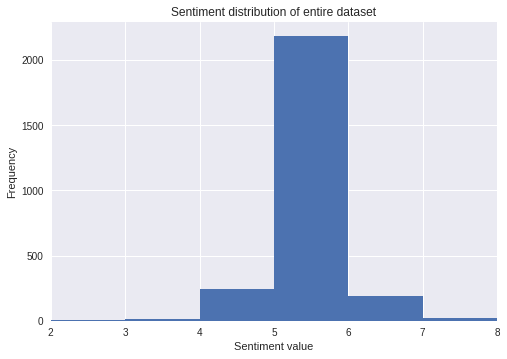

In [ ]:
xbins = np.linspace(np.floor(min_sentiment),np.ceil(max_sentiment), 7)
plt.hist(sentiments, bins=xbins)
plt.xlim(2, 8)
plt.title("Sentiment distribution of entire dataset")
plt.xlabel("Sentiment value")
plt.ylabel("Frequency")
plt.show()

The vast majority of all comments (>2000) is seen to have a sentiment value between 5 and 6. The most negative and the most postive comment is displayed below:

In [ ]:
columns = ["Most negative comment", "Most positive comment"]
comment_examples = [[min_comment, max_comment]]
dfview = pd.DataFrame(data=comment_examples, columns=columns)
dfview

Most negative comment Most positive comment
0           Corruption.          Outstanding!

The two extreme comments are very sparse text-wise and consist of only of single words which has a negative and a positive connotation respectively. Their sparsity is likely what makes them extreme: It is likely that had the author added more words, they would have been drawn towards the mean as well. 

In [ ]:
auth = [users[np.argmin(sentiments)], users[np.argmax(sentiments)]]
fsub = [df["from_subreddit"].iloc[np.argmin(sentiments)], df["from_subreddit"].iloc[np.argmax(sentiments)]]

comment_authors = {"Most negative author": [auth[0], fsub[0]], 
                    "Most positive author": [auth[1], fsub[1]]}

print(df["from_subreddit"].iloc[np.argmax(sentiments)])

dfview = pd.DataFrame(data=comment_authors, index=["user_name", "from_subreddit"])
dfview

biden


Most negative author Most positive author
user_name              tankifaruk_9              ree_san
from_subreddit                trump                biden

It can be seen that the most negative user was commenting on a thread in r/DonaldTrump where as the most positive comment was on a thread in r/JoeBiden. Now we will consider the sentiments in the users from each of the subreddits:

In [ ]:
def get_users_comments_sentiments(dataframe, from_subreddit):
  temp_df = df[df["from_subreddit"]==from_subreddit]
  users = [u for u in temp_df["user"]]
  comments = [c for c in temp_df["comment"]]
  sentiments = [s for s in temp_df["comment_sentiment"]]
  return users, comments, sentiments

t_users, t_comments, t_sentiments = get_users_comments_sentiments(df, "trump")
b_users, b_comments, b_sentiments = get_users_comments_sentiments(df, "biden")

indices = ["minimum sentiment value", 
           "maximum sentiment value", 
           "average sentiment value", 
           "standard deviation"]
fsub = ["Trump", "Biden"]

def get_stats(sentiments):
  min = round( np.min(sentiments), 2)
  max = round( np.max(sentiments), 2)
  avg = round( np.mean(sentiments), 2)
  std = round( np.std(sentiments), 2)
  return [min,max,avg,std]


cstats = {fsub[0]: get_stats(t_sentiments), fsub[1]:get_stats(b_sentiments)}
dfview = pd.DataFrame(data=cstats, index=indices)
dfview

Trump  Biden
minimum sentiment value   2.14   2.92
maximum sentiment value   7.80   7.92
average sentiment value   5.38   5.47
standard deviation        0.48   0.42

From these statistics it can be seen that at face value the sentiment of the comments is very similar still with a rather neutral mean. We can take a further look by comparing the sentiment values of the two user groups in a boxplot:

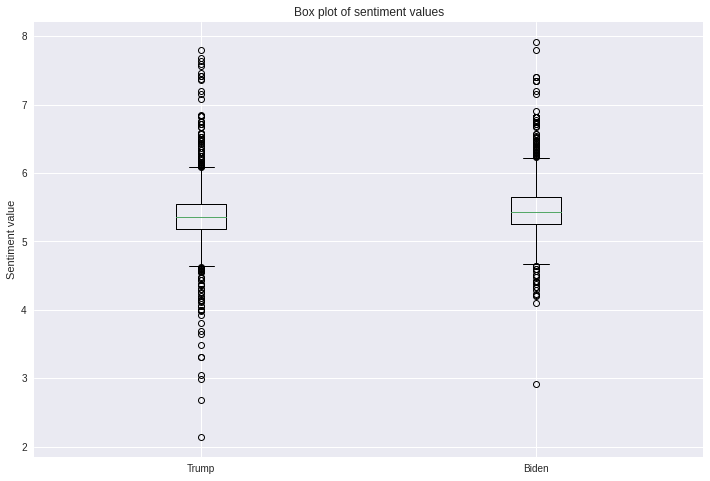

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
ax.boxplot([t_sentiments, b_sentiments])
ax.set_title("Box plot of sentiment values")
ax.set_ylabel("Sentiment value")
ax.set_xticklabels(["Trump", "Biden"])
fig.show()

The boxplot above shows that the sentiments in the comments of the two groups of users are very similar. The median sentiment value (green line) and quartiles (upper and lower borders of the boxes) can be seen to be just slightly higher for the Biden users' sentiment values without seeming as a very significant difference.

We see that the Biden data is a little more centered (expected from the lower standard deviation presented above) and also that the Trump sentiment data has visibly more outliers on both extremes (i.e. the data points beyond the whiskers which as default denote 1.5 times the inner quartile range from the median) compared to the Biden sentiment data. 

This last point may be interesting for further analysis. Based on the observation above we want to filter the observations into a negative, middle and positive sentiment segment. It will be interesting to do because we can then investigate what they are talking about on the relative extremes of the dataset in section 3.4.2 on natural language processing. 

In order to filter the data points we define the function `iqr_filter`in the code block below:

In [ ]:
def iqr_filter(sentiment_values, c=1.5):
  median = np.median(sentiment_values)
  q3, q1 = np.percentile(sentiment_values, [75,25])
  iqr = q3-q1
  negative = []
  positive = []
  midlevel = []
  for idx, sentiment_value in enumerate(sentiment_values):
    if sentiment_value <= (median - c*iqr):
      negative.append(idx)
    elif sentiment_value >= (median + c*iqr):
      positive.append(idx)
    else:
      midlevel.append(idx)
  return negative, midlevel, positive


This function takes a list of computed sentiment values and a constant `c` as input. 

It then classifies a sentiment value $s_{value}$ as a negative outlier if

$$
s_{value} \leq M - c\cdot IQR
$$

and as a positive outlier if 

$$
s_{value} \geq M + c\cdot IQR,
$$

where $M$ denotes the median of the sentiment values and IQR denotes the length between the third and first quartile i.e. $IQR = Q3 - Q1$ and IQR itself is an abbreviation of inter-quartile range. As is seen from the criteria, the parameter $c$ controls the width of the interval around the median. In the present case, we will use the conventional boxplot value of c=1.5 to find the outliers. Every sentiment value that is inside the interval will be classified as a middle sentiment value. 

In [ ]:
c = 1.5
tneg, tmid, tpos = iqr_filter(t_sentiments, c=c)
bneg, bmid, bpos = iqr_filter(b_sentiments, c=c)

def segment_mean(segment, option):
  assert option in ["t", "b"]
  if option == "t":
    mean_value = np.mean([t_sentiments[idx] for idx in segment])
    return round(mean_value,2)
  elif option == "b":
    mean_value = np.mean([b_sentiments[idx] for idx in segment])
    return round(mean_value,2)

segstats = {"Negative segment (n,mean)" : [(len(tneg), segment_mean(tneg, "t")), 
                                   (len(bneg), segment_mean(bneg, "b"))], 
            "Middle segment (n, mean)": [(len(tmid), segment_mean(tmid, "t")), 
                                   (len(bmid), segment_mean(bmid, "b"))],
            "Positive segment (n, mean)": [(len(tpos), segment_mean(tpos, "t")), 
                                   (len(bpos), segment_mean(bpos, "b"))]}

dfview = pd.DataFrame(data=segstats, index=fsub)
dfview

Negative segment (n,mean)  ... Positive segment (n, mean)
Trump                (78, 4.36)  ...                (117, 6.35)
Biden                (46, 4.56)  ...                (107, 6.43)

[2 rows x 3 columns]

We see that there are a fair amount of outliers to consider at the relative extremes of the data. As we expected from the boxplot the grand majority of the sentiment values in both user groups fall within the middle segment, and also we can confirm that there are more extreme Trump sentiment values than Biden values. In total there are 195 Trump outliers and 153 Biden outliers. 

### 3.4.2 Natural Language Processing


#### 3.4.2.1 Motive

In this section we want to dive into the comments to see what the users in different user groups are talking about. The user groups whose comments we want to investigate has been found during the work in the project so far:

1. r/JoeBiden and r/DonaldTrump users
2. Louvain partitioning of B (section 3.2.2)
3. Sentiment partitioning (section 3.4.1)


The partitioning (1) into users from r/JoeBiden and r/DonaldTrump will be seen as the foundation for two main documents on which we will carry out a natural language processing investigation. The two main documents will be the entire corpora of r/JoeBiden user comments and r/DonaldTrump user comments respectively. 


Here we want to explore different statistics about the two comment documents.
This will provide an insight into various points of interest about the two user groups. We will investigate where the lexical diversity is highest, i.e. which user group has the more varied language. It will also be investigated which words are the most frequent and finally we also want to take a look at common words appearing together in the text, known as collocations or bigrams as this will give an additional indication of which themes the two user groups are discussing. 

After this investigation we want to illustrate what is going on in the other partitionings of the users by making WordClouds. WordClouds are a really great way to condense and convey a lot of the information of more thorough text analysis aiming to find themes in the text as the most commonly used words in a text will be depicted with a size that varies with the degree of its usage. For the user groups in (1) this will be done by way of a TFTR analysis and for the user groups in (2) and (3) we will use a TFIDF analysis to make the word clouds. 


#### 3.4.2.2 Tools

In this section we will draw on tools from the Python NLTK package. NLTK stands for Natural Language Toolkit and information on the toolkit can be found at https://www.nltk.org. 

First we want to create documents given a set of comments in a user group. To this end we write the following helper function `get_document`:



In [ ]:
def get_document(comments):
  document = []
  for comment in comments:
    tokens = comment_to_tokens(comment)
    document += tokens
  return document

`get_document` takes a list of comments as input and converts them to tokens. The tokens are then added to the list `document` which is simply a list holding all the consecutive tokens of the comments. 

The document can afterwards be turned into a NLTK Text object which holds a number of convenient functions which will be used to explore the document. We want to use:

1. `nltk.text.concordance`: Given some word this function displays a number of contexts in the document which the word appears. This will provide information on how words of interest are used in the document.

2. `nltk.text.collocations`: This functions finds bigrams in the text, i.e. word pairs that commonly appear together. As we will se this is a nice way to find themes of the comments.

3. `nltk.freqdist`: Given a document this function returns the set of unique words in the document along with the number of times the word has appeared, i.e. a frequency distribution of the words in the document.

In order to make the frequency distribution we want to be able to collapse plurals conjugations of words in order to narrow in the set of unique words to make the count more focused. Also we want to be able to remove so-called stopwords in English from the document as these are not very informative. 

Examples of stopwords in English can be seen in the code block below:

In [ ]:
print(stopwords.words("english")[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


To be able to perform these filtrations we create the helper functions `wordnet_pos_tag`, `lemmatize_document` and `filter_stopwords`:

In [ ]:
# http://www.nltk.org/book/ch05.html
def wordnet_pos_tag(tag):
    if tag in ["JJ", "JJR", "JJS"]:
        return wordnet.ADJ
    elif tag in ["NN", "NNS", "NNP", "NNPS"]:
        return wordnet.NOUN
    elif tag in ["RB", "RBR", "RBS"]:
        return wordnet.ADV
    elif tag in ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]:
        return wordnet.VERB
    return None
    
def lemmatize_document(document):
  lemmatizer = nltk.WordNetLemmatizer()
  document = nltk.pos_tag(document)

  lemmatized_document = []
  for (token, pos_tag) in document:
    pos_tag = wordnet_pos_tag(pos_tag)
    if pos_tag is not None:
      lemmatized_token = lemmatizer.lemmatize(token, pos=pos_tag)
      lemmatized_document.append(lemmatized_token)
    else:
      lemmatized_token = lemmatizer.lemmatize(token)
      lemmatized_document.append(lemmatized_token)

  return lemmatized_document

def filter_stopwords(document):
  stopword_list = stopwords.words("english")
  filtered_document = []
  for token in document:
    if token not in stopword_list:
      filtered_document.append(token)
  return filtered_document

`lemmatize_document` takes a document as input and loops over the tokens of the document. For each token a POS tag is assigned to the token with the NLTK function `nltk.pos_tag`. 

POS means part of speech and basically means the word category, i.e. "cats" is a noun and "running" is a verb. The token and the POS tag is then passed to a WordNetLemmatizer as the lemmatization of a word depends on its POS tag which as default is set to noun:

In [ ]:
lemmatizer_example = nltk.WordNetLemmatizer()
word_examples, pos_examples = ["cats", "running"], [wordnet.NOUN, wordnet.VERB]

for word in word_examples:
  print(f"- POS tag: {word} becomes {lemmatizer_example.lemmatize(word)}")

for word, pos in zip(word_examples, pos_examples):
  print(f"+ POS tag: {word} becomes {lemmatizer_example.lemmatize(word, pos)}")

- POS tag: cats becomes cat
- POS tag: running becomes running
+ POS tag: cats becomes cat
+ POS tag: running becomes run


Details on the lemmatization algorithm itself can be found at (https://wordnet.princeton.edu/documentation/morphy7wn) which is the lemmatization algorithm WordNetLemmatizer implements. The function `filter_stopwords` simply checks if the words of the document is an English stop word and only appends a word to the filtered document if it is not a stop word. 

To compute the lexical diversity of a document we implement the following helper function:

In [ ]:
# https://www.nltk.org/book/ch01.html
def lexical_diversity(text):
  return len(set(text)) / len(text)

The function `lexical_diversity` divides the number of unique words in a text with the number of total words. This means that the lexical diversity is in the range 0 to 1 where 1 is the most lexically diverse. Lexical diversity then is a measure of how varied a text is as it will be low if the same words are repeated again and again and vice versa.

For the WordCloud section first we want to compute a TF-TR score for the words in the r/JoeBiden and r/DonaldTrump user group comments. TF-TR denotes term frequency term ratio we will implement the function `TFTR` to calculate these scores in the code block below.

This function calculates the term-frequency term-ratio weights $w_t$ for all tokens $t$ in the two frequency distributions from Biden, $b$, and Trump, $d$:

$$
w_t^{(b)} = \frac{TF_t^{b}}{TF_t^{t}+c} \quad \text{and} \quad w_t^{(t)} = \frac{TF_t^{t}}{TF_t^{b}+c},
$$

where $c$ denotes some constant to avoid dividing by zero. Also $c$ has a normalizing effect. For instance, say some term  has a frequency of 3 in the Biden comments and 0 times in the Trump comments. Then with $c=1$, it would have weight 3. This means with $c$ we can control the weights. To see this: If $c=100$, then a term in the Biden comments which is not mentioned in the Trump comments would need a frequency of 300 to achieve a weight of 3 (Heshe, Græsholt, Tommerup, assignment 2). 

In [ ]:
def TFTR(trump_tokens, biden_tokens, c):
    t_tf = nltk.FreqDist(trump_tokens)
    b_tf = nltk.FreqDist(biden_tokens)
    t_tftr = []
    b_tftr = []
    for (token, t_freq) in t_tf.items():
        b_freq = b_tf[token] # returns zero if token is not in frequency dist

        t_wt = t_freq / (b_freq + c)
        b_wt = b_freq / (t_freq + c)

        t_tftr.append((token,t_wt))
        b_tftr.append((token,b_wt))

    return t_tftr, b_tftr

def get_freq_string(tftr):
  freq_string = ""
  for (token, score) in tftr:
    token = token.replace("-", "")
    score = round(score)
    freq_string += score * (token + " ")
  return freq_string

Next we will need to be able to calculate so-called TF-IDF scores. This stands for term frequency (TF) and inverse document frequency (IDF). These scores is calculated as the product between the TF and the IDF. 

The TF is calculated as:

$$
\text{tf}(t,d) = \frac{f_{t,d}}{\sum_{t' \in d} f_{t',d}},
$$

where $f_{t,d}$ denotes the frequency of term $t$ in document $d$ and $t' \in d$ denotes the set of terms in $d$. As can be seen the term frequencies in a document is normalized by dividing with the total sum of term frequencies in the document. This is done in order to adjust the effect of any term with some probability of appearing in a document having a higher frequency simply because there are more terms in the document (Heshe, Græsholt, Tommerup, assignment 2).

Our implementation of this calculation can be seen in the code block below:

In [ ]:
def normalized_tfs(documents):
  normalized_tfs = {}

  # enumerate documents d in set of documents D
  for idx, d in enumerate(documents):
    # calcalute frequency distribution
    tf = nltk.FreqDist(d)

    # divide the term frequencies by the length of the document in which they appear
    normalized_tf = {}
    for t, f in tf.items():
      f = f / len(d)
      normalized_tf[t] = f

    # keep adjusted term-frequencies for each community
    normalized_tfs[idx] = normalized_tf
  return normalized_tfs

The IDF part is calculated by:

$$
\text{idf}(t,D) = \log\big(\frac{N}{\sum_{d \in D}n_{t,d}}\big)
$$

where N is the cardinality of the set of community documents $D$ and $n_{t,d}$ is an indicator function such that:

$$
n_{t,d} = 
\begin{cases} 
0 \quad \text{if term t is not in document d}\\
1 \quad \text{if term t is in document d}
\end{cases}
$$

Our implementation of the IDF can be seen in the code block below. Since in the way the implementation is set up there where the keys that are checked are keys found from the documents there is no need for smoothing the denominator as it will always be at least 1 (Heshe, Græsholt, Tommerup, assignment 2).

In [ ]:
def idfs(normalized_tfs):
  ntfs = normalized_tfs
  N = len(ntfs) # number of documents in D
  idf = {}

  # loop over term-frequency dicts
  for tfs in ntfs.values():

    # loop over terms in term-frequency dicts
    for term,_ in tfs.items():

      # check if term is already in idf
      if term not in idf.keys():
        nt = 0

        # count the number of documents in D in which the term appear
        for tfs in ntfs.values():
          if term in tfs.keys():
            nt += 1
        
        # calculate idf(t,D) for term
        idf[term] = math.log( (N) / (nt))
  return idf

The TF-IDF can then be computed by multiplying the term frequencies in the communities by their inverse document frequency, i.e:

$$
\text{tfidf}(t,d,D) = \text{tf}(t,d) \cdot \text{idf}(t,D)
$$

This is done in the code block below which returns a dictionary with the tf-idf scores for different groups or communities.

In [ ]:
def tfidfs(atfs, idf):
  tfidfs = {}

  # enumerate the adjusted term-frequency dicts
  for idx, atf in enumerate(atfs.values()):
    tfidf = atf.copy()

    # multiply tf values with the corresponding idf value for term
    # and insert to dictionary
    for k, v in atf.items():
      tfidf[k] = v * idf[k]
    
    # keep tf-idfs for each community
    tfidfs[idx] = tfidf
  return tfidfs

Finally we will be using the visualization library WordCloud, information on this library can be found at http://amueller.github.io/word_cloud/.

#### 3.4.2.3 Results and discussion



##### 3.4.2.3.1 Natural Language Processing

First we will create the two main documents from the comments of the users of r/DonaldTrump and r/JoeBiden which we extracted in section 3.4.1.3: 

In [ ]:
# Load raw documents
t_document = get_document(t_comments)
b_document = get_document(b_comments)

def getlens(doc):
  return (len(doc), len(set(doc)))

def get_docstats(document):
  doc, lem, stop = document, lemmatize_document(document), filter_stopwords(document)
  lemstop = lemmatize_document(stop)
  rawlen, lemlen, stoplen, lemstoplen = getlens(doc), getlens(lem), getlens(stop), getlens(lemstop)
  return rawlen, lemlen, stoplen, lemstoplen

traw, tlem, tstop, tlemstop = get_docstats(t_document)
braw, blem, bstop, blemstop = get_docstats(b_document)

docstats = {"Raw":[traw, braw], "Lemmatized (L)":[tlem, blem], "StopwordsRemoved (S)":[tstop,bstop], "(L) + (S)":[tlemstop,blemstop]}
dfview = pd.DataFrame(data=docstats, index=["r/DonaldTrump", "r/JoeBiden"])
dfview

Raw Lemmatized (L) StopwordsRemoved (S)      (L) + (S)
r/DonaldTrump  (29211, 4834)  (29211, 4020)        (15182, 4676)  (15182, 3889)
r/JoeBiden     (35822, 5063)  (35822, 4224)        (18586, 4903)  (18586, 4131)

In the DataFrame printed above each tuple entry represents: (document length, unique words). Hereby we see the effects on the document lengths and the number of unique words in the documents that follows from lemmatizing and removing stop words. 

The lexical diversity of the lemmatized and stop-words filtered comments in the two user groups is shown below. We consider the filtered comments in order to remove some noise in the estimation of the diversity. Plurals, conjugations and stopwords are not very informative when judging lexical diversity as we want to take it as an estimate of which group of users has the largest vocabulary. As such it seems evident that if you know the word "cat" then you also know "cats" and no information is lost in lemmatizing. Likewise for stopwords: It is not a controversial assumption that every knows these so again we don't lose any information but rather remove noise:

In [ ]:
# Filter documents
tfiltered = lemmatize_document(filter_stopwords(t_document))
bfiltered = lemmatize_document(filter_stopwords(b_document))

trump_diversity = lexical_diversity(tfiltered)
biden_diversity = lexical_diversity(bfiltered)

dfview = pd.DataFrame(data={"r/DonaldTrump":[round(trump_diversity,2)], "r/JoeBiden":[round(biden_diversity,2)] }, index=["Lexical diversity"])
dfview

r/DonaldTrump  r/JoeBiden
Lexical diversity           0.26        0.22

We see that that both user groups' comments gets a rather low diversity score. For the Trump comments a less than a third of the words are unique, where as for the Biden comments just over one fifth of the words are unique. 

Now we want to look at the frequency distributions of the lemmatized documents with stop words removed:

In [ ]:

# Compute frequency distributions
t_fdist = nltk.FreqDist(tfiltered)
b_fdist = nltk.FreqDist(bfiltered)

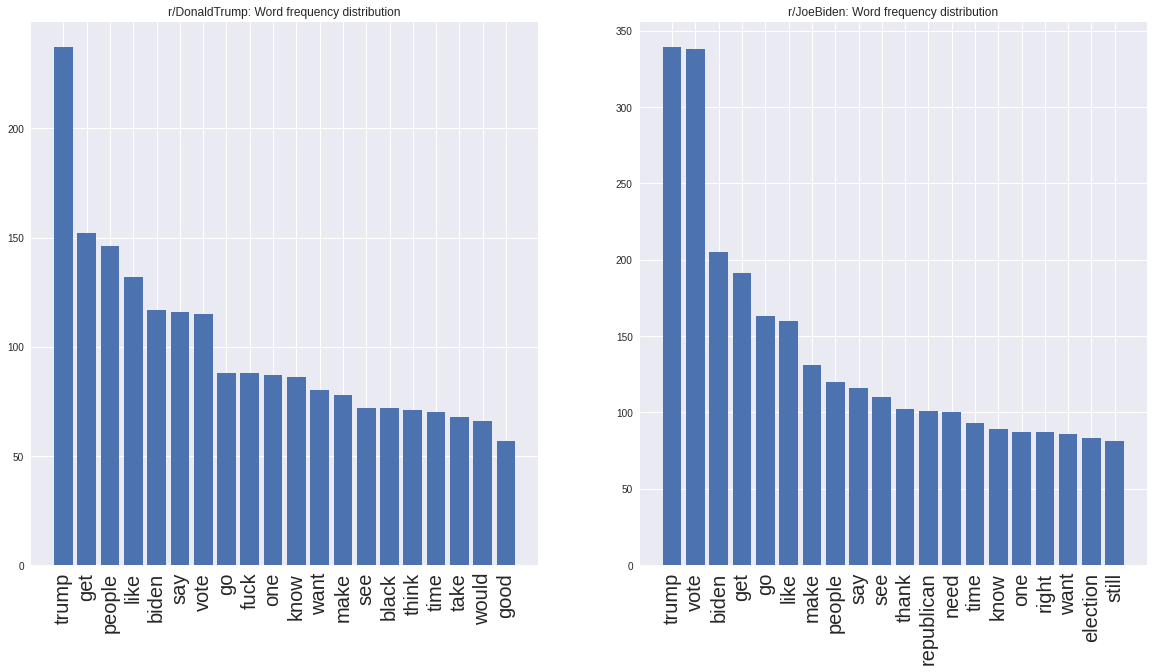

In [ ]:
titles = ["r/DonaldTrump", "r/JoeBiden"]
fdists = [t_fdist, b_fdist]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
n_most_common=20
for idx, ax in enumerate(axes):
  fdist = fdists[idx]

  x = range(1, n_most_common+1)
  xlabels = [k for k, v in fdist.most_common(n_most_common)]
  heights = [v for k, v in fdist.most_common(n_most_common)]

  ax.bar(x, heights)
  ax.tick_params(axis="x", rotation=90, labelsize=20)
  ax.set_xticks(x)
  ax.set_xticklabels(xlabels)
  ax.set_title(titles[idx] + ": Word frequency distribution")

fig.show()

The frequency distribution plots show the 20 most common words in the comments on the two subreddits.

We see that the term "trump" is the most used word in both distributions, whereas the term "biden" is on respectively a fifth place and a third place.  This can probably be explained by the fact that Trump is arguably the more controversial of the two candidates and he generates a lot of talk about him in most social circles. It is however quite funny to see that in absolute terms the comments on the Biden subreddit has actually mentioned him about 100 times more than on the subreddit dedicated to Trump. 

Also the word "vote" is mentioned a lot. Mostly in the Biden comments with over 300 mentions and a little less than 100 mentions in the Trump comments. Maybe this indicates a larger sense of the "urgency" of voting for the Biden commenters compared to the Trump commenters.

The word "fuck" is featured prominently among the Trump comments with around 85 mentions, almost on par with the word "thank" among the Biden comments that has around 100 mentions here. This indicates that the language on the Trump subreddit may be a little coarser compared to the language on the Biden subreddit. 

The word "black" is featured in the top 20 in the comments from the Trump subreddit, but does not enter in the top 20 in the Biden comments. We can investigate in which contexts the word "black" appears in the comments by using the function `nltk.concordance` on the raw documents:

In [ ]:
t_text = nltk.Text(t_document)
b_text = nltk.Text(b_document)

print("Trump contexts: ")
t_text.concordance("black")
print("\n")
print("Biden contexts: ")
b_text.concordance("black")


Trump contexts: 
Displaying 25 of 66 matches:
ement take names from football teams black lady off syrup black man off rice bl
 football teams black lady off syrup black man off rice black man off cookies b
ck lady off syrup black man off rice black man off cookies boycotted mexican pr
 but it s also a ton of racist angry black folks too actually there was a party
 are a nazi and a racist s she ain t black s like they don t realize that white
 trump that way she would be a young black madame president and let s see how d
anization blm exactly they are using black people as accessories and many dont 
sues hey a bunch of the soldiers are black oh why not be more specific what kin
is is getting fun how he's obviously black so he clearly didn't vote for trump 
 can't wait for the libs to pull his black card lol if i could upvote this many
ning jk no i m not cnn trump hired a black lawyer and didn't pay i like the zer
elling tupac then went and locked up black guys for possession listen fat 

It is maybe not too surprising that in two subreddits on American politics the term "black" seem to exclusively be in the context of referring to the demographic of black American people. For good or for worse then, in our sample of comments from the two subreddits the Trump subreddit seem to speak more about this demographic. 

Another word which turned out to be quite interesting was the word "racist". The concordances of this word is shown below:

In [ ]:
print("Trump contexts: ")
t_text.concordance("racist")
print("\n")
print("Biden contexts: ")
b_text.concordance("racist")

Trump contexts: 
Displaying 25 of 26 matches:
hose things b-but the left can t be racist they don t hold institutional power
merica sorry but it s also a ton of racist angry black folks too actually ther
f you disagree you are a nazi and a racist s she ain t black s like they don t
part yup code switch on npr is more racist worse it's tax-funded kinda love th
me how the democrats and blm are so racist and no one can see it on the left t
 the democrats repeat we re not the racist ones over and over and everyone fal
premacist and democrats actually do racist things yet are called progressive t
e this country and the other guy is racist also biden you're not black if you 
break down the barriers of the evil racist patriarchy and that s it that s all
indian than usual lol donald reagan racist joe biden calling black people pred
 truth white democrats are the most racist group in history i and many black m
at work from owner gold staci seems racist lol indians love trump good luck fi
facts 

The observation we find interesting here is that it can be seen that the Trump commenters definitely seem to think that both Democrats and also Joe Biden is racist: 

Among the Trump comments we can see the excerpts:
> democrats actually do racist things yet are called progressive

> racist joe biden

> white democrats are the most racist group in history

Among the Joe Biden comments it is a little more subtle as to who exactly is called a racist as they don't mention names or parties directly in the excerpts:

> a racist president and his racist bigoted policies

> leave the 68 million racist bigots behind

> getting his political start on the racist lie that was birtherism

However it does not seem unlikely that the president referred to was the president at the time of the writing of the comment (check for example https://en.wikipedia.org/wiki/Racial_views_of_Donald_Trump). 

The "68 million racist bigots" very likely refer the count of people that had voted for Trump at one point during the 2020 election. The headlines with this number came out November 5th, about a week before we began scraping data from the subreddits: (see e.g https://www.afr.com/world/north-america/trump-s-68-million-votes-send-a-message-20201105-p56bts) 

Also we see an accusation that someone "got his political start on the racist lie that was birtherism". If we look into the strange last word on Google "birtherism" is a term that denotes the conspiracy theory that former president Barack Obama is not an American citizen (see https://en.wikipedia.org/wiki/Barack_Obama_citizenship_conspiracy_theories) for which Donald Trump was a very "prominent promoter" as it says in the Wikipedia article. 

In total this means that the users on r/DonaldTrump seem to think that the Democrats and Joe Biden are racists and at the same time the users on r/JoeBiden seem to think that Donald Trump and the people who vote for him are racists. 

Now we want to investigate frequently appearing bigrams or word pairs in the both the raw and filtered document. First for the comments from r/DonaldTrump:

In [ ]:
print("Raw collocations:")
t_text.collocations()

print("\n")
print("Lemmatized, no-stop words collocations")
tfiltered_text = nltk.Text(tfiltered)
tfiltered_text.collocations()

Raw collocations:
https www; supreme court; trump supporters; trump 2020; 100 000; fact
check; donald trump; social media; bang bang; criminal suspect; new
york; www youtube; big tech; fairfax county; holy shit; united states;
youtube com; traffic hazard; human trafficking; god bless


Lemmatized, no-stop words collocations
http www; trump supporter; wear mask; supreme court; fact check; mail
ballot; ketchup steak; 100 000; trump 2020; bang bang; social medium;
new york; vote trump; donald trump; www youtube; fairfax county; sound
like; criminal suspect; youtube com; big tech


We observe that there are some slight differences in the two lists of collocations as a result of new more frequent bigrams appearing after  lemmatizing the words, but they are largely the same. 

There are some non-informative similarities resulting from a frequent sharing of links e.g. "http www" and "www youtube". 

We see that another similiarity is the bigrams "100 000" and "fairfax county" and these two bigrams are likely related. During the election a Twitter post (falsely, according to Snopes) claimed that 100,000 votes had been "given" to Biden in Fairfax County, Virginia (see e.g. https://www.snopes.com/fact-check/fairfax-gave-biden-extra-votes/) 

Some interesting differences is the appearance of "wear mask" and "ketchup steak" in the lemmatized, stop-words filtered collocations. These likely show up as e.g. "wearing mask" and "wears mask" probably has appeared many times and now has been collapsed into "wear mask" and have become one of the most frequent collocations. "wear mask" is very likely because of the on-going Corona pandemic. 

"ketchup steak" on the other hand is more cryptic, so we should take a look at the contexts of either "ketchup" or "steak":

In [ ]:
t_text.concordance("ketchup")

Displaying 7 of 7 matches:
e see you too election interference ketchup on steak is big cringe but i d die 
e trump 2020 ok lets not joke about ketchup on steak plz biden center is being 
nd tds is obviously quite real maga ketchup on steak is a big deal for trump wi
t a fart in the wind if you ask cnn ketchup is presidential and commendable rem
ntable when you go to vote remember ketchup is red as in red white and blue dij
 the statement is true exactly this ketchup on steak should put him in jail esp
cambridge analytica cough cough tbh ketchup on steak does suck ass though funny


We see that the contexts are mainly to pour "ketchup" on a "steak" and that

> ketchup on steak is a big deal for trump

Looking into this on Google it turns out that Donald Trump prefers to eat his steak well-done with ketchup (see e.g. https://www.businessinsider.com/how-presidents-eat-steak-2018-2?r=US&IR=T)

Now we can take a look at the collocations in the Biden comments:

In [ ]:
print("Raw collocations:")
b_text.collocations()

print("\n")
print("Lemmatized, no-stop words collocations")
bfiltered_text = nltk.Text(bfiltered)
bfiltered_text.collocations()

Raw collocations:
https www; imgur com; fox news; supreme court; john lewis; electoral
college; make sure; big tent; ballottrax net; trump supporters; town
hall; united states; voter suppression; four years; gay marriage;
absentee check; https imgur; donald trump; joe biden; year old


Lemmatized, no-stop words collocations
http www; supreme court; imgur com; fox news; john lewis; electoral
college; ballottrax net; trump supporter; town hall; http imgur; big
tent; gay marriage; four year; voter suppression; make sure; country
party; absentee check; check status; white house; donald trump


The differences between the raw collocations and the lemmatized ones are a little subtler for these comments. We see that a bigram with a verb i.e. "make sure" has made it way to the most frequent collocations. Again the reason is like above that a multitude of conjugations with the very common English expression "to make sure" has been collapsed into the verb "make" in infinitive, consider the following example:

In [ ]:
lemmatize_document(["make", "makes", "making", "made"])

['make', 'make', 'make', 'make']

We see that the Biden comments seem to mention topics as "gay marriage", "john lewis", "big tent", "voter suppression" a lot. 

Gay marriage is rather self-explanatory. John Lewis was a civil rights leader and Democrat who passed away just recently in July 2020. "big tent" is an American expression for encouraging a broad spectrum of views in a Political party. 

"Voter suppression" means a strategy to discourage voters to acutally vote. There are 8 matches for this bigram:

In [ ]:
b_text.concordance("suppression")

Displaying 8 of 8 matches:
t us because of the rampant voter suppression and all the other crap what a clo
the far right and enforcing voter suppression methods anti-maskers and anti-vax
 they'd probably have a new voter suppression ad out by tomorrow i'm like half-
wn to this one vote this is voter suppression no one should have to do what you
out this sort of outrageous voter suppression our democracy is in serious troub
s way folks if there was no voter suppression and gop shenanigans we would have
 purging voter intimidation voter suppression in general and many more examples
ike this cannot account for voter suppression and that orange windbag has been 


It seems that in the sample of comments has been a concern for this during the election period. From scanning Google it seems that this is connected to the fact that the Corona pandemic has forced the American voters to vote-by-mail which has meant record numbers in mail votes and ensuing distributive challenges which could be interpreted as deliberate. 

We can also see that "ballottrax net" is also very frequent and this also has to do with voting by mail: It allows voters to track their mail-in ballots on every step on the way to being counted (https://ballottrax.com/). 

Thus it seems that in several ways the vote-by-mail issue has given rise to discussion among the Biden commenters to a larger degree than with the Trump commenters. 

Also as an additional observation, it seems that Biden commenters share information via https://imgur.com/ as this is a collocation while we saw above that it seems the Trump commenters use https://youtube.com more.  

##### 3.4.2.3.2 TF-TR and TF-IDF 

Now we will apply the TF-TR tool explained in section 3.4.2.2 to the two main documents consisting of two documents put together of comments from r/DonaldTrump and r/JoeBiden in order to create two word clouds. This is done in the code block below:

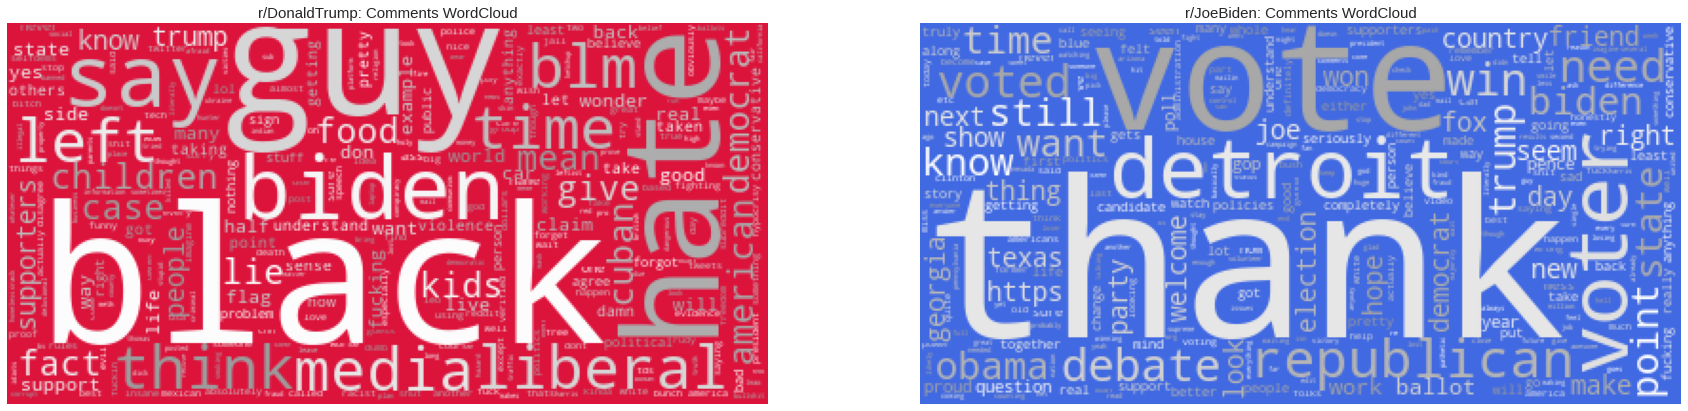

In [ ]:
t_tftr, b_tftr = TFTR(t_document, b_document, c=10)
t_fstring = get_freq_string(t_tftr)
b_fstring = get_freq_string(b_tftr)
t_wc = wordcloud.WordCloud(background_color="crimson", collocations=False, max_words=2000, random_state=42).generate(t_fstring)
b_wc = wordcloud.WordCloud(background_color="royalblue", collocations=False, max_words=2000, random_state=42).generate(b_fstring)
wordclouds = [t_wc, b_wc]
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
titles = ["r/DonaldTrump", "r/JoeBiden"]
for idx, ax in enumerate(axes):
  ax.imshow(wordclouds[idx].recolor(color_func=grey_color_func))
  ax.set_title(titles[idx] + ": Comments WordCloud", fontsize=15)
  ax.axis("off")

fig.show()

As we may have expected from the frequency distribution in section 3.4.2.3.1 the Trump comments have a large score for black which is indicated by the large size of the word. Also we se "blm" which is known to be an abbreviation for the Black Lives Matter movement. This means that black people are visibly more discussed on the r/DonaldTrump subreddit compared to the r/JoeBiden subreddit. The word "hate" also gets a prominent score. Also we can see that the Biden comments make use of the word "thank" a great deal more than the Trump comments do. Also in the Biden comments we see a high score for words that has to do with voting such as "vote", "voted", "voter" and "ballot", so this is an important issue in this group of comments. 

Next we want to extract the partitioning on the backbone network $B$ which we found in section 3.2.2 and perform a tf-idf analysis on the comments from the users in each of the six communities. Therefore we commence by loading $B$ an partitioning with the same random state (i.e. 0) as in section 3.2.2:

In [ ]:
Bpath = "/content/drive/MyDrive/SGAI/BackBone_alpha=0.09.gpickle"
B = nx.read_gpickle(Bpath)

df = pd.read_csv("/content/drive/MyDrive/SGAI/data_all_merged_with_sentiment.csv", sep=";")

In [ ]:
def lcc(network):
  connected_components = nx.connected_components(network)
  network = network.subgraph(list(max(connected_components, key=len)))
  return network

B = lcc(B)
Bpartition = community.best_partition(B, random_state=0)

We will need to map the nodes (which are user names) in each community to the comments by those users. This is done by using the helper functions below where we map a community to its nodes with `communities_to_nodes` and then this mapping is used to map the communities to the comments of the community with `communities_to_comments`. Finally the comments of each community is mapped to a community document with the function `communities_to_documents`: 

In [ ]:
def communities_to_nodes(partition):
  communities_to_nodes = {}

  community_names = set([v for k, v in partition.items()])
  for name in community_names:
    nodes = [key for key, value in partition.items() if value==name]
    communities_to_nodes[name] = nodes
  
  return communities_to_nodes

def communities_to_comments(dataframe, communities_to_nodes):
  temp_df = dataframe.copy()
  users = [u for u in temp_df["user"]]
  comments = [c for c in temp_df["comment"]]

  communities_to_comments = {}
  for community, nodes in communities_to_nodes.items():
    community_comments = []
    for node in nodes: 
      user_index = [idx for idx, u in enumerate(users) if u==node][0]
      comment = comments[user_index]
      community_comments.append(comment)

    communities_to_comments[community] = community_comments
  
  return communities_to_comments

def communities_to_documents(communities_to_comments):
  communities_to_documents = {}
  for community, comments in communities_to_comments.items():
    community_document = get_document(comments)
    communities_to_documents[community] = community_document

  return communities_to_documents

Now we use the helper functions to create a list of the community documents:

In [ ]:
c2n = communities_to_nodes(Bpartition)
c2c = communities_to_comments(df, c2n)
c2d = communities_to_documents(c2c)

documents = [d for c, d in c2d.items()]

Then we are ready to apply the tf-idf tools described in section 3.4.2.2 and use `get_wordcloud_string` to get a list of strings containing the words of the documents in frequencies that corresponds to their tf-idf score:

In [ ]:
_tfs = normalized_tfs(documents)
_idfs = idfs(_tfs)
_tfidfs = tfidfs(_tfs, _idfs)

def get_wordcloud_string(TF_IDF, const):
    wcloud_string = ""
    for x, v in TF_IDF.items():
        x+=" "
        x = x.replace("-", "")
        wcloud_string += x*int(round(v*const))

    return wcloud_string

wclouds = [get_wordcloud_string(tfidf, 1e6) for tfidf in _tfidfs.values()]

These strings can now be used to generate the following WordClouds for the communities:

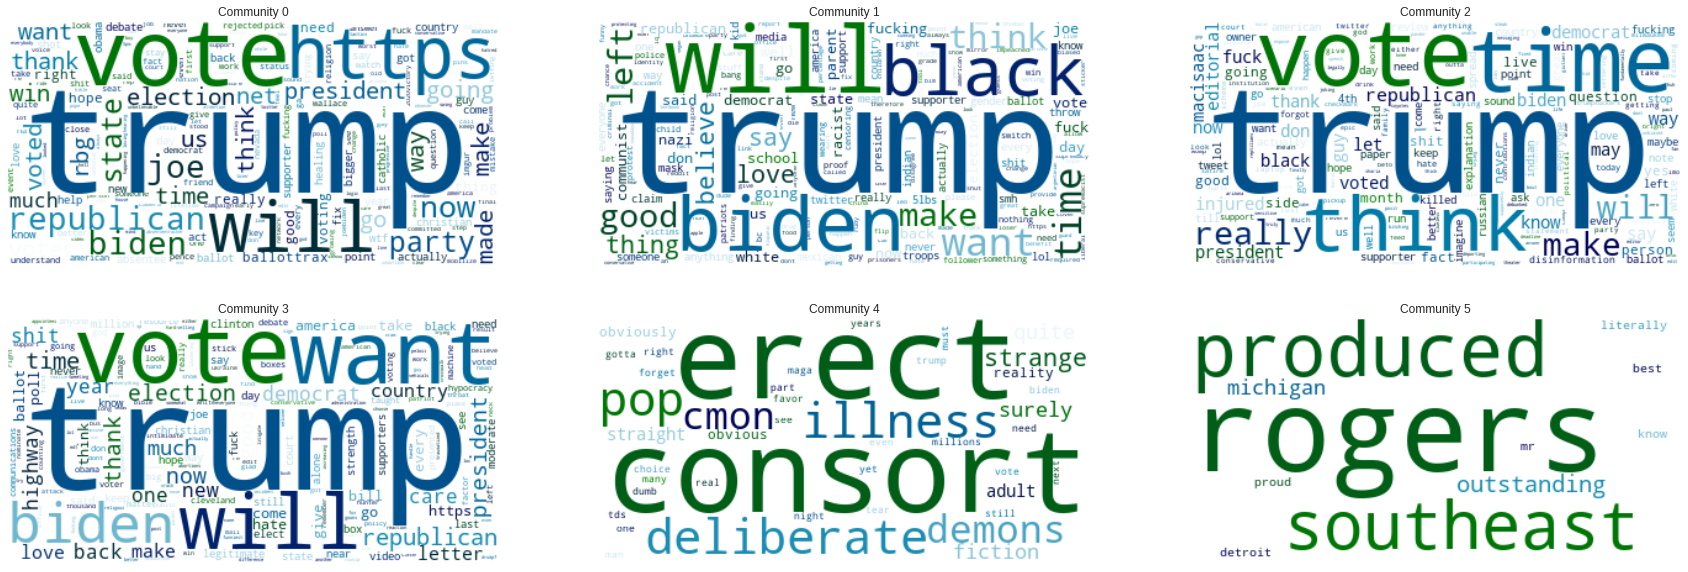

In [ ]:
def get_word_cloud(wcloud):
  return wordcloud.WordCloud(background_color="white", collocations=False, colormap="ocean", random_state=42).generate(wcloud)

def subplots_wordclouds(wordclouds, nrows, ncols):
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30,10))
  row = 0
  cloud_idx = 0
  for ax_row in axes:
    for idx, ax in enumerate(ax_row): 
      ax.set_title(f"Community {cloud_idx}")
      ax.axis("off")
      _wcloud = get_word_cloud(wordclouds[cloud_idx])
      ax.imshow(_wcloud, interpolation='bilinear')
      cloud_idx += 1
    row += 1
  fig.show()

subplots_wordclouds(wclouds, 2, 3)

It is very hard to differentiate between communities 0 through 3. The reason that words that are alike across four communities get a high score none the less is because the last two communities (4 and 5) does not have them. This would mean that the idf becomes

$$
idf(\text{"trump"}, D) = \log(\frac{N=6}{n_t=4}) \approx 0.41
$$

and since the term frequency of "trump" is very high (see the frequency distribution in section 3.4.2.3.1) this not very specific word ends up with a high score none the less. In order to ameliorate this we would likely have to come up with another scoring scheme here. Also we saw in the frequency distributions that the most used words are very uniform. Therefore it makes sense that this partitioning based on modularity maximization on the network is not too informative. The two last communities are very small (see section 3.2.2.3) and so their rather few and enigmatic words stand out from the rest. We see that the most positive comment which we looked at in section 3.4.1.3 namely the comment by user ree\_san which just said "Outstanding!" is likely seen in community 6. 

Lastly we want to explore the comments from the different sentiment segments resulting from the IQR-filtering that we showed in section 3.4.1.3. Therefore we first load in the comments where the sentiment value is not `nan` and afterwords we use the function `iqr_filter` to segment into indices for the sentiment segments. This indices are then used to extract the corresponding comments in the function `segment_comments`. Finally six documents are created using `get_document`. 

All this happens in the following code block:

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/SGAI/data_all_merged_with_sentiment.csv", sep=";")
df = df[df["comment_sentiment"].isna()==False]

t_users, t_comments, t_sentiments = get_users_comments_sentiments(df, "trump")
b_users, b_comments, b_sentiments = get_users_comments_sentiments(df, "biden")

c = 1.5
tneg, tmid, tpos = iqr_filter(t_sentiments, c=c)
bneg, bmid, bpos = iqr_filter(b_sentiments, c=c)

def segment_comments(segment_indices, comments):
  seg_idx = segment_indices
  seg_com = [comments[idx] for idx in seg_idx]
  return seg_com

def all_segment_comments(segments, comments):
  seg_coms = []
  for s in segments:
    seg_coms.append(segment_comments(s, comments))
  return seg_coms[0], seg_coms[1], seg_coms[2]

tneg_c, tmid_c, tpos_c = all_segment_comments([tneg, tmid, tpos], t_comments)
bneg_c, bmid_c, bpos_c = all_segment_comments([bneg, bmid, bpos], b_comments)

tneg_doc = get_document(tneg_c)
tmid_doc = get_document(tmid_c)
tpos_doc = get_document(tpos_c)
bneg_doc = get_document(bneg_c)
bmid_doc = get_document(bmid_c)
bpos_doc = get_document(bpos_c)

Next we load the documents into a list and perform the tf-idf steps as described above:

In [ ]:
sentiment_documents = [tneg_doc, tmid_doc, tpos_doc, bneg_doc, bmid_doc, bpos_doc]
sentiment_tfs = normalized_tfs(sentiment_documents)
sentiment_idfs = idfs(sentiment_tfs)
sentiment_tfidfs = tfidfs(sentiment_tfs, sentiment_idfs)
sentiment_wclouds = [get_wordcloud_string(tfidf, 1e6) for tfidf in sentiment_tfidfs.values()]

Then the WordClouds are put into a 2 by 3 subplot with the help of a couple of functions:

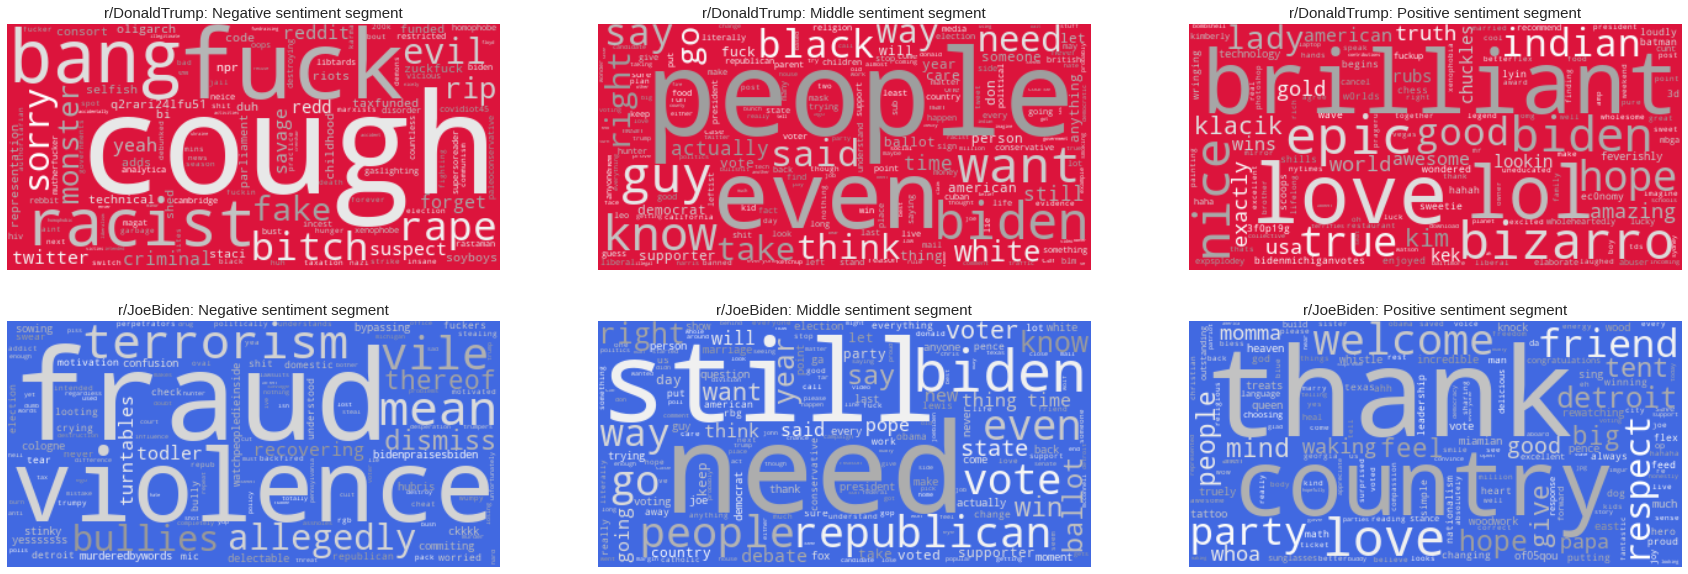

In [ ]:
def get_sentiment_word_cloud(wcloud, bgcolor):
  return wordcloud.WordCloud(background_color=bgcolor, color_func=grey_color_func, collocations=False, colormap="ocean", random_state=42).generate(wcloud)

def subplots_sentiment_wordclouds(wordclouds, nrows, ncols):
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30,10))
  row = 0
  cloud_idx = 0
  subreddits = ["r/DonaldTrump","r/JoeBiden"]
  colors = ["crimson", "royalblue"]
  sentiment = [": Negative sentiment segment", ": Middle sentiment segment", ": Positive sentiment segment"]
  for idx, ax_row in enumerate(axes):
    for jdx, ax in enumerate(ax_row): 
      ax.set_title(f"{subreddits[idx]}{sentiment[jdx]}", fontsize=15)
      ax.axis("off")
      _wcloud = get_sentiment_word_cloud(wordclouds[cloud_idx], bgcolor=colors[idx])
      ax.imshow(_wcloud, interpolation='bilinear')
      cloud_idx += 1
    row += 1
  fig.show()

subplots_sentiment_wordclouds(sentiment_wclouds, 2, 3)

We clearly see that the words in the WordClouds reflect the sentiment segments they represent. It is of interest to take a closer look at the differences in the words of each segment across the two subreddits:

**Negative sentiment segment:** 

The negative Trump words contains a lot of derogatory terms such as "bitch", "soyboys" (see https://www.urbandictionary.com/define.php?term=Soy%20Boy), "zuckfuck" (which is a reference to Mark Zuckerberg and apparently a verb, see https://www.urbandictionary.com/define.php?term=Zuckfuck) and "monster". Also we see that the word "fuck" is prominently featured, as well as words that are technically not derogatory but could indeed be imagined being used for criticizing people, namely "racist", "fake", "criminal" and "evil". 

The negative Biden words on the other hand seem at face value less personal and contains words such as "terrorism", "fraud" and "violence". This gives an indication that the prominent words with negative sentiment might have appeared in the context of a more civil discourse compared to the impression we get from looking at the Trump comments in the same segment. However if we look closely we also see words such as "stinky", "bully", "bullies", "turntables", "vile" and "fuckers" that also seem like words that could be used to describe people in a negative way. 

**Middle sentiment segment:**

In the middle segment which stems from comments with a neutral sentiment value we again see that skin color is featured in the r/DonaldTrump comments with words such as "white" and "black", where only "white" is visible in the r/JoeBiden comments. Also we see a theme which we have discussed before in the r/JoeBiden comments namely that of "vote" and "ballot". The middle segment does seem rather neutrally focused on discussing American politics with words such as "people" prominently featured in both subreddits and words like "republican" and "democrat" also visible.  


**Positive sentiment segment:**

We can see that the positive r/DonaldTrump comment segment seem to mention "kim", "kimberly" and "klacik" a lot: This likely means that there is a generally positive sentiment towards the Republican Kimberly Klacik (see https://en.wikipedia.org/wiki/Kimberly_Klacik). Also we see different variations of laughing on the internet such as "chuckles", "hahah", "lol" and "kek" (see https://www.urbandictionary.com/define.php?term=kek). Also like a small hello from the Marvel-DC assignment in this course, we see the word "bizarro" (https://en.wikipedia.org/wiki/Bizarro) and if we look closely in the upper right corner also "batman". Checking on Google however it seems that there has been a fair share of headlines calling Trumps worldview "bizarro" and this has apparently surfaced in positive contexts on r/DonaldTrump. The word "batman" may be due to Donald Trump having posted a twitter video with music from a Batman movie.  

For the r/JoeBiden positive comment segment we see words such as "momma" and "papa" which might indicate that family topics arise in positive contexts. Also there are words such as "heaven", "god" and "believe" appears to be specific for this segment. This points in the direction that religious words may appear more often in the r/JoeBiden comments and especially so in positive contexts. Also the word "thank" again stands really clearly out for the r/JoeBiden subreddit as we have observed earlier in the project. 

# 4 Discussion. Think critically about your creation



## 4.1 What went well
A lot of interesting observations have been made in the analysis of this work. Overall, we see that by scraping information on users commenting on the Trump and Biden subreddits, the users seem to be more active on subreddits of news oriented and political matter, compared to the overall picture of top 100 popular subreddits. 

By modelling the data as a projected network from a bipartite network of users and subreddits, we created a network where users connect proportional to how many top comments they have on the same unique subreddits. We found that due to the structure of reddit with many very popular subreddits among most users, this resulted in a very densely weighted network. Here we successfully managed to maintain the core information of the network, and at the same time greatly reduce the complexity of the network by extracting the multi scale backbone of our weighted network. 

Different community tools like the Louvain algorithm and modularity scores on the network revealed that there seems to be some community structure when parting the network with respect to whether we found users on the Trump or Biden subreddit. However, the community structure was not of great significance, which is very likely due to the many established connections between almost all users from the broadly popular subreddits. Several centrality measures revealed that users with top comments on the generally most popular subreddits emerged as central in the network. 

Nevertheless, investigation of this sparse signal on differences among the two presidential candidates’ subreddits revealed additional implications of differences. As supplement to the modularity indicating a small difference, the network furthermore showed this small polarisation among the users from comparing the strength of connections within the users of each candidate, to the strength of connections between users of different candidate. And moreover that the network seemed assortative with respect to what candidate subreddit page we found the user on. 

This motivated digging deeper into the differences. We did this by splitting the network into two subnetworks with respect to which candidate page we found the user on - a Biden and Trump subnetwork respectively. We discovered that Biden users were a lot more connected, likely as a result of being more active on the general popular subreddits. By ignoring the 100 most popular subreddits, further indications of polarisation showed as subreddits suggesting democratic and pro-Trump content appeared among Trump users and moreover also somewhat opposing con-Trump subreddits among Biden users. The two subnetworks furthermore revealed some fun tendencies - for example that the “conspiracies” subreddit is a lot more popular among the Trump users and subreddits of general political content were more frequent among Biden users. Finally we found some funny small niche communities of gamers within the Trump subnetwork and a community of people interested in the different American states in the Biden subnetwork. 

The text analysis went well in the sense that it also provided useful informatio some of which were news to us which we learned from looking at the network and looking it up on Google. 

As we looked into the collocations and concordances (contexts) of some of the words we drew out several real political topics such as the rumour about vote swapping in Fairfax County in Virginia and also when looking at Google it really does seem that there has been some Democratic concern about the mail-vote situation and voter suppression which was another observation we made from the comments. We also saw that black Americans had a higher number of mentions on r/DonaldTrump. We are inconclusive why this is the case, but it is interesting. Also we saw that r/DonaldTrump users express that they think Democrats and Joe Biden are racist, where as the r/JoeBiden users express that they think Donald Trump and his supporters are racist. This is interesting as this really is indicative of a polarization in the sense that each party seem to think that the other party has an evil mindset. 

On the broader exploratory text analysis level we got a slight and arguably insignificant signal that the r/DonaldTrump users are more lexically diverse. We also saw that the comments were in general very neutral in the words they used, but that the Trump comments was generally more extreme in both directions of the happiness scale. 

Finally we managed to create informative WordClouds on the basis of the split between r/DonaldTrump users and r/JoeBiden users and the split of the comments in either user group into sentiment segments. From this investigation we saw a signal that the Trump users may be using a more coarse language compared to the Biden users. Also we saw what may be an indication of a positive sentiment towards a Republican candidate Information about sentiments on politicians could potentially be very useful in various applications.



## 4.2 Improvements and further work
The complete analysis is based on the data we retrieved and is therefore heavily dependent on what we chose to retrieve and how. First of all our decision on scraping each candidate’s subreddit page for the top 36 threads, and within each of these the top 48 comments can be questioned whether is sufficient to represent the top users of each subreddit page. Moreover to which extent a users’ top 50 comments is representative. Choosing too few subreddits would increase the risk of obtaining very biased users on the subreddit - for example if the majority of threads was on a specific subject. Ideally, we would scrape the subreddit for all threads and its comments as well as all the user’s comments to obtain the complete information of each subreddit page and user. But obviously this would be very time consuming and we would then also be more likely to include the gibberish comments, as touched upon in section 1.3. 

The data would furthermore improve from more information on the users. Unfortunately, the users on reddit are anonymous and are therefore difficult to obtain more information on through other resources like Twitter, Youtube, etc. In retrospect, rather than just collecting which subreddits users had top comments on, it might have provided valuable information on users if we had also collected the associated comments. Our initial thought were that the structure of this data might have been too complex, since a comment is probably very dependent on both the context of the subreddit as well as the associated thread. Sticking with a single subreddit (Biden/Trump) removed some of this complexity.

As an addition to this work, it might be very informative to retrieve data on users where a political belief seems more obvious. Data could be retrieved only on users who had comments on several subreddit pages linking them to either political belief - for example requiring a “Trump” user to have a comment on the Trump, conservative, etc. subreddit pages and none on the Biden. It seems likely that we in this way would find Trump supporters, and thus we could investigate which other subreddits they typically have in common. This obviously introduces a polarisation and probably requires a very extensive data retrieval to get enough data. However, the outcome of the analysis would probably be very intersting.

Alternatively to using reddit as a source of data, it would be interesting to use other medias like Twitter for a comparative analysis. Twitter has many of the same properties which could be used for connections in a similar way. However, in recent years Twitter has become more cumbersome to scrape, making it more difficult to obtain enough valuable data from it. 

Another influential decision we made was how to connect users in the network. Our goal was to connect users based on how similar their interests were, represented by subreddits with their top comments. We chose to link users with weight proportional to how many *unique* subreddits users had in common. Alternatively we could also have taking frequency of comments on these subreddit into account when weighting links. This could then introduce that two users with all top 50 comments on a single subreddit would be equally strong connected as two users with a top comment on 50 different subreddits. We found the ladder the most meaningful in this work, as we wanted strong connections to be based on a more broad overlap of interest areas. Although, it would definitely be interesting to compare our findings with an analysis of the network connected in an alternative way. 

A way to partly avoid deciding how users link could be working with the bipartite network instead of its projection. A lot of research has been made on analysing bipartite networks. For instance, in [(2008, Sune Lehmann, et al.)](https://pubmed.ncbi.nlm.nih.gov/18764021/) the authors propose a method for detecting communities in bipartite networks. This approach could be used to better highlight what subreddits lead to the community structures

Moreover, our analysis showed that the overall popular subreddits were very common among both Biden and Trump users, which heavily influenced all connections. It would be interesting to compare our analysis to a similar network, but with all broadly popular subreddits filtrated away. However, this requires a sophisticated way of filtrating the subreddits. Just removing the e.g. global top 100 subreddits would potentially remove some patterns and introduce a (undesired) bias. For example, we found out that the global top 100 subreddit “politics”, was a lot more frequent among users of the network relative to the overall picture of reddit - and furthermore that it was primarily Biden users who commented on it. 

Finally, moving a bit away from the current field of theory, it would be an interesting experiment to see how well this data could be used to predict users to have top comments on either Trump or the Biden subreddit. For example, by encoding which subreddits users have top comments on as well as their comment content, one could try to exploit the representative power of neural networks to predict whether a new user is more likely to have a top comment on either subreddit. 


# 5 Contributions. Who did what?
- You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That’s what you should explain).

- It is not OK simply to write "All group members contributed equally".

